In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('D:\\6OHDA\\')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as Mcolors
import matplotlib.cm as cmx
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP
import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings
import pandas as pd
import sqlalchemy as db
import gc
from tqdm import tqdm
import seaborn as sns
import pywt # wavelet package
import matplotlib.cm as cm

In [3]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5','FinalData_6OHDA_H_skip.h5','FinalData_6OHDA_skip.h5']
miceList = getMiceList(Files[0])

In [4]:
#path to folder where figures should be saved
figFolder = 'D:\\6OHDA\\submission2\\'

In [5]:
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Acute' #day 1-13
    else:
        return 'Chronic' #day 14-35

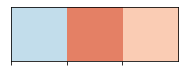

In [6]:

a3 = np.array(sns.color_palette("RdBu_r", n_colors=7))
# a3 = np.concatenate((a3[2,:],a3[4:,:]))
colorPallet3Post =(a3[[2,5,4],:])
sns.palplot(sns.color_palette(colorPallet3Post)) 



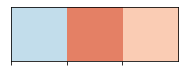

In [7]:
# set color pallet:
a3 = np.array(sns.color_palette("RdBu_r", n_colors=7))
# colorPallet3 =(a3[[2,6,5],:])
colorPallet3 =(a3[[2,5,4],:])
sns.palplot(sns.color_palette(colorPallet3))

<h2> Calculate session stats for results sction 1 </h2>

In [8]:
df = pd.DataFrame()
periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: (day >14)&(day<35)}

for per in periods.keys():
    data = getData(Files[1],['trace'],period ='Pre',day =periods[per])
    for sess in data.keys():
        m = sess[:4]
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred'])
        cre = getCreType(Files[1],m)
        numred = int(data[sess]['trace']['numred'])
        
        df= df.append({'mouse':m,'sess':sess,'day':day,
                       'period': periodCalc(day),'cre':cre,
                       'numred':numred,'numMsn':data[sess]['trace']['dff'].shape[0]},ignore_index=True)

d:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value


cleaning up trace data
cleaning up trace data
cleaning up trace data


In [9]:
df[~df.mouse.isin(['1253','1231'])].groupby(['period','cre']).agg([np.mean,sci.stats.sem])

day                numMsn               numred          
                  mean       sem        mean        sem      mean       sem
period  cre                                                                
Acute   CHI   6.645161  0.636773   82.387097  13.205300  1.064516  0.185121
        NA    7.000000  0.828417  136.277778  21.081511  0.000000  0.000000
        PV    6.418182  0.466155  185.563636  19.160386  2.454545  0.352784
Chronic CHI  24.176471  1.879133   95.117647  13.868575  1.117647  0.240746
        NA   21.333333  2.242271  207.555556  29.403850  0.000000  0.000000
        PV   23.066667  1.930869  183.466667  46.816243  1.000000  0.258199
Healthy CHI   0.000000  0.000000  187.666667  53.700108  1.466667  0.412503
        NA    0.000000  0.000000  155.444444  14.013001  0.000000  0.000000
        PV    0.000000  0.000000  184.166667  29.495015  1.833333  0.345371

In [11]:
df[~df.mouse.isin(['1253','1231'])].groupby(['period']).agg([np.mean,sci.stats.sem])
df[~df.mouse.isin(['1253','1231'])].to_csv(figFolder+'numberNeurons.csv')

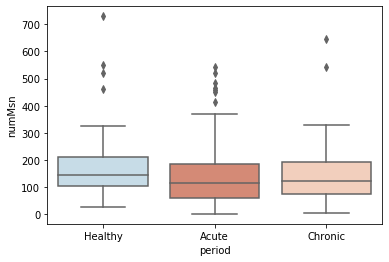

In [10]:
with sns.color_palette(colorPallet3):  
    sns.boxplot(x = "period",y = "numMsn",data = df[~df.mouse.isin(['1253','1231'])])

<h2> Figures </h2>

<h3> Figure 1 </h3>

d:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value
d:\6OHDA\IO.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  lfp = hf[m][s]['ePhys']['lfp'].value
d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value


cleaning up trace data
cleaning up lfp data
cleaning up speed data


<IPython.core.display.Javascript object>


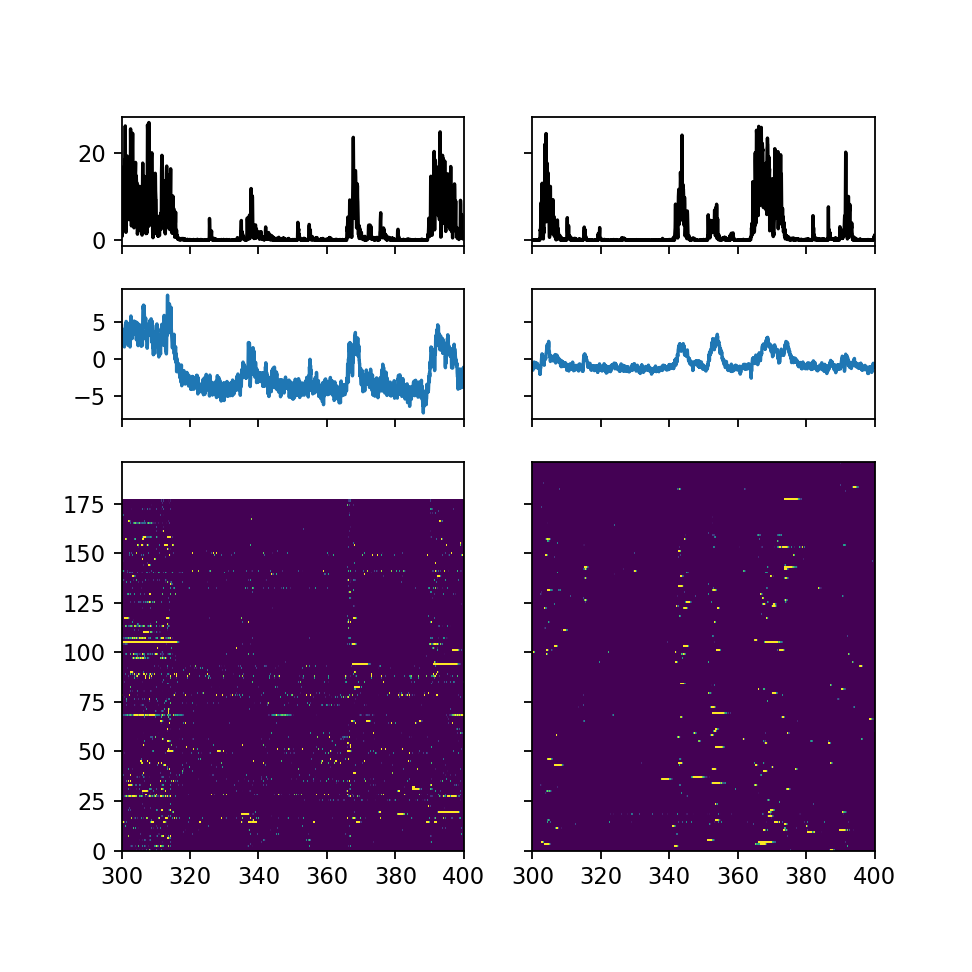

<IPython.core.display.Javascript object>


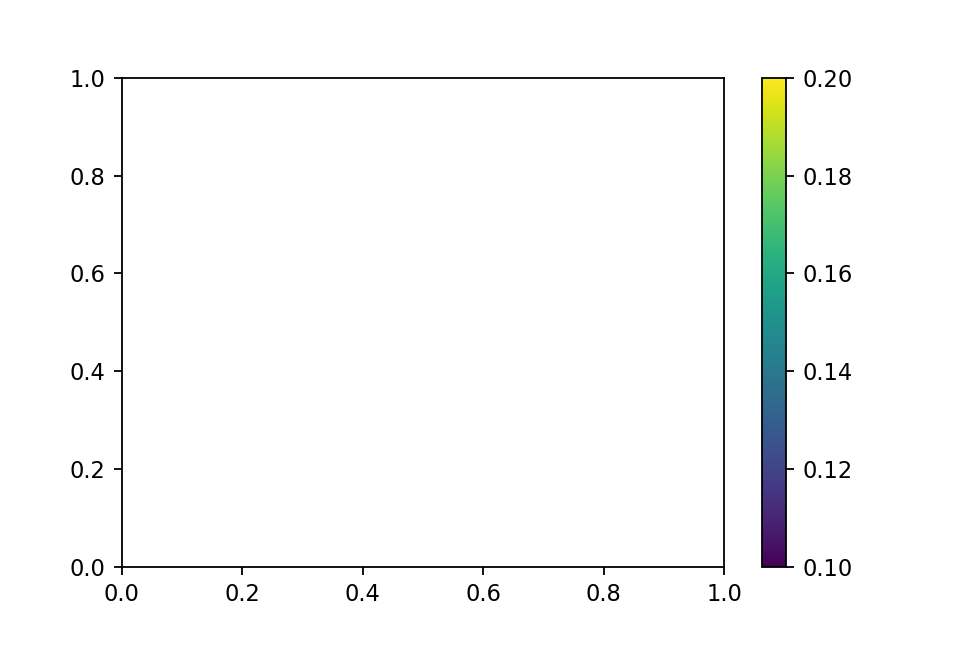

In [38]:
f = h5py.File('Spectograms.hdf5','r')

egSess = ['1236_BaselineS','1236_day30A']
egMouse = '1236'
data = getData(Files[1],['lfp','speed','trace'],period ='Pre',day =lambda day: (day==30) or (day==0), mice = [egMouse])

# plot lfp example:
fig, ax = plt.subplots(3,2,figsize=(6,6),sharex='col',sharey='row',gridspec_kw={'height_ratios': [1,1,3]})
# fig2, ax2 = plt.subplots(2,2,figsize=(6,3),sharex='col',gridspec_kw={'height_ratios': [1,3]})
for tPoint in range(0,2):
    sess = egSess[tPoint]
    dtS = 1/data[sess]['speed']['Fs']
    dtL = 1/data[sess]['lfp']['FS']
    ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
    tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

    ax[0,tPoint].plot(ts[6000:8001],data[sess]['speed']['speed'][0,6000:8001],color='black')
    
    ts = np.arange(0, np.max(data[sess]['trace']['dff'].shape[1])) * dtS 
    dff = data[sess]['trace']['dff']
    dff = dff.T-np.nanmean(dff,axis=1)
    dff = dff.T
    dsum = np.sum((dff[:,6000:8001]),axis=0)
    ax[1,tPoint].plot(ts[6000:8001],dsum)
    
#     lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
#     lfp = data[sess]['lfp']['lfp']
#     lfp[(lfpOutliers[:,0]==1)] = np.nan
#     ax2[0,tPoint].plot(tl[0:5000],lfp[0:5000])

#     freq = f[egMouse]['freq'].value
#     coeff = np.abs(f[egMouse][sess]['Pre']['coeff'].value)
    
#     coeff[:,(lfpOutliers[:,0]==1)] = np.nan

#     ax2[1,tPoint].pcolormesh(tl[0:5000],freq,coeff[:,0:5000], rasterized=True)
    CS = ax[2,tPoint].pcolormesh(ts[6000:8001],np.arange(0,dff.shape[0]),dff[:,6000:8001],vmax=.2,vmin=0.1, rasterized=True)
    
    
fig.savefig(figFolder+'figure1a_Ca.png')
fig.savefig(figFolder+'figure1a_Ca.svg',transparent=True)
fig2, ax = plt.subplots(1,1)
fig2.colorbar(CS)
# fig2.savefig(figFolder+'figure1a_lfp_'+str(egSess[0])+"_"+str(egSess[1][5:])+'.png')
fig2.savefig(figFolder+'figure1a_colorbar.svg',transparent=True)

<h3> Figure 2 </h3>

d:\6OHDA\IO.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  rot = hf[m][s]['mvmt']['rotation'].value
d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value


cleaning up speed data
cleaning up rot data


d:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
d:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


(260, 360)

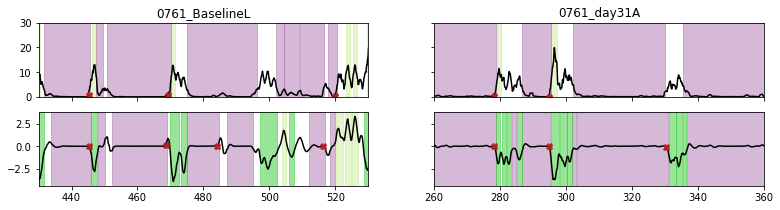

In [11]:
m = "0761"
sessList = [m+"_BaselineL",m+"_day31A"]
data = getData(Files[1],['speed','rot'],period ='Pre', mice=m, day = lambda x: (x==0) or (x==31))
conds = ['high','low','stright','ipsi','contra']
Color = CP('highLowSpeed')
Color['stright'] =Color['low'] #'tomato'
Color['ipsi']='limegreen'
Color['contra']=Color['high']
indX = 0
fig, ax  = plt.subplots(2,2,figsize=(13,3),sharey='row',sharex='col')
for sess in sessList:
    segments = {'high':{'ax':0,'start':getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_EndSegments')},
                'low':{'ax':0,'start':getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_EndSegments')},
                'stright':{'ax':1,'start':getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','loPeriods_EndSegments')},
                'ipsi':{'ax':1,'start':getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','hiACPeriods_EndSegments')},
                'contra':{'ax':1,'start':getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','hiCPeriods_EndSegments')}}
    sOnset =  getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
    speed = data[sess]['speed']['speed'].T
    
    rOnset =  getOnsetOrPeriod(m,sess,'Pre','rotOnset')
    rot = data[sess]['rot']['rot'].T
    
    t = np.arange(0,len(speed))*0.05
    ax[0,indX].plot(t,smooth(speed,20),color='black')
    ax[1,indX].plot(t,smooth(rot,20),color='black')
    for cond in conds:
        for l in range(0, len(segments[cond]['start'])):
            ax[segments[cond]['ax'],indX].axvspan(t[segments[cond]['start'][l]], t[segments[cond]['end'][l]], color= Color[cond], alpha=0.5)
    ax[0,indX].plot(t[sOnset],speed[sOnset],'X',color='firebrick')
    ax[0,indX].set_ylim(0,30) 
    ax[1,indX].plot(t[rOnset],rot[rOnset],'X',color='firebrick')
    ax[0,indX].set_title(sess)
    indX = indX+1
ax[1,0].set_xlim(430,530)
ax[1,1].set_xlim(260,360)
#ax[1,1].set_ylim(-2.2,2)

#fig.savefig(figFolder+'figure2_mvmtOnset.png')
# fig.savefig(figFolder+'figure2_mvmtOnset.svg',transparent=True)

In [127]:
speedData = []

miceList = getMiceList(Files[1])
for m in miceList:
    data = getData(Files[1],['speed'],period ='Pre', mice=m)
    
    # calculte % high speed + % low speed
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        Hp = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
        Lp = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
        comb = Hp*1+((Lp*1)-1)*-1
                
        row['percent_low'] = np.sum(Lp*1)/len(Lp)
        row['percent_high'] = np.sum(Hp*1)/len(Hp)
        row['percent_medium'] = np.sum(comb==1)/len(comb)
        
        trans = comb[1:]-comb[:-1]
        
        row['tran_all'] = np.sum(np.abs(trans!=0))
        row['tran_low2any'] = np.sum(np.abs(Lp[1:]*1-Lp[:-1]*1))
        row['tran_high2any'] = np.sum(np.abs(Hp[1:]*1-Hp[:-1]*1))
        
        row['MvmtOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Pre','mvmtOnset'))        
        speedData.append(row)
          
df = pd.DataFrame(speedData)        
df['Period'] =  df.apply (lambda row: periodCalc(row.Day) , axis=1)
df.to_csv(figFolder+'speedData.csv')

D:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data


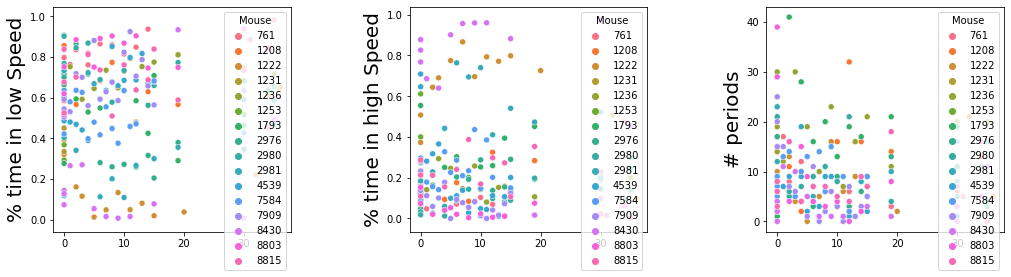

In [138]:
df2 = pd.read_csv(figFolder+'speedData.csv')
df2.Mouse = df2.Mouse.astype("category")
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
# with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
columns = ['percent_low','percent_high','MvmtOnset'] 
labels = ['% time in low Speed','% time in high Speed','# periods']
for ind in range(len(columns)):
    sns.scatterplot(x="Day", y=columns[ind], data=df2,ax =ax[ind],hue='Mouse')
#         sns.swarmplot(x="Period", y=columns[ind], data=df2,ax =ax[ind],order = pOrder,color = 'Black')
    #sns.scatterplot(x="Period", y=columns[ind], data=df2,ax =ax[ind])
#     ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
    ax[ind].set_ylabel(labels[ind],fontsize=20)
    ax[ind].set_xlabel("")
        


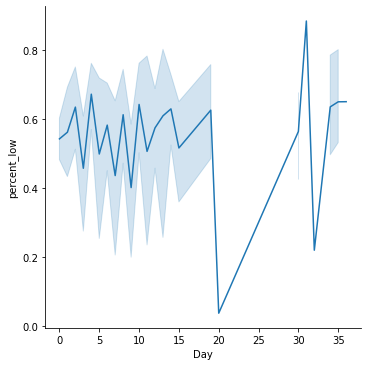

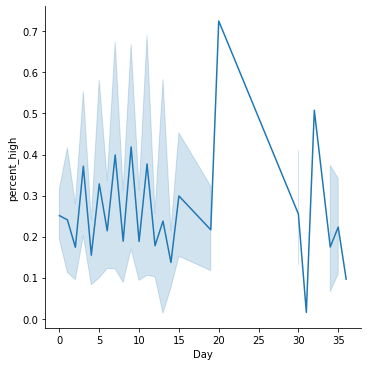

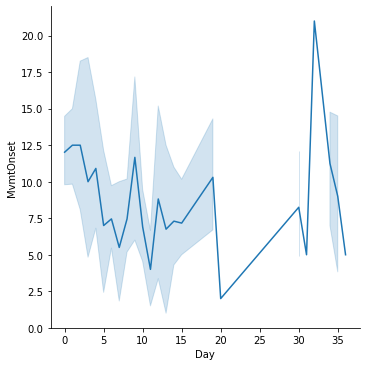

In [141]:
df2 = pd.read_csv(figFolder+'speedData.csv')
df2.Mouse = df2.Mouse.astype("category")
# fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
# with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
columns = ['percent_low','percent_high','MvmtOnset'] 
labels = ['% time in low Speed','% time in high Speed','# periods']
for ind in range(len(columns)):
    sns.relplot(x="Day", y=columns[ind], data=df2,kind="line")
#         sns.swarmplot(x="Period", y=columns[ind], data=df2,ax =ax[ind],order = pOrder,color = 'Black')
    #sns.scatterplot(x="Period", y=columns[ind], data=df2,ax =ax[ind])
#     ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
#     ax[ind].set_ylabel(labels[ind],fontsize=20)
#     ax[ind].set_xlabel("")
        


In [31]:
df2

Unnamed: 0 Mouse         Session  Day  percent_low  percent_high  \
0             0   761  0761_BaselineA    0     0.797294      0.053534   
1             1   761  0761_BaselineL    0     0.725523      0.097235   
2             2   761  0761_BaselineS    0     0.584839      0.114800   
3             3   761       0761_day1    1     0.763594      0.047483   
4             4   761      0761_day10   10     0.814858      0.103622   
..          ...   ...             ...  ...          ...           ...   
209         209  8815     8815_day30A   30     0.733277      0.229580   
210         210  8815     8815_day34L   34     0.450672      0.474370   
211         211  8815       8815_day4    4     0.812521      0.154790   
212         212  8815       8815_day6    6     0.736301      0.240415   
213         213  8815       8815_day8    8     0.509664      0.387143   

     percent_medium  tran_all  tran_low2any  tran_high2any  MvmtOnset   Period  
0          0.149172       131           101             30         14  Healthy  
1          0.177242       139            73             66         15  Healthy  
2          0.300361       167            89             78          8  Healthy  
3          0.188923       135           109             26         17    Acute  
4          0.081519        76            40             36          8    Acute  
..              ...       ...           ...            ...        ...      ...  
209        0.037143        71            30             41          7  Chronic  
210        0.074958       143            48             95         16  Chronic  
211        0.032689        51            17             34          4    Acute  
212        0.023284        45            18             27          7    Acute  
213        0.103193       178            34            144          7    Acute  

[214 rows x 12 columns]

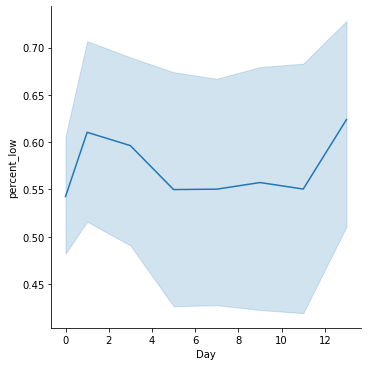

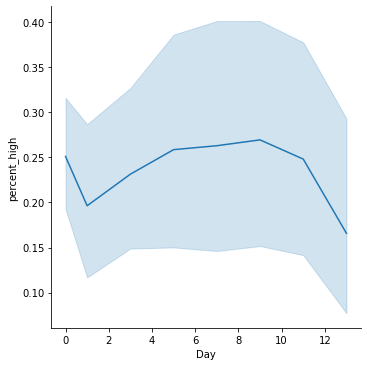

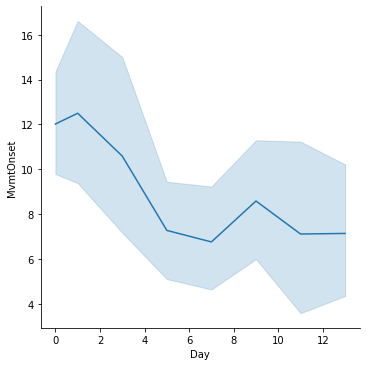

In [46]:
df2 = pd.read_csv(figFolder+'speedData.csv')
df2.Mouse = df2.Mouse.astype("category")
groups = df2.groupby(['Session', pd.cut(df2.Day, [-1,0,2,4,6,8,10,12,14], labels=[0,1,3,5,7,9,11,13])]).mean().drop(columns=['Day']).reset_index()

# fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
# with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
columns = ['percent_low','percent_high','MvmtOnset'] 
labels = ['% time in low Speed','% time in high Speed','# periods']
for ind in range(len(columns)):
    sns.relplot(x="Day", y=columns[ind], data=groups,kind="line")
#         sns.swarmplot(x="Period", y=columns[ind], data=df2,ax =ax[ind],order = pOrder,color = 'Black')
    #sns.scatterplot(x="Period", y=columns[ind], data=df2,ax =ax[ind])
#     ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
#     ax[ind].set_ylabel(labels[ind],fontsize=20)
#     ax[ind].set_xlabel("")
  

In [48]:
df2

Unnamed: 0 Mouse         Session  Day  percent_low  percent_high_AC  \
0             0   761  0761_BaselineA    0     0.657534         0.042104   
1             1   761  0761_BaselineL    0     0.635936         0.030759   
2             2   761  0761_BaselineS    0     0.470628         0.067233   
3             3   761       0761_day1    1     0.610556         0.025800   
4             4   761      0761_day10   10     0.746365         0.006555   
..          ...   ...             ...  ...          ...              ...   
209         209  8815     8815_day30A   30     0.762773         0.002017   
210         210  8815     8815_day34L   34     0.521765         0.043361   
211         211  8815       8815_day4    4     0.813782         0.026303   
212         212  8815       8815_day6    6     0.758369         0.000000   
213         213  8815       8815_day8    8     0.514286         0.043866   

     percent_high_C  percent_non  trans  tran_low2high  tran_high2low  \
0          0.115976     0.184385    179             89             90   
1          0.178418     0.154887    171             85             86   
2          0.178839     0.283301    232            116            116   
3          0.209850     0.153794    171             85             86   
4          0.142533     0.104547     98             49             49   
..              ...          ...    ...            ...            ...   
209        0.045630     0.189580     93             46             47   
210        0.044538     0.390336    192             96             96   
211        0.106050     0.053866     55             27             28   
212        0.080138     0.161492     66             33             33   
213        0.067815     0.374034    146             73             73   

     rotOnset  cRotOnset  acRotOnset   Period  
0          13         10           3  Healthy  
1          17         14           3  Healthy  
2           9          1           8  Healthy  
3          16         15           1    Acute  
4           4          4           0    Acute  
..        ...        ...         ...      ...  
209         4          4           0  Chronic  
210        15          4          11  Chronic  
211         4          3           1    Acute  
212         3          1           2    Acute  
213         4          2           2    Acute  

[214 rows x 15 columns]

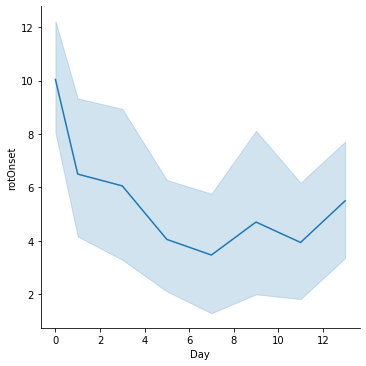

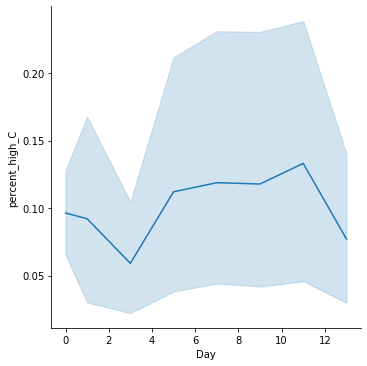

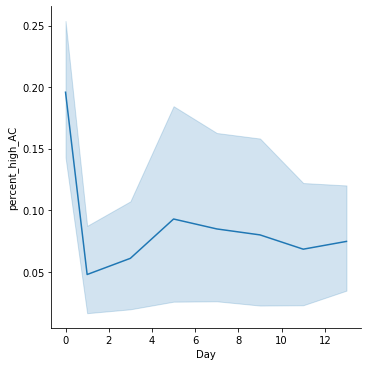

In [49]:
df2 = pd.read_csv(figFolder+'rotation_forR.csv')
df2.Mouse = df2.Mouse.astype("category")
groups = df2.groupby(['Session', pd.cut(df2.Day, [-1,0,2,4,6,8,10,12,14], labels=[0,1,3,5,7,9,11,13])]).mean().drop(columns=['Day']).reset_index()

# fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
# with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
columns = ['rotOnset','percent_high_C','percent_high_AC'] 
labels = ['% time in low Speed','% time in high Speed','# periods']
for ind in range(len(columns)):
    sns.relplot(x="Day", y=columns[ind], data=groups,kind="line")
#         sns.swarmplot(x="Period", y=columns[ind], data=df2,ax =ax[ind],order = pOrder,color = 'Black')
    #sns.scatterplot(x="Period", y=columns[ind], data=df2,ax =ax[ind])
#     ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
#     ax[ind].set_ylabel(labels[ind],fontsize=20)
#     ax[ind].set_xlabel("")
  

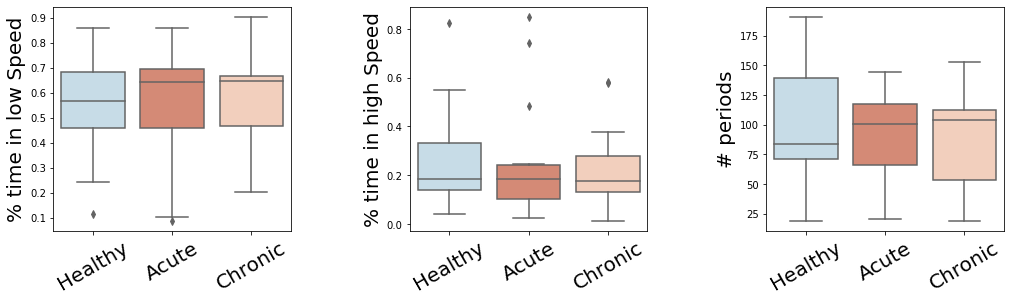

In [14]:
df2 = df.groupby(['Mouse','Period']).mean()
df2.reset_index(inplace=True)

fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Acute','Chronic']
with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
    columns = ['percent_low','percent_high','tran_low2any'] 
    labels = ['% time in low Speed','% time in high Speed','# periods']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2,ax =ax[ind],order = pOrder)
#         sns.swarmplot(x="Period", y=columns[ind], data=df2,ax =ax[ind],order = pOrder,color = 'Black')
        #sns.scatterplot(x="Period", y=columns[ind], data=df2,ax =ax[ind])
        ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
        ax[ind].set_ylabel(labels[ind],fontsize=20)
        ax[ind].set_xlabel("")
        
        
#fig.savefig(figFolder+'figure2_abc.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure2_b1.svg',transparent=True,format='svg')


d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
<ipython-input-15-e31e092cee75>:15: RuntimeWarning: invalid value encountered in true_divide
  hist  = hist/np.nansum(hist) # normalize per mouse


cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up

d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
<ipython-input-15-e31e092cee75>:15: RuntimeWarning: invalid value encountered in true_divide
  hist  = hist/np.nansum(hist) # normalize per mouse


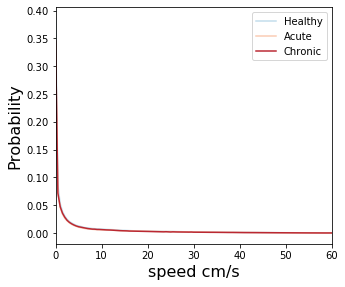

In [15]:
periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: (day >14)&(day<35)}

fig, ax = plt.subplots(1,1,figsize=(5.99,5.67),gridspec_kw = {'hspace':.1,'bottom':0.3,'left':.26})
for indP,p in enumerate(periods.keys()):
    #to make sure mice are equally represented in each period
    weightsH = np.zeros((199,))
    for m in miceList:
        dataH = getData(Files[1],['speed'],period ='Pre', day = periods[p],mice = m)
        speedM = np.empty((1,0))
        for sess in dataH:
            speedM = np.concatenate((speedM, dataH[sess]['speed']['speed']), axis=1)
        hist, bin_edges = np.histogram(speedM, bins=np.arange(0,200)*0.5)
        hist  = hist/np.nansum(hist) # normalize per mouse
        weightsH = np.nansum((weightsH, hist),axis=0)

    ax.plot(np.arange(0,199)*0.5,weightsH/16,label=p,color=a3[2*indP+2,:])    
ax.set_xlim(0,60)
ax.set_xlabel('speed cm/s',fontsize=16)
ax.set_ylabel('Probability',fontsize=16)
ax.legend(fontsize=10)
#fig.savefig(figFolder+'figure2_b2.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure2_b2.svg',transparent=True,format='svg')

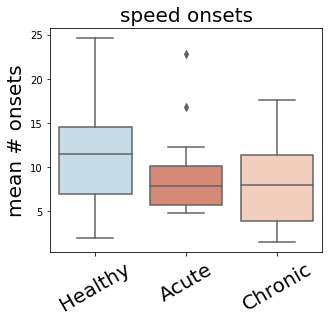

In [16]:
df2 = df.groupby(['Mouse','Period']).mean()
df2.reset_index(inplace=True)

fig, ax = plt.subplots(1,1,figsize=(4.88,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Acute','Chronic']
with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
    columns = ['MvmtOnset'] 
    labels = ['speed onsets']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2,ax =ax,order = pOrder)
        #sns.scatterplot(x="Period", y=columns[ind], data=df2,ax =ax[ind])
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30,fontsize=20)
        ax.set_ylabel("mean # onsets",fontsize=20)
        ax.set_xlabel("")
        ax.set_title(labels[ind],fontsize=20)
        
#fig.savefig(figFolder+'figure2_b3.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure2_b3.svg',transparent=True,format='svg')


In [142]:
rotData = []

miceList = getMiceList(Files[1])
for m in miceList:
    data = getData(Files[1],['rot'],period ='Pre', mice=m)
    
    # calculte % high rot + % low rot
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        hACp = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
        hCp = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
        Lp = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
        comb = hACp*8+Lp*5+hCp*7
                
        row['percent_low'] = np.sum(Lp*1)/len(Lp)
        row['percent_high_AC'] = np.sum(hACp*1)/len(hACp)
        row['percent_high_C'] = np.sum(hCp*1)/len(hCp)
        row['percent_non'] = np.sum(comb==0)/len(comb)
        
        trans = comb[1:]-comb[:-1]
        
        row['trans'] = np.sum(trans!=0)
        row['tran_low2high'] = np.sum(trans>0)
        row['tran_high2low'] = np.sum(trans<0)
        row['rotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Pre','rotOnset')) 
        row['cRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Pre','clockWiseOnset'))
        row['acRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Pre','antiClockWiseOnset'))
        
        rotData.append(row)
          
dfRot = pd.DataFrame(rotData)        
dfRot['Period'] =  dfRot.apply (lambda row: periodCalc(row.Day) , axis=1)
dfRot.to_csv(figFolder+'rotation_forR.csv')

D:\6OHDA\IO.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  rot = hf[m][s]['mvmt']['rotation'].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data


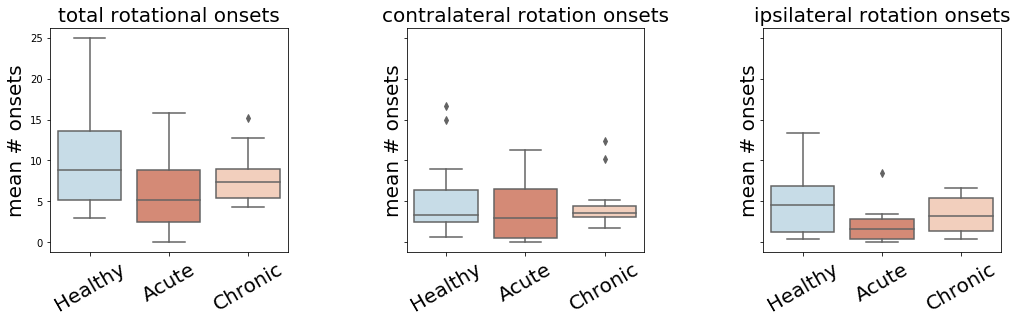

In [143]:
dfRot = pd.read_csv(figFolder+'rotation_forR.csv')
df2Rot = dfRot.groupby(['Mouse','Period']).mean()
df2Rot.reset_index(inplace=True)
df2Rot

fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey = True,gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Acute','Chronic']
with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
    columns = ['rotOnset','cRotOnset','acRotOnset'] 
    labels = ['total rotational onsets','contralateral rotation onsets','ipsilateral rotation onsets']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind],order = pOrder)
#         sns.swarmplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind],order = pOrder,color='black')
        #sns.scatterplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind])
        ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
        ax[ind].set_ylabel("mean # onsets",fontsize=20)
        ax[ind].set_xlabel("")
        ax[ind].set_title(labels[ind],fontsize=20)

#fig.savefig(figFolder+'figure2c_1.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure2c_1.svg',transparent=True,format='svg')


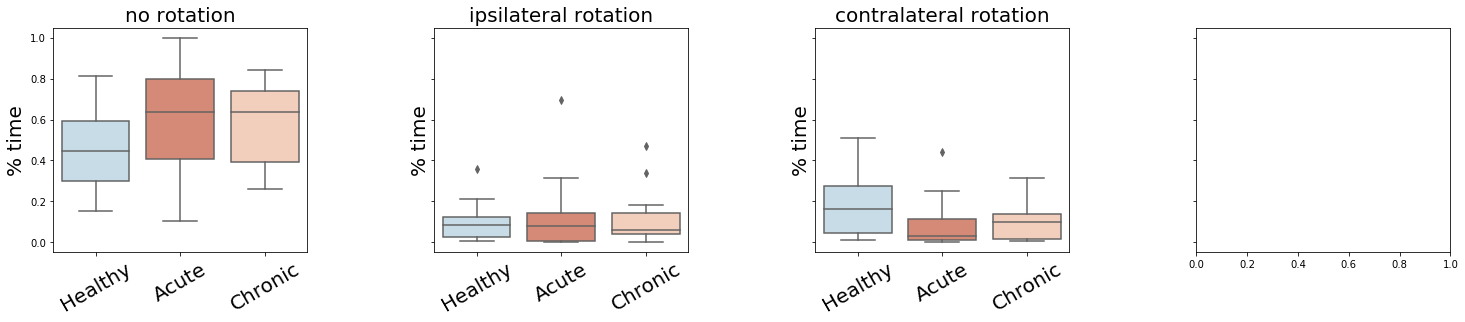

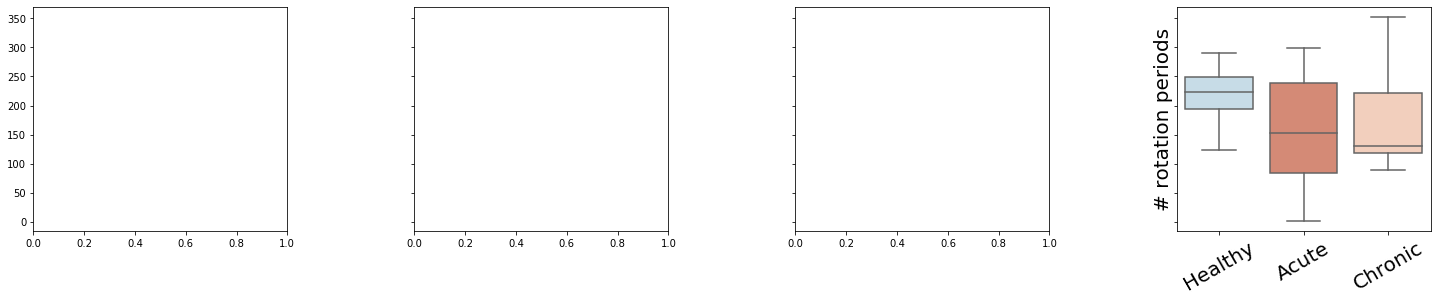

In [20]:
# repeat with paired t-test
# sns.set_style("white")
df2Rot = dfRot.groupby(['Mouse','Period']).mean()
df2Rot.reset_index(inplace=True)
df2Rot

fig, ax = plt.subplots(1,4,figsize=(25.04,4.88),sharey=True,gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
fig2, ax2 = plt.subplots(1,4,figsize=(25.04,4.88),sharey=True,gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Acute','Chronic']
with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
    columns = ['percent_low','percent_high_AC','percent_high_C','trans'] 
    labels = ['no rotation','ipsilateral rotation',
              'contralateral rotation','']
    Ylabels = ['% time','% time','% time','# rotation periods']
    for ind in range(len(columns)):
        if ind <3:
            sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind],order = pOrder)
            #sns.scatterplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind])
            ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
            ax[ind].set_ylabel(Ylabels[ind],fontsize=20)
            ax[ind].set_xlabel("")  
            ax[ind].set_title(labels[ind],fontsize=20)     
        else:
            sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax2[ind],order = pOrder)
            #sns.scatterplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind])
            ax2[ind].set_xticklabels(ax2[ind].get_xticklabels(),rotation=30,fontsize=20)
            ax2[ind].set_ylabel(Ylabels[ind],fontsize=20)
            ax2[ind].set_xlabel("")  
            ax2[ind].set_title(labels[ind],fontsize=20)      

#fig.savefig(figFolder+'figure2c_2.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure2c_2.svg',transparent=True,format='svg')
# fig2.savefig(figFolder+'figure2c_2b.svg',transparent=True,format='svg')


<h3> Figure 3 </h3>

cleaning up trace data


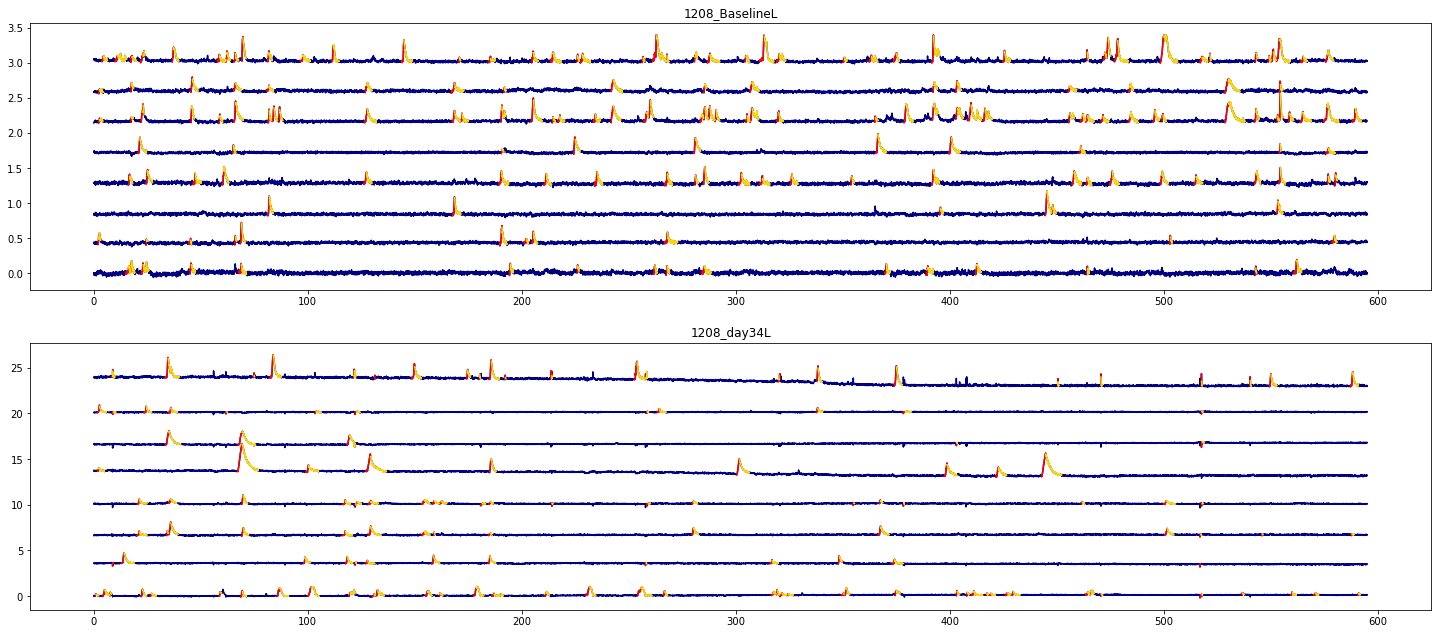

In [36]:
warnings.filterwarnings("ignore")

f = h5py.File('OnsetsAndPeriods.hdf5','r')
# align spectogram to spike onset -> for each mouse and in total,seperate by CRE:
sessList = {'1208_BaselineL':27,'1208_day34L':5}
m = '1208'
data = getData(Files[1],['trace'],period ='Pre',day =lambda day: (day==34) or (day==0), mice = [m])

# constents for analysis:
tracePerSlide = 8
colors = {'TD':'black','TD_skip':'indianred','MSN':'navy','MSN_skip':'royalblue'}
lf = {'left':0.30, 'top':1.30, 'height':10.80, 'width':25.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}

fig, ax = plt.subplots(2,1,figsize=(lf['width'],lf['height']))
fig.set_size_inches(lf['width'],lf['height'],forward=True)

indX = 0
for sess in sessList.keys():
    # get traces:
    dff = data[sess]['trace']['dff']
    dt = 1/data[sess]['trace']['FS'][0]
    t = np.linspace(0,dt*dff.shape[1],dff.shape[1])
    Fs = data[sess]['trace']['FS'][0]
    # Vectors are saved as column vectors so.. transposed to raw vector
    if dff.shape[1] == 1:
        dff = dff.T
    # get CaOnset:
    caOnset = f[m][sess]['Pre']['caOnset_Hf'].value
    caFall =  f[m][sess]['Pre']['caFall_Hf'].value
    caOnset[caOnset==0] =np.nan
    caFall[caFall==0] =np.nan
    numred = int(data[sess]['trace']['numred'][0])

    tLim = int(600*Fs)
    N = sessList[sess]
    endN = np.min(((N+1)*tracePerSlide,dff.shape[0]))
    T=0;
    endT = np.min(((T+1)*tLim,dff.shape[1]))
    df = dff[N*tracePerSlide:endN,T*tLim:endT]
    ca = caOnset[N*tracePerSlide:endN,T*tLim:endT]
    ca = ca*df
    cf = caFall[N*tracePerSlide:endN,T*tLim:endT]
    cf = cf*df
    spacing = np.max(np.abs(df))
    Color = ['navy' for x in range(0,df.shape[0])]
    if tracePerSlide*N <numred:
        Nl = min(tracePerSlide,numred-N*tracePerSlide)
        Color[0:Nl] = [colors['TD'] for x in range(0,Nl)]
        Color[Nl:] = [colors['MSN'] for x in range(Nl,len(Color))]
    else:
        Color = [colors['MSN'] for x in range(0,len(Color))]
    for d in range(0,df.shape[0]):
        ax[indX].plot(t[T*tLim:endT],df[d,:]+d*spacing,color=Color[d],rasterized=True) 
        ax[indX].plot(t[T*tLim:endT],ca[d,:]+d*spacing,color='red',rasterized=True)
        ax[indX].plot(t[T*tLim:endT],cf[d,:]+d*spacing,color='gold',rasterized=True)
    ax[indX].set_title(sess)
    indX = indX+1
#fig.savefig(figFolder+'figure3_eventDetection'+'.png')
# fig.savefig(figFolder+'figure3_eventDetection_rasterized'+'.svg',transparent=True)




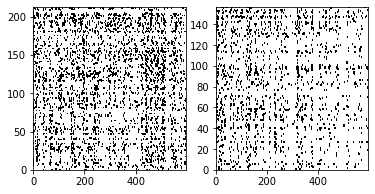

In [25]:
warnings.filterwarnings("ignore")

f = h5py.File('OnsetsAndPeriods.hdf5','r')
# align spectogram to spike onset -> for each mouse and in total,seperate by CRE:
sessList = {'1208_BaselineS':10,'1208_day34L':10}
m = '1208'

fig, ax = plt.subplots(1,2,figsize=(6,3),sharex='col')
indX = 0
for sess in sessList.keys():
    # get traces:
    
    # get CaOnset:
    caOnset = f[m][sess]['Pre']['caOnset_Hf'].value
    caOnset[caOnset==0] = np.nan
    ts = np.arange(0, np.max(caOnset.shape[1])) * .05 
    ax[indX].pcolormesh(ts[:],np.arange(0,caOnset.shape[0]),caOnset[:,:],cmap=cm.gray,rasterized=True)
    indX =indX+1
    

# fig.savefig(figFolder+'figure3_binaryRastor'+'.png')
# fig.savefig(figFolder+'figure3_binaryRastor_rasterized2'+'.svg',transparent=True)




In [38]:
# data for all mice - homomorphic filter 
PVdata = getData(Files[1],['speed','trace'],period ='Pre', cre='PV',red = True)
MSNdata = getData(Files[1],['speed','trace'],period ='Pre',red = False)
CHIdata = getData(Files[1],['speed','trace'],period ='Pre', cre='CHI',red = True)


cleaning up trace data
I deleted session: 1236_day19L
I deleted session: 4539_day11
I deleted session: 4539_day5
I deleted session: 7584_day0
I deleted session: 7909_day30A
I deleted session: 8430_BaselineA
I deleted session: 8430_day1
I deleted session: 8430_day15A
I deleted session: 8430_day9
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day30A
I deleted session: 8803_day5
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 0761_day1
I deleted session: 0761_day12
I deleted session: 0761_day14A
I deleted session: 0761_day2
I deleted session: 0761_day31A
I deleted session: 1208_BaselineA
I deleted session: 1222_BaselineA
I deleted session: 1222_day11
I deleted session: 1222_day13
I deleted session: 1222_day2
I deleted session: 1222_day20L
I deleted session: 1222_day3
I deleted session: 1222_day32A
I deleted session: 1222_day36L
I deleted session: 1222_day5
I deleted s

In [39]:
#f = h5py.File('OnsetsAndPeriods.hdf5','r')
col_names = ['Mouse','Sess','Day','highSpeed','medSpeed','lowSpeed','All_',
             'acc','dcc','rotAcc','rotDcc','highACrot','highCrot','lowRot']
dfC = pd.DataFrame(columns = col_names)
cond = ['PVdata','MSNdata','CHIdata']
transWindow = np.ones((10,1))
for c in cond:
    data = eval(c)
    for sess in data.keys():
#         try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            m = sess[0:4]

            Hp = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            Lp = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            Mp = ((Hp+Lp)==0)
            hACp = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            hCp = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            Lrp = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            comb = hACp*8+Lp*5+hCp*7
            rotTrans = comb[1:]-comb[:-1]           
            
            Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
            numRed = int(data[sess]['trace']['numred'])
            if c in ['PVdata','CHIdata']:
                Ca = Ca[:numRed,:]
            else:
                Ca = Ca[numRed+1:,:]
            CaO = Ca[:,1:]-Ca[:,:-1]
            if CaO.shape[1]<Hp.shape[0]:
                 CaO = np.append(CaO,np.zeros((CaO.shape[0],1)),axis=1)
            C_start = (CaO==1)*1
            C_end = (CaO==-1)*1
            Acc = np.append(np.convolve(np.diff(Lp*1+Hp*2)>0, transWindow[:,0], mode='same')>0,False)
            Dcc = np.append(np.convolve(np.diff(Lp*1+Hp*2)<0, transWindow[:,0], mode='same')>0,False)
            rotAcc = np.append(np.convolve(rotTrans>0, transWindow[:,0], mode='same')>0,False)
            rotDcc = np.append(np.convolve(rotTrans<0, transWindow[:,0], mode='same')>0,False)
            if rotAcc.shape[0] >Acc.shape[0]:
                rotAcc = rotAcc[:Acc.shape[0]]
                rotDcc = rotDcc[:Acc.shape[0]]
                    

            
            a = np.asarray([np.sum(C_start[:,Hp],axis=1),np.sum(C_start[:,Mp],axis=1),
                            np.sum(C_start[:,Lp],axis=1),np.sum(C_start,axis=1),
                            np.sum(C_start[:,Acc],axis=1),np.sum(C_start[:,Dcc],axis=1),
                            np.sum(C_start[:,rotAcc],axis=1),np.sum(C_start[:,rotDcc],axis=1),
                            np.sum(C_start[:,hACp],axis=1),np.sum(C_start[:,hCp],axis=1),
                            np.sum(C_start[:,Lrp],axis=1)]).T
            
            df2C = pd.DataFrame(a, columns = col_names[3:])
            df2C['totalTime'] = (Hp.shape[0]/1200)
            df2C['lowTime'] = np.sum(Lp/1200)
            df2C['medTime'] = np.sum(Mp/1200)
            df2C['highTime'] = np.sum(Hp/1200)
            df2C['lowRotTime'] = np.sum(Lp/1200)
            df2C['highACRotTime'] = np.sum(hACp/1200)
            df2C['highCRotTime'] = np.sum(hCp/1200)
            df2C['totTrans'] = np.sum(rotTrans!=0)
            df2C['rotAccTrans'] = np.sum(rotTrans>0)
            df2C['rotDccTrans'] = np.sum(rotTrans<0)
            df2C['accTrans'] = np.sum(np.diff(Lp*1+Hp*2)>0)
            df2C['dccTrans'] = np.sum(np.diff(Lp*1+Hp*2)<0)
            df2C['Day'] = day
            df2C['Mouse'] = m
            df2C['Sess'] = sess
            df2C['CellType'] = c[:-4]
            df2C['Period'] = periodCalc(day)
            dfC = pd.concat([dfC,df2C],sort=True)
#         except:
#             print(sess)


dfC['high_speed'] =  dfC.apply (lambda row: row.highSpeed/row.highTime if row.highTime != 0 else None, axis=1)
dfC['medium_speed'] = dfC.apply (lambda row: row.medSpeed/row.medTime, axis=1)
dfC['low_speed'] = dfC.apply (lambda row: row.lowSpeed/row.lowTime , axis=1)
dfC['high_ACrot'] =  dfC.apply (lambda row: row.highACrot/row.highACRotTime if row.highACRotTime != 0 else None, axis=1)
dfC['high_Crot'] = dfC.apply (lambda row: row.highCrot/row.highCRotTime if row.highCRotTime != 0 else None, axis=1)
dfC['low_rot'] = dfC.apply (lambda row: row.lowRot/row.lowRotTime if row.lowRotTime != 0 else None, axis=1)
dfC['All'] = dfC.apply (lambda row: row.All_/row.totalTime , axis=1)
dfC['Acc'] = dfC.apply (lambda row: row.acc/row.accTrans , axis=1)
dfC['Dcc'] = dfC.apply (lambda row: row.dcc/row.dccTrans , axis=1)
dfC['Acc_'] = dfC.apply (lambda row: row.acc/row.All_ if row.All_ >0 else 0 , axis=1)
dfC['Dcc_'] = dfC.apply (lambda row: row.dcc/row.All_ if row.All_ >0 else 0 , axis=1)
dfC['rotAcc'] = dfC.apply (lambda row: row.rotAcc/row.rotAccTrans , axis=1)
dfC['rotDcc'] = dfC.apply (lambda row: row.rotDcc/row.rotDccTrans , axis=1)
dfC['rotAcc_'] = dfC.apply (lambda row: row.rotAcc/row.All_ if row.All_ >0 else 0 , axis=1)
dfC['rotDcc_'] = dfC.apply (lambda row: row.rotDcc/row.All_ if row.All_ >0 else 0 , axis=1)


dfC['totAcc_'] = dfC.apply (lambda row: (row.dcc+row.acc)/row.All_ if row.All_ >0 else 0 , axis=1)
dfC['totRotAcc_'] = dfC.apply (lambda row: (row.rotDcc+row.rotAcc)/row.All_ if row.All_ >0 else 0 , axis=1)


dfC.head()


dfC.to_csv(figFolder+'firingRateDf.csv')

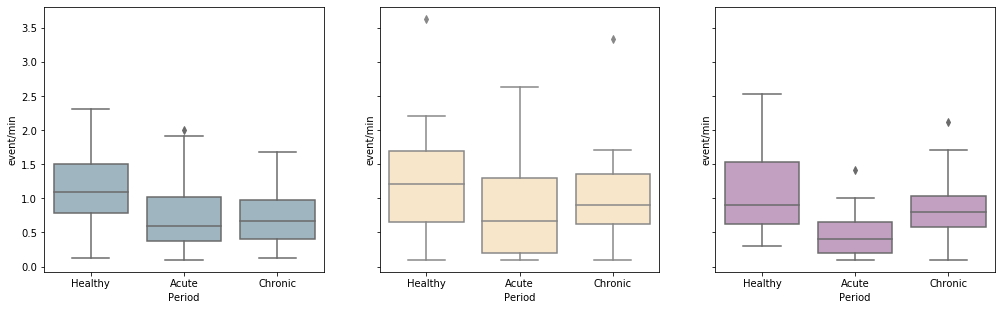

In [30]:
dfC = pd.read_csv(figFolder+ 'firingRateDf.csv')
# same plot, but by session... (Sense check)
dfM = dfC[(dfC.All>0)][['Sess','Period','CellType','All']]
#dfM = dfM.merge(dfM.Dcc_.apply(lambda s: pd.Series({'All':s<0.05, 'Dcc_1':(s>=0.05)&(s<0.4),'Dcc_3':s>=0.9, 'Dcc_2':(s>=0.4)&(s<0.9)})), 
#    left_index=True, right_index=True)
dfM2 = dfM.groupby(['Sess','Period','CellType'],as_index=False).mean()
df_long = pd.melt(dfM2,id_vars=['CellType','Period'], value_vars=['All'],value_name='event/min')
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey=True)
ind = 0
colors = ['#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
for cell in cells:
#     g = sns.swarmplot(x="Period", y="event/min",data=df_long[(df_long.CellType == cell)],color = [.2,.2,.2],dodge = True,
#                       order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'],
#                       ax=ax[ind],**{'label':'_nolegend_'})
    g = sns.boxplot(x="Period", y="event/min",data=df_long[(df_long.CellType == cell)], dodge = True,
                    order = ['Healthy', 'Acute', 'Chronic'],
                    color=colors[ind],ax=ax[ind])
    ind = ind +1
# fig.savefig(figFolder+'figure3_b.svg',transparent=True,format='svg')


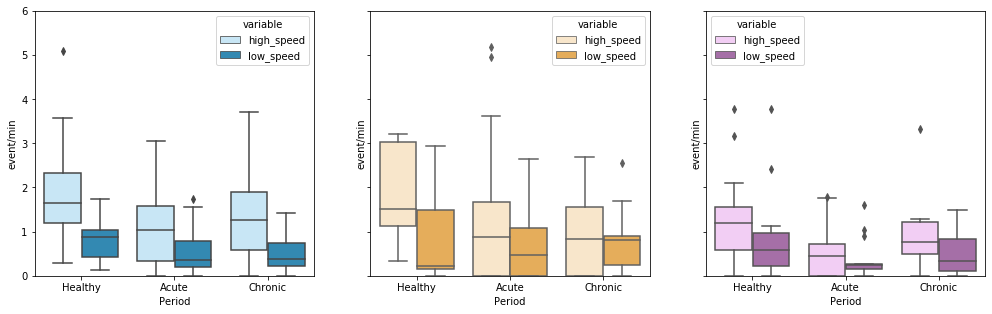

In [40]:
#print(dfC.columns)
# for each cell, high and low speed on same plot - Average per session

dfM = dfC[(dfC.All>0)][['Sess','Period','CellType','high_speed',
                        'low_speed', 'high_ACrot', 'high_Crot','low_rot']]
dfM2 = dfM.groupby(['Sess','Period','CellType'],as_index=False).mean()

columns = ['high_speed', 'low_speed']#, 'high_ACrot', 'high_Crot','low_rot'] 
df_long = pd.melt(dfM2,id_vars=['CellType','Period','Sess'], value_vars=columns,value_name='event/min')
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey=True)
indC = 0
colors = {'MSN':['#c0e9fc','#1e91c7'], 'PV':['#FFE7C4','#fcb144'],'CHI':['#f8c8fa','#ad66b0']} #'#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
for cell in cells:
#     g = sns.swarmplot(x="Period", y="event/min",hue ='variable' ,data=df_long[(df_long.CellType == cell)],color = [.2,.2,.2],dodge = True,
#                       order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'], 
#                       ax=ax[indC],**{'label':'_nolegend_','alpha':0.5,'s':3})
    g = sns.boxplot(x="Period",hue ='variable', y="event/min",data=df_long[(df_long.CellType == cell)], dodge = True,
                   order = ['Healthy', 'Acute', 'Chronic'],
                   palette=colors[cell],ax=ax[indC])

    ax[indC].set_ylim(0,6)
    indC = indC +1
#fig.savefig(figFolder+'figure3_c.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure3_c.svg',transparent=True,format='svg')
#HIGHSPEED

In [9]:
#  for all mice - by period
PV0 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x==0)
PV1 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='PV',red = True,day = lambda x: (x>0)& (x<13) )
PV2 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x>=13 )

CHI0 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x==0)
CHI1 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: (x>0)& (x<13) )
CHI2 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x>=13 )

MSN0 = getData(Files[1],['speed','rot','trace'],period ='Pre', red = False,day = lambda x: x==0)
MSN1 = getData(Files[1],['speed','rot','trace'],period ='Pre', red = False,day = lambda x: (x>0)& (x<13) )
MSN2 = getData(Files[1],['speed','rot','trace'],period ='Pre', red = False,day = lambda x: x>=13 )

D:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value
D:\6OHDA\IO.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  rot = hf[m][s]['mvmt']['rotation'].value
D:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value


cleaning up trace data
I deleted session: 7584_day0
I deleted session: 8430_BaselineA
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 4539_day11
I deleted session: 4539_day5
I deleted session: 8430_day1
I deleted session: 8430_day9
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day5
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 1236_day19L
I deleted session: 7909_day30A
I deleted session: 8430_day15A
I deleted session: 8803_day30A
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 1208_BaselineA
I deleted session: 1222_BaselineA
I deleted session: 1253_BaselineA
I deleted session: 1253_BaselineS
I deleted session: 1793_BaselineA
I deleted session: 8815_BaselineL
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 0

D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype

Text(0.5, 1.0, 'speed')

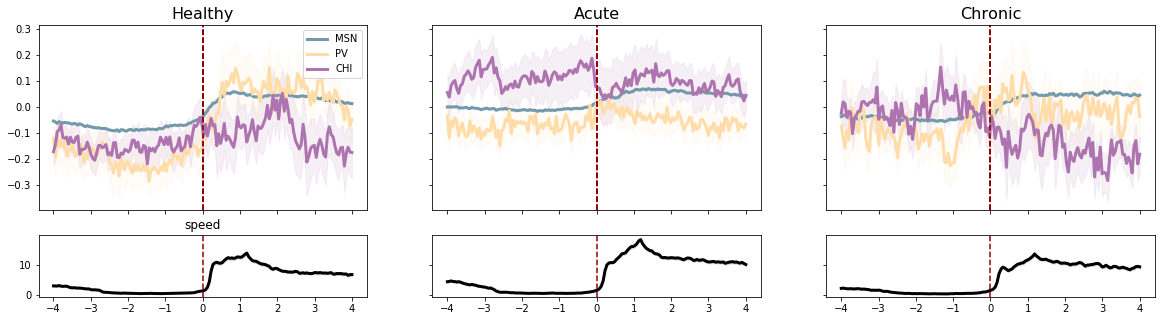

In [9]:
fig, ax = plt.subplots(2,3,figsize=(20, 5),sharex='col',sharey='row',gridspec_kw={'height_ratios': [3,1]})
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Acute':1,'Chronic':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = {'Healthy':{},'Acute':{},'Chronic':{}}

for p in Period.keys():
    axInd = 0;
    for c in cond:
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['speed']['speed'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            sOnset = getOnsetOrPeriod(m,s,'Pre','mvmtOnset2')    
            if np.sum(sOnset) == 0:
                continue
            
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
            
      
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        quant[p][c] = sAligned
        if c== 'MSN':
            PlotRelativeToOnset(ax[1,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            quant[p]['speed'] = sAlignedS
            del sAlignedS
        del sAligned
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
# ax[0,0].set_ylim(-0.5,0.5)
# ax[1,0].set_ylim(-0.5,1)
# ax[2,0].set_ylim(-0.5,0.75)
ax[1,0].set_title('speed')

# fig.savefig(figFolder+'figure 4a.svg',transparent=True)

In [60]:
df = pd.DataFrame(columns=['Period','CellType','pre','post'])
for p in quant.keys():
    di = quant[p]
    for c in di.keys():
        bl = di[c][:80]
        mu = np.mean(bl)
        std = np.std(bl)
        tr = (di[c]-mu)/std
        df2 = pd.DataFrame({'Period':p,'CellType':c,'pre':np.mean(tr[:80],axis=0),'post':np.mean(tr[80:],axis=0)})
        df = pd.concat([df,df2])
df.to_csv(figFolder+'fig3E_quantification.csv')

MSN
__________________________________________
Healthy : S =  -27.54944472034841  P-val =  1.0846507427913976e-159 True
Acute : S =  -18.198128556687923  P-val =  3.823332276462101e-73 True
Chronic : S =  -18.941755261752366  P-val =  1.8888847041946943e-78 True
__________________________________________
speed
__________________________________________
Healthy : S =  -30.007274078633134  P-val =  1.2986123546756367e-119 True
Acute : S =  -37.45921589421687  P-val =  4.755569959816885e-186 True
Chronic : S =  -30.344770592538246  P-val =  2.5150833102684528e-116 True
__________________________________________
PV
__________________________________________
Healthy : S =  -3.761859684590277  P-val =  0.0006803464279440823 True
Acute : S =  -1.3934093938630434  P-val =  0.16611512003626883 False
Chronic : S =  -1.351937763943293  P-val =  0.18650056591838204 False
__________________________________________
CHI
__________________________________________
Healthy : S =  -1.0150027116683875  P-

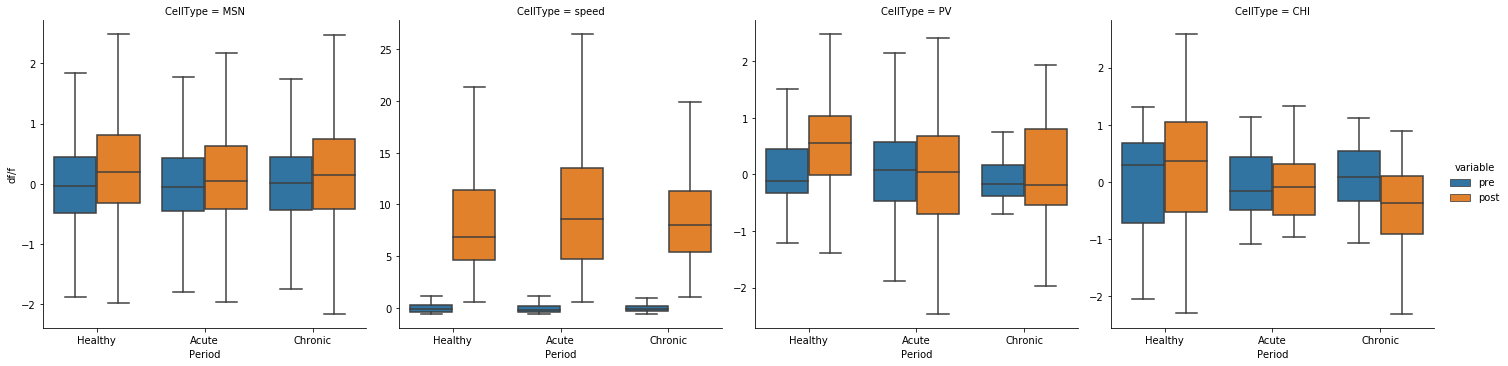

In [17]:
df = pd.read_csv(figFolder+'fig3E_quantification_2s.csv')
df2 = pd.melt(df,id_vars=['CellType','Period'], value_vars=['pre','post'],value_name='df/f')
df2
sns.catplot(x='Period',y='df/f',hue='variable',col='CellType',data=df2,
            kind='box',sharey=False,showfliers = False)
for c in df2.CellType.unique():
    print(c)
    print('__________________________________________')
    df3 = df[df.CellType==c]
    for p in df3.Period.unique():
        df4 = df3[df3.Period==p]
        #s,P  = sci.stats.wilcoxon(df4.pre, y=df4.post)
        s,P  = sci.stats.ttest_rel(df4.pre, df4.post)
        print(p,': S = ',s,' P-val = ',P,P<0.05)
    print('__________________________________________')
plt.savefig(figFolder+'figure3S_prePost_mvmt_noFliers.svg',transparent=True)

MSN
__________________________________________
Healthy : S =  -22.58350624394998  P-val =  8.853987151552466e-110 True
Acute : S =  -15.192390951945486  P-val =  4.0991842864498315e-51 True
Chronic : S =  -21.874071966764937  P-val =  7.410749698319422e-103 True
__________________________________________
speed
__________________________________________
Healthy : S =  -27.58462510673576  P-val =  9.1559224600266e-101 True
Acute : S =  -30.337400369555553  P-val =  1.775986777012153e-114 True
Chronic : S =  -24.60393386826417  P-val =  3.905982905861045e-87 True
__________________________________________
PV
__________________________________________
Healthy : S =  -2.6668092506605725  P-val =  0.011910042636185164 True
Acute : S =  -2.6565893502398166  P-val =  0.01795335266334847 True
Chronic : S =  -1.2342677236603947  P-val =  0.234925150605377 False
__________________________________________
CHI
__________________________________________
Healthy : S =  -1.1062935790589645  P-val =  0

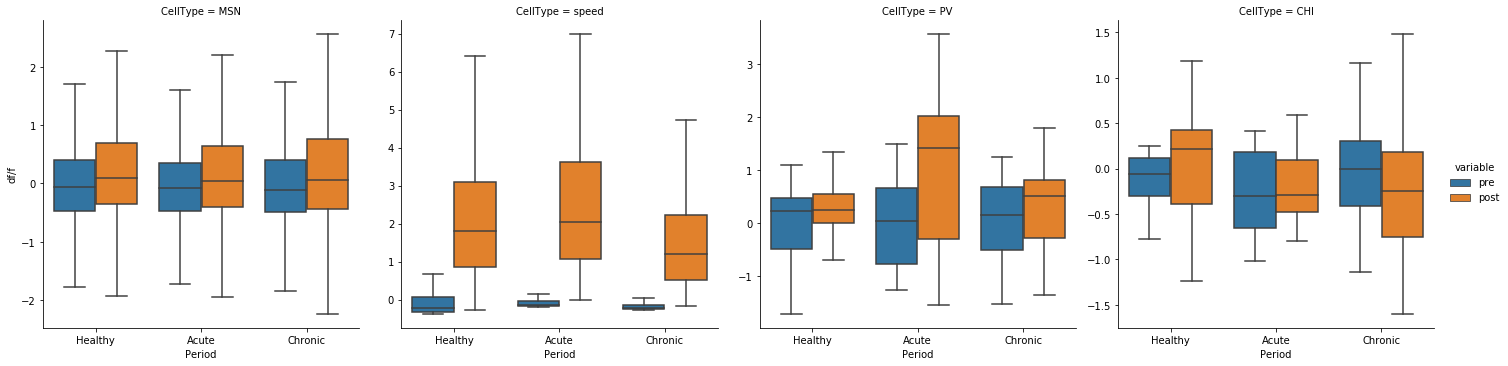

In [20]:
df = pd.read_csv(figFolder+'fig3E_quantification_rot.csv')
df2 = pd.melt(df,id_vars=['CellType','Period'], value_vars=['pre','post'],value_name='df/f')
df2
sns.catplot(x='Period',y='df/f',hue='variable',col='CellType',data=df2,
            kind='box',sharey=False,showfliers = False)
for c in df2.CellType.unique():
    print(c)
    print('__________________________________________')
    df3 = df[df.CellType==c]
    for p in df3.Period.unique():
        df4 = df3[df3.Period==p]
        #s,P  = sci.stats.wilcoxon(df4.pre, y=df4.post)
        s,P  = sci.stats.ttest_rel(df4.pre, df4.post)
        print(p,': S = ',s,' P-val = ',P,P<0.05)
    print('__________________________________________')
plt.savefig(figFolder+'figure3S_prePost_rot_noFliers.svg',transparent=True)

MSN
 S =  68.04909544936159  P-val =  3.253218908541296e-30 True 30541
Multiple Comparison of Means - Tukey HSD, FWER=0.05
 group1  group2 meandiff p-adj lower  upper  reject
---------------------------------------------------
  Acute Chronic   0.0485 0.001 0.0201  0.077   True
  Acute Healthy   0.1456 0.001 0.1163 0.1749   True
Chronic Healthy   0.0971 0.001 0.0649 0.1293   True
---------------------------------------------------
Healthy 0.27999752418620955
Acute 0.13436952662043644
Chronic 0.18289359337936764
__________________________________________
speed
 S =  4.243968167566689  P-val =  0.014480898996718127 True 1989
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
  Acute Chronic  -0.8014 0.1567 -1.8223  0.2196  False
  Acute Healthy  -1.1682  0.015 -2.1527 -0.1837   True
Chronic Healthy  -0.3668 0.7049 -1.4887  0.7551  False
---------------------------------------

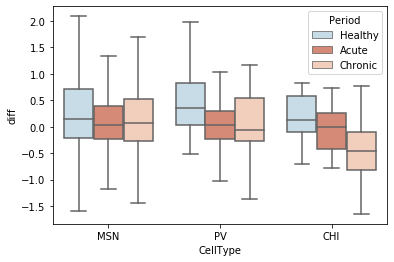

In [15]:
df = pd.read_csv(figFolder+'fig3E_quantification_2s.csv')
df['diff'] = df.apply(lambda x: x.post - x.pre, axis=1)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
sns.boxplot(x='CellType',y='diff',hue='Period',data=df[df.CellType != 'speed'],palette=colorPallet3,showfliers=False)
for c in df.CellType.unique():
    print(c)
    #print('__________________________________________')
    df3 = df[df.CellType==c]
    s,P  = sci.stats.f_oneway(df3[df3.Period=='Healthy']['diff'].values, 
                              df3[df3.Period=='Acute']['diff'].values, df3[df3.Period=='Chronic']['diff'].values)
    print(' S = ',s,' P-val = ',P,P<0.05,df3['diff'].count())
    
    m_comp = pairwise_tukeyhsd(endog=df3['diff'].astype(float), groups=df3.Period, alpha=0.05)
         
    print(m_comp)
    for p in df3.Period.unique():
        print(p,df3[df3.Period==p]['diff'].mean())
    print('__________________________________________')
# plt.savefig(figFolder+'figure3E_new_mvmt.svg',transparent=True)


D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype

Text(0.5, 1.0, 'speed')

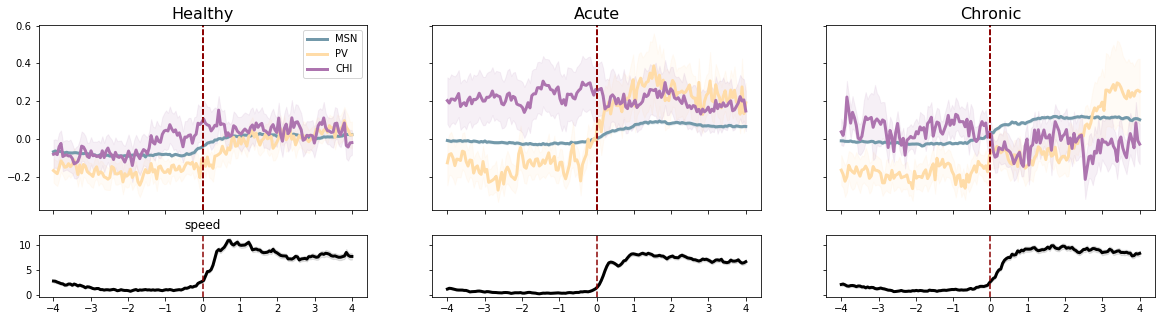

In [10]:
fig, ax = plt.subplots(2,3,figsize=(20, 5),sharex='col',sharey='row',gridspec_kw={'height_ratios': [3,1]})
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Acute':1,'Chronic':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = {'Healthy':{},'Acute':{},'Chronic':{}}

for p in Period.keys():
    axInd = 0;
    for c in cond:
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['speed']['speed'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            cOnset =  getOnsetOrPeriod(m,s,'Pre','clockWiseOnset2') 
            acOnset = getOnsetOrPeriod(m,s,'Pre','antiClockWiseOnset2')  
            sOnset = cOnset+acOnset    
            if np.sum(sOnset) == 0:
                continue
            
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
            
      
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        quant[p][c] = sAligned
        if c== 'MSN':
            PlotRelativeToOnset(ax[1,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            quant[p]['speed'] = sAlignedS
            del sAlignedS
        del sAligned
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
# ax[0,0].set_ylim(-0.5,0.5)
# ax[1,0].set_ylim(-0.5,1)
# ax[2,0].set_ylim(-0.5,0.75)
ax[1,0].set_title('speed')

# fig.savefig(figFolder+'figure 4a.svg',transparent=True)

In [11]:
df = pd.DataFrame(columns=['Period','CellType','pre','post'])
for p in quant.keys():
    di = quant[p]
    for c in di.keys():
        bl = di[c][40:80]
        mu = np.mean(bl)
        std = np.std(bl)
        tr = (di[c]-mu)/std
        df2 = pd.DataFrame({'Period':p,'CellType':c,'pre':np.mean(tr[40:80],axis=0),'post':np.mean(tr[80:120],axis=0)})
        df = pd.concat([df,df2])
df.to_csv(figFolder+'fig3E_quantification_rot.csv')

MSN
 S =  9.009323209425137  P-val =  0.00012272180702810394 True 21736
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
  Acute Chronic   0.0664  0.001  0.0296 0.1033   True
  Acute Healthy   0.0429 0.0137  0.0071 0.0786   True
Chronic Healthy  -0.0236  0.214 -0.0565 0.0094  False
-----------------------------------------------------
Healthy 0.2132927740395623
Acute 0.17042775277202127
Chronic 0.2368505424658208
__________________________________________
speed
 S =  28.96861570333006  P-val =  4.619498925995962e-13 True 1449
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
  Acute Chronic   -0.795  0.001 -1.0477 -0.5423   True
  Acute Healthy  -0.2198 0.1043 -0.4731  0.0336  False
Chronic Healthy   0.5752  0.001  0.3208  0.8296   True
-------------------------

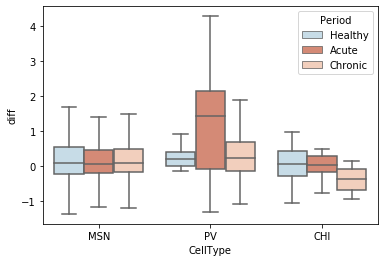

In [11]:
df = pd.read_csv(figFolder+'fig3E_quantification_rot.csv')
df['diff'] = df.apply(lambda x: x.post - x.pre, axis=1)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
sns.boxplot(x='CellType',y='diff',hue='Period',data=df[df.CellType != 'speed'],palette=colorPallet3,showfliers=False)
for c in df.CellType.unique():
    print(c)
    #print('__________________________________________')
    df3 = df[df.CellType==c]
    s,P  = sci.stats.f_oneway(df3[df3.Period=='Healthy']['diff'].values, 
                              df3[df3.Period=='Acute']['diff'].values, df3[df3.Period=='Chronic']['diff'].values)
    print(' S = ',s,' P-val = ',P,P<0.05,df3['diff'].count())
    
    m_comp = pairwise_tukeyhsd(endog=df3['diff'].astype(float), groups=df3.Period, alpha=0.05)
         
    print(m_comp)
    for p in df3.Period.unique():
        print(p,df3[df3.Period==p]['diff'].mean())
    print('__________________________________________')
# plt.savefig(figFolder+'figure3E_new_rot.svg',transparent=True)

In [52]:
def perNeuronPerEvent2(aDff,dff,onset,niter,PostS=40,preS=40):
    if np.min(dff.shape) ==1:
        aDff = np.reshape(aDff,(aDff.shape[0],1,aDff.shape[1]))
    if np.sum(onset) ==1:
        aDff = np.reshape(aDff,(aDff.shape[0],aDff.shape[1],1))
        
    nT,nN,nE = aDff.shape
    # if no event in session -> move on...
    if nE == 0:
        return None,None,None
    if onset.ndim ==1:
        onset = np.reshape(onset,(1,onset.shape[0]))
    
        
    Th = np.empty((nN,niter))
    # calculate thersholds:
    for itr in range(0,niter):
        shifts = np.random.randint(size=1,low=0,high=onset.shape[1])
        Ons = circShiftRoll(shifts,onset)
        sdff = alignToOnset(dff.T, Ons, winPost=PostS,winPre=preS)
            
        # when 1 or movement events -> could end up with no event 2 secounds in -> empty sdff
        while isinstance(sdff,int) or sdff.ndim <3:
            shifts = np.random.randint(size=1,low=0,high=onset.shape[1])
            Ons = circShiftRoll(shifts,onset)
            sdff = alignToOnset(dff.T, Ons, winPost=PostS,winPre=preS)
            try:
                if sdff.size ==0:
                    sdff = 0    
                    continue
                if nN ==1:
                    sdff = np.reshape(sdff,(sdff.shape[0],1,sdff.shape[1]))
                if nE ==1: 
                    sdff = np.reshape(sdff,(sdff.shape[0],sdff.shape[1],1))
            except: 
                sdff = 1;



        # if sdff contain negative value, shift entire session up
        mins = np.min(sdff,axis=0)
        sdff[:,mins<0] =sdff[:,mins<0]+np.abs(mins[mins<0])
        # calculate the means
        sdff = np.mean(sdff,axis=2)
        muPre = np.mean(sdff[:int(nT/2),:],axis=0)
        muPost = np.mean(sdff[int(nT/2):,:],axis=0)
        ra = muPost/muPre  
        Th[:,itr] = ra

    Th = np.percentile(Th,95,axis=1)

    mins = np.min(aDff,axis=0)
    aDff[:,mins<0] =aDff[:,mins<0]+np.abs(mins[mins<0])
    aDff = np.mean(aDff,axis=2)
    prePoints = aDff[:int(nT/2),:]
    postPoints = aDff[int(nT/2):,:]

    muPre = np.mean(prePoints,axis=0)
    muPost = np.mean(postPoints,axis=0)
    results = muPost/muPre    
#    print(nE,nN,Th.shape,results.shape)
    return (results>Th),results,Th

In [72]:
# only needs to run once... 
from numpy import matlib
niter = 10000
PostS=40
preS = 40
f = h5py.File('membership2.hdf5','a')
miceList = getMiceList(Files[0])
faild = []
for m in tqdm(miceList):
    data = getData(Files[1],['trace'],period ='Pre', mice=m)
    try:
        grp = f.create_group(m)
    except: 
        grp = f[m]
    
    for sess in tqdm(data.keys()):
        try: 
            sgrp = grp[sess]
        except: 
            sgrp = grp.create_group(sess)
        try: 
            subgroup = sgrp.create_group('mvmtOnset')
            subgroup2 = sgrp.create_group('ipsiOnset')
            subgroup3 = sgrp.create_group('contraOnset')
            subgroup4 = sgrp.create_group('rotOnset')
        except:
            subgroup = sgrp['mvmtOnset']
            subgroup2 = sgrp['ipsiOnset']
            subgroup3 = sgrp['contraOnset']
            subgroup4 = sgrp['rotOnset']

        dff = data[sess]['trace']['dff']
        mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset2')
    #    print(mvmtOnset.shape)
        aDff = alignToOnset(dff.T, mvmtOnset, winPost=PostS,winPre=preS)
        onset = np.reshape(mvmtOnset,(1,np.max(mvmtOnset.shape)))
    #    print(aDff.shape,onset.shape,mvmtOnset.shape)

        result,rawResults,Th = perNeuronPerEvent2(aDff,dff,onset,niter)
        if np.sum(onset) != 0:
            subgroup['result'] = result
            subgroup['rawResults'] = rawResults
            subgroup['Th'] = Th
        
        mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','clockWiseOnset2')
    #    print(mvmtOnset.shape)
        aDff = alignToOnset(dff.T, mvmtOnset, winPost=PostS,winPre=preS)
        onset = np.reshape(mvmtOnset,(1,np.max(mvmtOnset.shape)))
    #    print(aDff.shape,onset.shape,mvmtOnset.shape)

        result,rawResults,Th = perNeuronPerEvent2(aDff,dff,onset,niter)
        if np.sum(onset) != 0:
            subgroup3['result'] = result
            subgroup3['rawResults'] = rawResults
            subgroup3['Th'] = Th
        
        mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','antiClockWiseOnset2')
    #    print(mvmtOnset.shape)
        aDff = alignToOnset(dff.T, mvmtOnset, winPost=PostS,winPre=preS)
        onset = np.reshape(mvmtOnset,(1,np.max(mvmtOnset.shape)))
    #    print(aDff.shape,onset.shape,mvmtOnset.shape)

        result,rawResults,Th = perNeuronPerEvent2(aDff,dff,onset,niter)
        if np.sum(onset) != 0:
            subgroup2['result'] = result
            subgroup2['rawResults'] = rawResults
            subgroup2['Th'] = Th
        
        mvmtOnseti = getOnsetOrPeriod(m,sess,'Pre','clockWiseOnset2')
        mvmtOnsetc = getOnsetOrPeriod(m,sess,'Pre','antiClockWiseOnset2')
        mvmtOnset = mvmtOnseti + mvmtOnsetc
    #    print(mvmtOnset.shape)
        aDff = alignToOnset(dff.T, mvmtOnset, winPost=PostS,winPre=preS)
        onset = np.reshape(mvmtOnset,(1,np.max(mvmtOnset.shape)))
    #    print(aDff.shape,onset.shape,mvmtOnset.shape)

        result,rawResults,Th = perNeuronPerEvent2(aDff,dff,onset,niter)
        if np.sum(onset) != 0:
            subgroup4['result'] = result
            subgroup4['rawResults'] = rawResults
            subgroup4['Th'] = Th
#       except: 
#        faild.append(sess)
#    print(result.shape)
f.close()

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [4:11:24<00:00, 942.79s/it]


In [71]:
f.close()

In [73]:
f = h5py.File('membership2.hdf5','r')
miceList = getMiceList(Files[1])
col_names = ['Sess','Mouse','Period','Day','CellType']
df = pd.DataFrame(columns=col_names)
for m in miceList:
    grp = f[m]
    sessions = list(grp.keys())
    for sess in sessions:
        try:
            meanR_mvmtOnset = grp[sess]['mvmtOnset']['result'].value
        except:
            print(sess,'mvmt')
            meanR_mvmtOnset = np.nan
            
        try:
            meanR_rotOnset = grp[sess]['rotOnset']['result'].value
        except:
            print(sess,'rot')
            meanR_rotOnset = np.nan
        
        if sess[5] == 'B':
                day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        cre = getCreType(Files[1],m)
        nRed = getNumRed(Files[1],m,sess[5:])
        try:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_mvmtOnset':meanR_mvmtOnset,
                                'meanR_rotOnset':meanR_rotOnset})
        except:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_mvmtOnset':meanR_mvmtOnset,
                                'meanR_rotOnset':meanR_rotOnset},index = [0])
        df2.loc[:nRed-1,'CellType'] = cre
        df = pd.concat([df,df2],sort=True)
f.close()

<ipython-input-73-67ad3b4a62d2>:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  meanR_mvmtOnset = grp[sess]['mvmtOnset']['result'].value
<ipython-input-73-67ad3b4a62d2>:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  meanR_rotOnset = grp[sess]['rotOnset']['result'].value


0761_day35L mvmt
1222_day5 mvmt
2976_day8 rot
4539_day1 rot
4539_day10 rot
4539_day11 rot
4539_day12 rot
4539_day13 rot
4539_day14 rot
4539_day2 rot
4539_day3 rot
4539_day4 rot
4539_day5 rot
4539_day6 rot
4539_day7 rot
4539_day8 rot
4539_day9 rot
7584_day1 rot
7584_day10 rot
7584_day11 rot
7584_day12 rot
7584_day15 rot
7584_day2 rot
7584_day3 rot
7584_day4 rot
7584_day5 rot
7584_day6 rot
7584_day7 rot
7584_day8 rot
7584_day9 rot
7909_day1 rot
7909_day10 rot
7909_day11 mvmt
7909_day11 rot
7909_day12 rot
7909_day13 rot
7909_day14 rot
7909_day2 rot
7909_day3 rot
7909_day4 rot
7909_day5 rot
7909_day6 rot
7909_day7 mvmt
7909_day7 rot
7909_day8 rot
7909_day9 rot
8430_BaselineA mvmt
8430_day11 rot
8430_day30A mvmt
8430_day30A rot
8430_day7 rot
8803_day12 mvmt


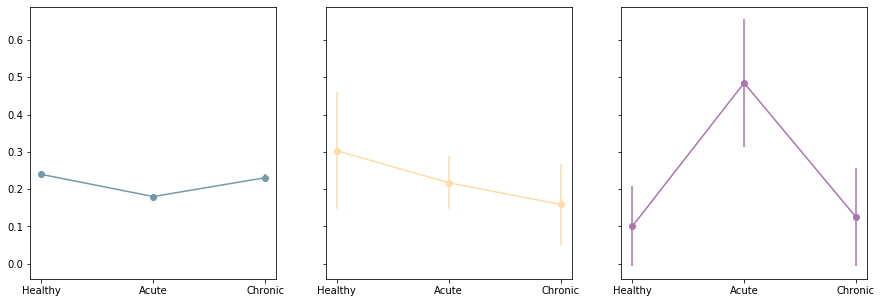

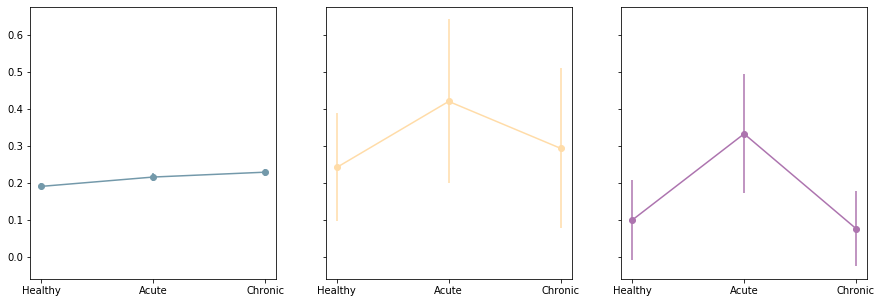

In [74]:
df.Period = df.Period.astype("category")
df.Period = df.Period.cat.reorder_categories(['Healthy', 'Acute', 'Chronic'])
df['care'] = df.meanR_mvmtOnset.astype('float')
df['care_rot'] = df.meanR_rotOnset.astype('float')

fig, ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
Colors = CP('creType')
cond = ['MSN','PV','CHI']
for idx in range(0,3):
    df2 = df[df.CellType == cond[idx]].groupby('Period').mean()
    df2['mean'] = df[df.CellType == cond[idx]].groupby('Period').care.mean()
    df2['std']  = df[df.CellType == cond[idx]].groupby('Period').care.std()
    df2['count']  = df[df.CellType == cond[idx]].groupby('Period').meanR_mvmtOnset.count()
    df2['SEM'] = df2.apply(lambda x: 1.96*np.sqrt(x['mean']*(1-x['mean'])/x['count']),axis=1)
    df2 = df2.reset_index()
    ax[idx].errorbar(df2.Period, df2['mean'], yerr=df2.SEM, fmt='-o', color = Colors[cond[idx]])
#     print(df2)
    del df2
# fig.savefig(figFolder+'figure3d_mvmt.svg',transparent=True)

fig, ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
Colors = CP('creType')
cond = ['MSN','PV','CHI']
for idx in range(0,3):
    df2 = df[df.CellType == cond[idx]].groupby('Period').mean()
    df2['mean'] = df[df.CellType == cond[idx]].groupby('Period').care_rot.mean()
    df2['std']  = df[df.CellType == cond[idx]].groupby('Period').care_rot.std()
    df2['count']  = df[df.CellType == cond[idx]].groupby('Period').meanR_rotOnset.count()
    df2['SEM'] = df2.apply(lambda x: 1.96*np.sqrt(x['mean']*(1-x['mean'])/x['count']),axis=1)
    df2 = df2.reset_index()
    ax[idx].errorbar(df2.Period, df2['mean'], yerr=df2.SEM, fmt='-o', color = Colors[cond[idx]])
#     print(df2)
    del df2
# fig.savefig(figFolder+'figure3d_rot.svg',transparent=True)


In [75]:
# %matplotlib notebook
N = 2
df4 = pd.DataFrame(columns = ['mvmt','CellType','Period','oddsRatio','pValue_corrected'])
for sig in ['care','care_rot']:
    for cell in df.CellType.unique():
        df3 = df[(df.CellType ==cell)]
        dfHealthy = df3[df3.Period == 'Healthy']
        yesVals = []
        noValse = []
        for period in df3.Period.unique():
            dfComp = df3[df3.Period == period]
            print(sig,cell,period)
            oddsratio, pvalue = sci.stats.fisher_exact([[dfHealthy[dfHealthy[sig] == True][sig].count(), dfHealthy[dfHealthy[sig] == False][sig].count()], [dfComp[dfComp[sig] == True][sig].count(), dfComp[dfComp[sig] == False][sig].count()]])
            print(pvalue, pvalue<0.05/(N))
            df4 = df4.append({'mvmt':sig,'CellType':cell,
                              'Period':period,'oddsRatio':oddsratio,
                              'pValue_corrected':pvalue*(N-1),
                              'healthy_all':dfHealthy[sig].count(),
                              'healthy_care':dfHealthy[dfHealthy[sig] == True][sig].count(),
                              'healthy_ratio':dfHealthy[dfHealthy[sig] == True][sig].count()/dfHealthy[sig].count(),
                              'period_all':dfComp[sig].count(),'period_care':dfComp[dfComp[sig] == True][sig].count(),
                              'period_ratio':dfComp[dfComp[sig] == True][sig].count()/dfComp[sig].count()},ignore_index = True)

# df4.to_csv(figFolder+'supplemntalTable1.csv')


care CHI Healthy
1.0 False
care CHI Acute
0.0010008346621033512 True
care CHI Chronic
1.0 False
care MSN Healthy
1.0 False
care MSN Acute
1.4812299606987711e-27 True
care MSN Chronic
0.1638933065719928 False
care PV Healthy
1.0 False
care PV Acute
0.35726343839147673 False
care PV Chronic
0.16870478618968815 False
care_rot CHI Healthy
1.0 False
care_rot CHI Acute
0.03492983154605499 False
care_rot CHI Chronic
1.0 False
care_rot MSN Healthy
1.0 False
care_rot MSN Acute
0.00013363359577867414 True
care_rot MSN Chronic
1.042013294620393e-09 True
care_rot PV Healthy
1.0 False
care_rot PV Acute
0.22027883555491456 False
care_rot PV Chronic
0.7413358398896259 False


In [58]:
# %matplotlib notebook
N = 2
df4 = pd.DataFrame(columns = ['mvmt','CellType','Period','oddsRatio','pValue_corrected'])
for sig in ['care','care_rot']:
    for cell in df.CellType.unique():
        df3 = df[(df.CellType ==cell)]
        dfHealthy = df3[df3.Period == 'Healthy']
        yesVals = []
        noValse = []
        for period in df3.Period.unique():
            dfComp = df3[df3.Period == period]
            print(sig,cell,period)
            oddsratio, pvalue = sci.stats.fisher_exact([[dfHealthy[dfHealthy[sig] == True][sig].count(), dfHealthy[dfHealthy[sig] == False][sig].count()], [dfComp[dfComp[sig] == True][sig].count(), dfComp[dfComp[sig] == False][sig].count()]])
            print(pvalue, pvalue<0.05/(N))
            df4 = df4.append({'mvmt':sig,'CellType':cell,
                              'Period':period,'oddsRatio':oddsratio,
                              'pValue_corrected':pvalue*(N-1),
                              'healthy_all':dfHealthy[sig].count(),
                              'healthy_care':dfHealthy[dfHealthy[sig] == True][sig].count(),
                              'healthy_ratio':dfHealthy[dfHealthy[sig] == True][sig].count()/dfHealthy[sig].count(),
                              'period_all':dfComp[sig].count(),'period_care':dfComp[dfComp[sig] == True][sig].count(),
                              'period_ratio':dfComp[dfComp[sig] == True][sig].count()/dfComp[sig].count()},ignore_index = True)

# df4.to_csv(figFolder+'supplemntalTable1.csv')


care CHI Healthy
1.0 False
care CHI Acute
0.0021947602986335584 True
care CHI Chronic
1.0 False
care MSN Healthy
1.0 False
care MSN Acute
5.137863557405102e-29 True
care MSN Chronic
0.1541418925432959 False
care PV Healthy
1.0 False
care PV Acute
0.2539798467547654 False
care PV Chronic
0.16870478618968815 False
care_rot CHI Healthy
1.0 False
care_rot CHI Acute
0.03492983154605499 False
care_rot CHI Chronic
1.0 False
care_rot MSN Healthy
1.0 False
care_rot MSN Acute
0.00014535813328958466 True
care_rot MSN Chronic
6.62521141580569e-10 True
care_rot PV Healthy
1.0 False
care_rot PV Acute
0.22027883555491456 False
care_rot PV Chronic
0.7413358398896259 False


In [76]:
f = h5py.File('membership2.hdf5','r')
miceList = getMiceList(Files[1])
col_names = ['Sess','Mouse','Period','Day','CellType']
df = pd.DataFrame(columns=col_names)
for m in miceList:
    grp = f[m]
    sessions = list(grp.keys())
    for sess in sessions:
        try:
            care_ipsi = grp[sess]['ipsiOnset']['result'].value
        except:
            print(sess,'mvmt')
            care_ipsi = np.nan
            
        try:
            care_contra = grp[sess]['contraOnset']['result'].value
        except:
            print(sess,'rot')
            care_contra = np.nan
        
        if sess[5] == 'B':
                day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        cre = getCreType(Files[1],m)
        nRed = getNumRed(Files[1],m,sess[5:])
        try:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'care_ipsi':care_ipsi,
                                'care_contra':care_contra})
        except:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'care_ipsi':care_ipsi,
                                'care_contra':care_contra},index = [0])
        df2.loc[:nRed-1,'CellType'] = cre
        df = pd.concat([df,df2],sort=True)

<ipython-input-76-9646fe6f6f2a>:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  care_ipsi = grp[sess]['ipsiOnset']['result'].value
<ipython-input-76-9646fe6f6f2a>:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  care_contra = grp[sess]['contraOnset']['result'].value


0761_day10 rot
0761_day12 rot
0761_day14A rot
0761_day19L rot
0761_day2 rot
0761_day31A rot
0761_day6 rot
0761_day8 rot
1208_BaselineL rot
1208_day12 rot
1208_day14 rot
1208_day15A rot
1208_day19L rot
1208_day2 rot
1208_day30A rot
1208_day34L rot
1208_day6 rot
1208_day8 rot
1222_day11 mvmt
1222_day20L mvmt
1222_day36L rot
1222_day5 mvmt
1231_BaselineL mvmt
1231_BaselineS mvmt
1236_day13 rot
1793_day12 rot
1793_day14 rot
1793_day34L mvmt
2976_BaselineA mvmt
2976_day10 rot
2976_day14 rot
2976_day19L rot
2976_day8 mvmt
2976_day8 rot
2980_day15A mvmt
2980_day19L rot
2980_day6 rot
2981_day10 mvmt
2981_day12 mvmt
2981_day15A mvmt
2981_day2 mvmt
2981_day4 mvmt
2981_day6 mvmt
2981_day8 mvmt
4539_BaselineA mvmt
4539_day1 mvmt
4539_day1 rot
4539_day10 mvmt
4539_day10 rot
4539_day11 mvmt
4539_day11 rot
4539_day12 mvmt
4539_day12 rot
4539_day13 mvmt
4539_day13 rot
4539_day14 mvmt
4539_day14 rot
4539_day2 mvmt
4539_day2 rot
4539_day3 mvmt
4539_day3 rot
4539_day30A mvmt
4539_day4 mvmt
4539_day4 rot


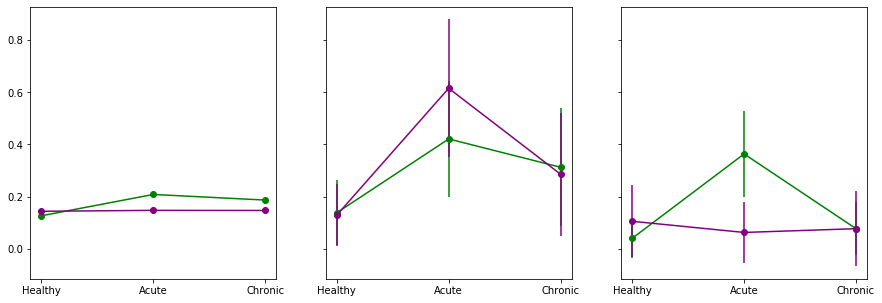

In [77]:
df.Period = df.Period.astype("category")
df.Period = df.Period.cat.reorder_categories(['Healthy', 'Acute', 'Chronic'])
df['care_ipsi'] = df.care_ipsi.astype('float')
df['care_contra'] = df.care_contra.astype('float')


fig, ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
Colors = CP('creType')
cond = ['MSN','PV','CHI']
for idx in range(0,3):
    df2 = df[df.CellType == cond[idx]].groupby('Period').mean()
    df2['mean'] = df[df.CellType == cond[idx]].groupby('Period').care_ipsi.mean()
    df2['std']  = df[df.CellType == cond[idx]].groupby('Period').care_ipsi.std()
    df2['count']  = df[df.CellType == cond[idx]].groupby('Period').care_ipsi.count()
    df2['SEM'] = df2.apply(lambda x: 1.96*np.sqrt(x['mean']*(1-x['mean'])/x['count']),axis=1)
    df2 = df2.reset_index()
    ax[idx].errorbar(df2.Period, df2['mean'], yerr=df2.SEM, fmt='-o', color = 'green')
#     print(df2)
    del df2
# fig.savefig(figFolder+'figure3d_mvmt.svg',transparent=True)

Colors = CP('creType')
cond = ['MSN','PV','CHI']
for idx in range(0,3):
    df2 = df[df.CellType == cond[idx]].groupby('Period').mean()
    df2['mean'] = df[df.CellType == cond[idx]].groupby('Period').care_contra.mean()
    df2['std']  = df[df.CellType == cond[idx]].groupby('Period').care_contra.std()
    df2['count']  = df[df.CellType == cond[idx]].groupby('Period').care_contra.count()
    df2['SEM'] = df2.apply(lambda x: 1.96*np.sqrt(x['mean']*(1-x['mean'])/x['count']),axis=1)
    df2 = df2.reset_index()
    ax[idx].errorbar(df2.Period, df2['mean'], yerr=df2.SEM, fmt='-o', color = 'purple')
#     print(df2)
    del df2
# fig.savefig(figFolder+'figure3d_rot.svg',transparent=True)


In [78]:
# %matplotlib notebook
N = 2
df4 = pd.DataFrame(columns = ['mvmt','CellType','Period','oddsRatio','pValue_corrected'])
for sig in ['care_ipsi','care_contra']:
    for cell in df.CellType.unique():
        df3 = df[(df.CellType ==cell)]
        dfHealthy = df3[df3.Period == 'Healthy']
        yesVals = []
        noValse = []
        for period in df3.Period.unique():
            dfComp = df3[df3.Period == period]
            print(sig,cell,period)
            oddsratio, pvalue = sci.stats.fisher_exact([[dfHealthy[dfHealthy[sig] == True][sig].count(), dfHealthy[dfHealthy[sig] == False][sig].count()], [dfComp[dfComp[sig] == True][sig].count(), dfComp[dfComp[sig] == False][sig].count()]])
            print(pvalue, pvalue<0.05/(N))
            df4 = df4.append({'mvmt':sig,'CellType':cell,
                              'Period':period,'oddsRatio':oddsratio,
                              'pValue_corrected':pvalue*(N-1),
                              'healthy_all':dfHealthy[sig].count(),
                              'healthy_care':dfHealthy[dfHealthy[sig] == True][sig].count(),
                              'healthy_ratio':dfHealthy[dfHealthy[sig] == True][sig].count()/dfHealthy[sig].count(),
                              'period_all':dfComp[sig].count(),'period_care':dfComp[dfComp[sig] == True][sig].count(),
                              'period_ratio':dfComp[dfComp[sig] == True][sig].count()/dfComp[sig].count()},ignore_index = True)

# df4.to_csv(figFolder+'supplemntalTable1.csv')


care_ipsi CHI Healthy
1.0 False
care_ipsi CHI Acute
0.0037945198384758357 True
care_ipsi CHI Chronic
1.0 False
care_ipsi MSN Healthy
1.0 False
care_ipsi MSN Acute
7.931391690287855e-37 True
care_ipsi MSN Chronic
8.602991518936208e-25 True
care_ipsi PV Healthy
1.0 False
care_ipsi PV Acute
0.041362854766574815 False
care_ipsi PV Chronic
0.24456471550241132 False
care_contra CHI Healthy
1.0 False
care_contra CHI Acute
1.0 False
care_contra CHI Chronic
1.0 False
care_contra MSN Healthy
1.0 False
care_contra MSN Acute
0.6066062062058726 False
care_contra MSN Chronic
0.6098536056959623 False
care_contra PV Healthy
1.0 False
care_contra PV Acute
0.0020788706465562526 True
care_contra PV Chronic
0.23145084905839627 False


In [65]:
f.close()

<h3> Figure 4 </h3>

In [42]:
# look at individual CHI/PV
f = h5py.File('J:\\connactivityAnalysis\\connMaps.hdf5','a')
numshifts = 1000
for m in tqdm(miceList):
    grp = f.create_group(m)
    data =  getData(Files[1],['trace'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess in grp.keys():
            continue
        subgrp = grp.create_group(sess)
        
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred']) 
        
        subgrp.attrs['numRed'] = numRed
        subgrp.attrs['day'] = day
        subgrp.attrs['period'] = periodCalc(day)

        try:  
            Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')            
            cor = np.dot(Ca ,Ca.T)/np.sum(Ca,axis=1) # Do the actual co-occorence matrix not np.corrcoef(Ca)
            cor2 = np.corrcoef(Ca)
            dff = data[sess]['trace']['dff']        
            cor3 = np.corrcoef(dff)

            ssubgrp = subgrp.create_group('Pre')
            ssubgrp['aSymCorr'] = cor
            ssubgrp['pearson'] = cor2
            ssubgrp['pearsonF'] = cor3

            sCor = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor2 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor3 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            for s in range(0,numshifts):
                shifts = np.random.randint(size= Ca.shape[0],low=0,high=Ca.shape[1])
                Ca2 = circShiftRoll(shifts,Ca)
                dff2 = circShiftRoll(shifts,dff)
                sCor2[:,:,s] = np.corrcoef(Ca2)
                sCor[:,:,s] = np.dot(Ca2 ,Ca2.T)/np.sum(Ca2,axis=1)
                sCor3[:,:,s] = np.corrcoef(dff2)
            ssubgrp['aSymCorr_shuffle'] = sCor
            ssubgrp['pearson_shuffle'] = sCor2
            ssubgrp['pearsonF_shuffle'] = sCor3
            del sCor
            del sCor2
            del sCor3
        except:
            print(sess)
f.close()

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [2:55:35<00:00, 658.45s/it]


In [67]:
# add Jacakard
f = h5py.File('J:\\connactivityAnalysis\\connMaps.hdf5','a')
numshifts = 1000
for m in tqdm(miceList):
    grp = f[m]
    data =  getData(Files[1],['trace'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        subgrp = grp[sess]
        
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred']) 
        
        subgrp.attrs['numRed'] = numRed
        subgrp.attrs['day'] = day
        subgrp.attrs['period'] = periodCalc(day)

        try:  
            Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')     
            Ca = Ca[np.sum(Ca,axis=1)>0,:]
            both = np.dot(Ca ,Ca.T) # Do the actual co-occorence matrix not np.corrcoef(Ca)
            x2,y2 = np.meshgrid(np.sum(Ca,axis=1), np.sum(Ca,axis=1))
            either = x2+y2-both
            cor = both/either
            cor[np.isinf(cor)] = 1
            ssubgrp = subgrp['Pre']
            del ssubgrp['Jaccard'] 
            ssubgrp['Jaccard'] = cor

            sCor = np.empty((cor.shape[0],cor.shape[1],numshifts))
            for s in range(0,numshifts):
                shifts = np.random.randint(size= Ca.shape[0],low=0,high=Ca.shape[1])
                Ca2 = circShiftRoll(shifts,Ca)
                both = np.dot(Ca2 ,Ca2.T) # Do the actual co-occorence matrix not np.corrcoef(Ca)
                x2,y2 = np.meshgrid(np.sum(Ca2,axis=1), np.sum(Ca2,axis=1))
                either = x2+y2-both
                cor = both/either
                cor[np.isinf(cor)] = 1
                sCor[:,:,s] = cor
                
                
            del ssubgrp['Jaccard_shuffle'] 
            ssubgrp['Jaccard_shuffle'] = sCor
            
            del sCor
        except:
            print(sess)
f.close()

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]D:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


cleaning up trace data



 21%|█████████████████▊                                                                 | 3/14 [00:05<00:20,  1.84s/it]

0761_day1



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [50:11<00:00, 188.19s/it]


In [358]:
df

Day Mouse   Period            Sess  aSymCorr  aSymCorrNotSig  aSymCorrSig  \
0   0  0761  Healthy  0761_BaselineA  0.014467        0.008807     0.155963   
0   0  0761  Healthy  0761_BaselineA  0.015677        0.002778     0.223489   
0   0  0761  Healthy  0761_BaselineL  0.055461        0.003509     0.271930   
0   0  0761  Healthy  0761_BaselineL  0.029843        0.006570     0.280998   
0   0  0761  Healthy  0761_BaselineS  0.032366        0.014137     0.087054   
0   0  0761  Healthy  0761_BaselineS  0.058873        0.010970     0.284222   
0   1  0761    Acute       0761_day1       NaN             NaN          NaN   
0  10  0761    Acute      0761_day10  0.021418        0.009193     0.137555   
0  10  0761    Acute      0761_day10  0.038055        0.009072     0.278832   
0  12  0761    Acute      0761_day12  0.000000        0.000000          NaN   
0  14  0761  Chronic     0761_day14A  0.185185        0.000000     0.277778   
0  19  0761  Chronic     0761_day19L  0.092593        0.092593          NaN   
0  19  0761  Chronic     0761_day19L  0.024055        0.009263     0.216356   
0  19  0761  Chronic     0761_day19L  0.007351        0.003780     0.189494   
0   2  0761    Acute       0761_day2  0.000000        0.000000          NaN   
0  31  0761  Chronic     0761_day31A  0.079062        0.023690     0.236932   
0  35  0761  Chronic     0761_day35L  0.000000        0.000000          NaN   
0  35  0761  Chronic     0761_day35L  0.027088        0.003205     0.182324   
0  35  0761  Chronic     0761_day35L  0.073526        0.007073     0.322727   
0   4  0761    Acute       0761_day4       NaN             NaN          NaN   
0   4  0761    Acute       0761_day4  0.016627        0.001013     0.163399   
0   6  0761    Acute       0761_day6  0.019048        0.000000     0.266667   
0   6  0761    Acute       0761_day6  0.003492        0.000000     0.078571   
0   8  0761    Acute       0761_day8  0.043590        0.000000     0.217949   
0   8  0761    Acute       0761_day8  0.055630        0.006221     0.247620   
0   0  1208  Healthy  1208_BaselineA  0.041328        0.021637     0.196397   
0   0  1208  Healthy  1208_BaselineL  0.000000        0.000000          NaN   
0   0  1208  Healthy  1208_BaselineL  0.053565        0.011259     0.260481   
0   0  1208  Healthy  1208_BaselineL  0.038455        0.022581     0.184392   

  numred population  sASymCorr  sigPercent  
0      1    MSN-CHI   0.010412    0.038462  
0      1    MSN-MSN   0.011794    0.058442  
0      1    MSN-CHI   0.007324    0.193548  
0      1    MSN-MSN   0.011408    0.084806  
0      1    MSN-CHI   0.008930    0.250000  
0      1    MSN-MSN   0.009206    0.175309  
0      0    MSN-MSN        NaN         NaN  
0      1    MSN-CHI   0.015687    0.095238  
0      1    MSN-MSN   0.012427    0.107438  
0      0    MSN-MSN   0.006311    0.000000  
0      0    MSN-MSN   0.005577    0.666667  
0      3    CHI-CHI   0.009249    0.000000  
0      3    MSN-CHI   0.014200    0.071429  
0      3    MSN-MSN   0.018815    0.019231  
0      0    MSN-MSN   0.005525    0.000000  
0      0    MSN-MSN   0.023231    0.259669  
0      2    CHI-CHI   0.005765    0.000000  
0      2    MSN-CHI   0.008571    0.133333  
0      2    MSN-MSN   0.011751    0.210526  
0      1    MSN-CHI        NaN         NaN  
0      1    MSN-MSN   0.003598    0.096154  
0      1    MSN-CHI   0.002298    0.071429  
0      1    MSN-MSN   0.004274    0.044444  
0      1    MSN-CHI   0.004803    0.200000  
0      1    MSN-MSN   0.006630    0.204678  
0      0    MSN-MSN   0.019938    0.112675  
0      2    CHI-CHI   0.003140    0.000000  
0      2    MSN-CHI   0.013315    0.169753  
0      2    MSN-MSN   0.023316    0.098100

In [9]:
# only run once... Also, only Asymm 
f = h5py.File('J:\\connactivityAnalysis\\connMaps.hdf5','r')
col_names = ['Mouse','Sess','Day','numred','Period','population','aSymCorr','sASymCorr']
df3 = pd.DataFrame(columns = ['Mouse','Sess','Day','numred','Period','population','mvmt','values'])
df = pd.DataFrame(columns = col_names)
for m in tqdm(f.keys()):
    for sess in f[m].keys():
        try:
            numred = f[m][sess].attrs['numRed']
            cre = getCreType(Files[1],m)
            tempDict = {'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
                                'numred':numred,'Period':periodCalc(f[m][sess].attrs['day'])}

            c = f[m][sess]['Pre']['Jaccard2'].value 
            c[(np.tril(np.ones(c.shape),-1))==0] = np.nan

            d = f[m][sess]['Pre'][('Jaccard2_shuffle')].value
            b = np.nanpercentile(d,[97.5,2.5],axis=2)

            d = np.nanmean(d,axis=2)
            d[np.tril(np.ones(d.shape),-1)==0] = np.nan

            nSig = (c>b[0,:,:])|(c<b[1,:,:])
            cSig = np.copy(c)
            cSig[~nSig] = np.nan
            noSig = np.copy(c)
            noSig[nSig] = np.nan

            if numred > 1:
                tempDict['population'] = cre+'-'+cre
                tempDict['aSymCorr'] = np.nanmean(c[:numred,:numred])
                tempDict['sASymCorr'] = np.nanmean(d[:numred,:numred])
                tempDict['aSymCorrSig'] = np.nanmean(cSig[:numred,:numred])
                tempDict['aSymCorrNotSig'] = np.nanmean(noSig[:numred,:numred])
                tempDict['sigPercent'] = np.nansum(nSig[:numred,:numred]==1)/np.nansum(np.isnan(c[:numred,:numred])==0)
                df2 = pd.DataFrame([tempDict])
                df = pd.concat([df,df2],sort=True)
            if numred > 0:
                tempDict['population'] = 'MSN-'+cre
                tempDict['aSymCorr'] = np.nanmean(c[numred:,:numred])
                tempDict['sASymCorr'] = np.nanmean(d[numred:,:numred])
                tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,:numred])
                tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,:numred])
                tempDict['sigPercent'] = np.nansum(nSig[numred:,:numred]==1)/np.nansum(np.isnan(c[numred:,:numred])==0)
                
                df2 = pd.DataFrame([tempDict])
                df = pd.concat([df,df2],sort=True)
#                 hi,bi = np.histogram(c[numred:,:numred],np.arange(-1,1,0.01))
#                 hi2,bi2 = np.histogram(cSig[numred:,:numred],np.arange(-1,1,0.01))
#                 df3 = df3.append({'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
#                                 'numred':numred,'Period':periodCalc(f[m][sess].attrs['day']),
#                                   'population':'MSN-'+cre,'mvmt':'all','values':hi,'values_sig':hi2},ignore_index=True)


            tempDict['population'] = 'MSN-MSN'
            tempDict['aSymCorr'] = np.nanmean(c[numred:,numred:])
            tempDict['sASymCorr'] = np.nanmean(d[numred:,numred:])
            tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,numred:])
            tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,numred:])
            tempDict['sigPercent'] = np.nansum(nSig[numred:,numred:]==1)/np.nansum(np.isnan(c[numred:,numred:])==0)
            df2 = pd.DataFrame([tempDict])
            df = pd.concat([df,df2],sort=True)
#             hi,bi = np.histogram(c[numred:,numred:],np.arange(-1,1,0.01))
#             hi2,bi2 = np.histogram(cSig[numred:,numred:],np.arange(-1,1,0.01))
#             df3 = df3.append({'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
#                             'numred':numred,'Period':periodCalc(f[m][sess].attrs['day']),
#                               'population':'MSN-MSN','mvmt':'all','values':hi,'values_sig':hi2},ignore_index=True)

        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,  exc_tb.tb_lineno,c.shape)
f.close()
df.to_csv(figFolder+'bySessCompareCorr2Sig3_J2.csv')
# df3.to_csv(figFolder+'bySessCompareCorr2Sig_hists.csv')

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]<ipython-input-9-aacce99ba941>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  c = f[m][sess]['Pre']['Jaccard2'].value
<ipython-input-9-aacce99ba941>:17: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  d = f[m][sess]['Pre'][('Jaccard2_shuffle')].value
<ipython-input-9-aacce99ba941>:58: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,numred:])
<ipython-input-9-aacce99ba941>:33: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorrSig'] = np.nanmean(cSig[:numred,:numred])
<ipython-input-9-aacce99ba941>:42: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,:numred])
  6%|█████▏                                                                             | 1/16 [00:00<00:04,  3.65it/s]

0761_day1 17 (0, 0)


<ipython-input-9-aacce99ba941>:34: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorrNotSig'] = np.nanmean(noSig[:numred,:numred])
 12%|██████████▍                                                                        | 2/16 [00:37<02:39, 11.38s/it]<ipython-input-9-aacce99ba941>:56: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorr'] = np.nanmean(c[numred:,numred:])
<ipython-input-9-aacce99ba941>:57: RuntimeWarning: Mean of empty slice
  tempDict['sASymCorr'] = np.nanmean(d[numred:,numred:])
<ipython-input-9-aacce99ba941>:59: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,numred:])
<ipython-input-9-aacce99ba941>:60: RuntimeWarning: invalid value encountered in long_scalars
  tempDict['sigPercent'] = np.nansum(nSig[numred:,numred:]==1)/np.nansum(np.isnan(c[numred:,numred:])==0)
 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [06:26<04:27, 66.97s/it]<ipython-input-9-aacce99ba941>:40:

<ipython-input-13-23abfbd48e3b>:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  c = f[m][sess]['Pre']['Jaccard'].value
<ipython-input-13-23abfbd48e3b>:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  d = f[m][sess]['Pre'][('Jaccard_shuffle')].value
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-13-23abfbd48e3b>:14: RuntimeWarning: Mean of empty slice
  d = np.nanmean(d,axis=2)
D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


0.01616161616161616


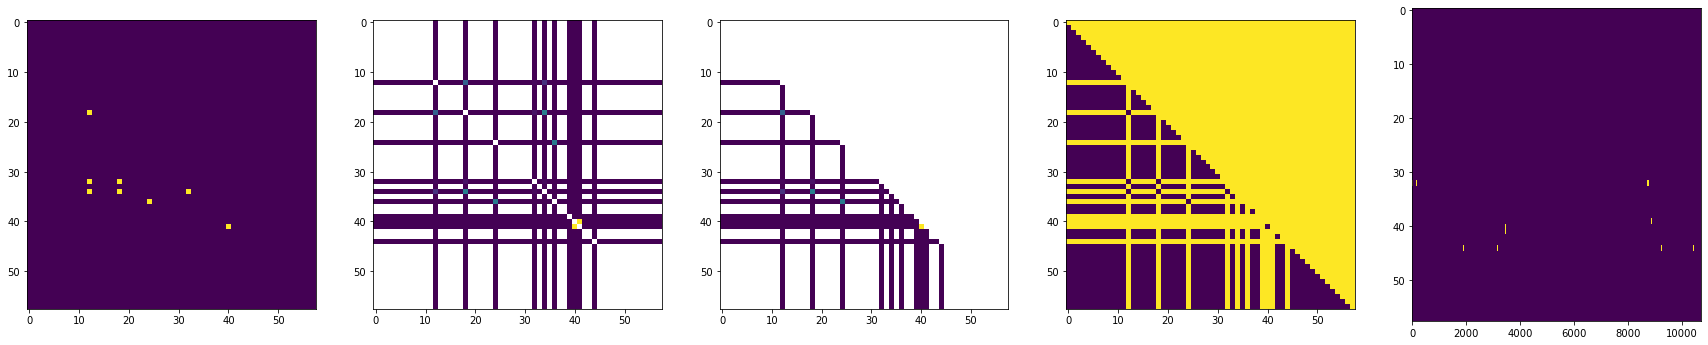

In [13]:
fig, ax = plt.subplots(1,5,figsize=(30,30))
f = h5py.File('J:\\connactivityAnalysis\\connMaps.hdf5','r')
m = '8815'
sess = '8815_day6'
c = f[m][sess]['Pre']['Jaccard'].value 
ax[1].imshow(c)
c[(np.tril(np.ones(c.shape),-1))==0] = np.nan
ax[2].imshow(c)
ax[3].imshow((np.tril(c,-1))==0)

d = f[m][sess]['Pre'][('Jaccard_shuffle')].value
b = np.nanpercentile(d,[97.5,2.5],axis=2)

d = np.nanmean(d,axis=2)
d[np.tril(np.ones(d.shape),-1)==0] = np.nan

nSig = (c>b[0,:,:])|(c<b[1,:,:])
Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')  

ax[0].imshow(nSig)
ax[1].imshow(c)
ax[4].imshow(Ca,aspect=200)
print(np.nansum(nSig[numred:,numred:]==1)/np.nansum(np.isnan(c[numred:,numred:])==0))

2980_BaselineS (169,)
(148, 148)
2980_day30A (133,)
(102, 102)


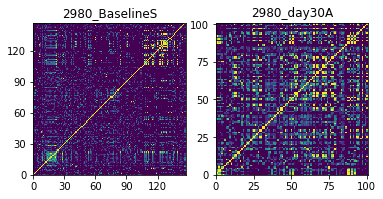

In [62]:
from matplotlib.ticker import MaxNLocator
m = '2980'
sessions = ['2980_BaselineS','2980_day30A']
f = h5py.File('J:\\connactivityAnalysis\\connMaps2.hdf5','r')
ind = 0
fig, ax = plt.subplots(1,2)
for sess in sessions:    
    if f[m][sess].attrs['day'] in [0,30,31,32,34,35,36]:
        c = f[m][sess]['Pre']['aSymCorr'].value 
        a = ~np.isnan(c).all(axis=0)
        print(sess,a.shape)
        c = c[a,:][:,a]
        print(c.shape)
#         print(sess,c.shape)
#         c = c[~np.isnan(c).all(axis=0)]
# #         c = c[~np.isnan(c).any(axis=0)]
#         print(sess,c.shape)
        ax[ind].set_aspect('equal', adjustable='box')
        CS = ax[ind].pcolormesh(np.arange(c.shape[0]),np.arange(c.shape[0]),c.T,
                                vmax=.4, vmin = 0,rasterized = True)
        ax[ind].set_title(sess)
        ax[ind].set_aspect('equal', adjustable='box')
        ax[ind].yaxis.set_major_locator(MaxNLocator(5))
        ax[ind].xaxis.set_major_locator(MaxNLocator(5))
        ind = ind+1
f.close()
# fig.colorbar(CS)
fig.savefig(figFolder+'figure4_example_nocolorBar.svg',transparent=True)

In [11]:
# df = pd.read_csv(figFolder+ 'bySessCompareCorr2Sig2.csv')
df

Day Mouse   Period            Sess  aSymCorr  aSymCorrNotSig  aSymCorrSig  \
0    0  0761  Healthy  0761_BaselineA  0.005896        0.093407     0.002396   
0    0  0761  Healthy  0761_BaselineA  0.003902        0.093561     0.000955   
0    0  0761  Healthy  0761_BaselineL  0.022272        0.125791     0.002364   
0    0  0761  Healthy  0761_BaselineL  0.012926        0.125656     0.001169   
0    0  0761  Healthy  0761_BaselineS  0.019897        0.062811     0.007882   
..  ..   ...      ...             ...       ...             ...          ...   
0    6  8815    Acute       8815_day6  0.000000             NaN     0.000000   
0    6  8815    Acute       8815_day6  0.009813        0.594909     0.000000   
0    8  8815    Acute       8815_day8  0.000000             NaN     0.000000   
0    8  8815    Acute       8815_day8       inf             inf     0.000055   
0    8  8815    Acute       8815_day8       inf             inf     0.000822   

   numred population  sASymCorr  sigPercent  
0       1    MSN-CHI   0.002028    0.038462  
0       1    MSN-MSN   0.001141    0.031818  
0       1    MSN-CHI   0.001646    0.161290  
0       1    MSN-MSN   0.001356    0.094444  
0       1    MSN-CHI   0.003354    0.218750  
..    ...        ...        ...         ...  
0       4    MSN-CHI   0.000000    0.000000  
0       4    MSN-MSN   0.000179    0.016495  
0       3    CHI-CHI   0.000000    0.000000  
0       3    MSN-CHI   0.000279    0.058511  
0       3    MSN-MSN        inf    0.027541  

[423 rows x 11 columns]

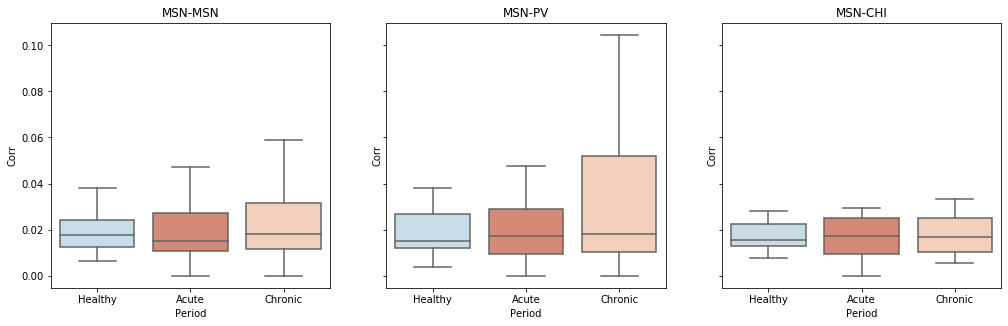

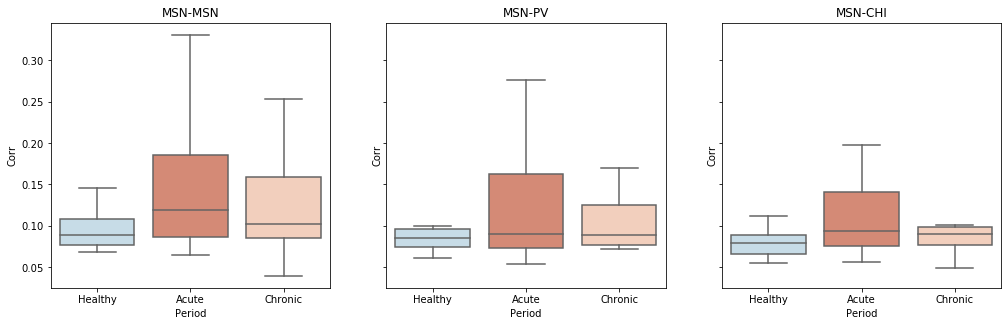

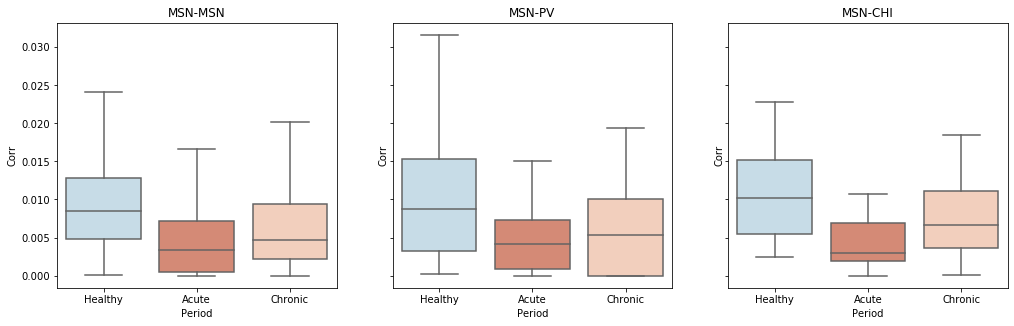

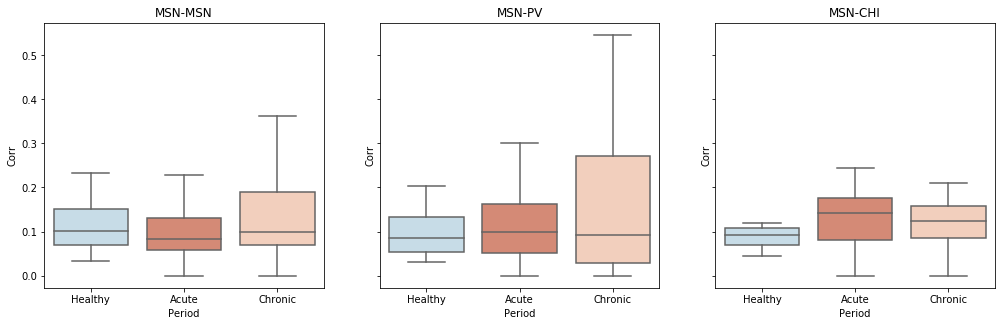

In [70]:
df = pd.read_csv(figFolder+ 'bySessCompareCorr2Sig3.csv')

df2 = df.melt(id_vars = ['Mouse','Period','population'],value_vars=["aSymCorr","aSymCorrSig",'aSymCorrNotSig',"sigPercent"],
                         var_name='varType', value_name='Corr')#.groupby(['Period','Sess','population','varType']).mean()
df2.reset_index(inplace=True)
pOrder = ['Healthy', 'Acute', 'Chronic']

for col in ["aSymCorr","aSymCorrSig",'aSymCorrNotSig',"sigPercent"]:
    fig, ax = plt.subplots(1,3,figsize=(17.04,4.88), sharey=True)
    with sns.color_palette(colorPallet3):
        g = sns.boxplot(x="Period", y="Corr", ax = ax[0], data=df2[(df2.population=='MSN-MSN')&(df2.varType==col)],
                        order = pOrder, showfliers = False)
        ax[0].set_title('MSN-MSN')
        g = sns.boxplot(x="Period", y="Corr", ax = ax[1], data=df2[(df2.population=='MSN-PV')&(df2.varType==col)],
                        order =  pOrder, showfliers = False)
        ax[1].set_title('MSN-PV')
        g = sns.boxplot(x="Period", y="Corr", ax = ax[2], data=df2[(df2.population=='MSN-CHI')&(df2.varType==col)],
                        order =  pOrder, showfliers = False)
        ax[2].set_title('MSN-CHI')
    #g = sns.boxplot(x="Period", y="Corr", hue="varType", data=df2[(df2.population=='MSN-MSN')&(df2.varType=='personF')], order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'])
#     ax[0].set_ylim(-0.01,0.25)
    fig.savefig(figFolder+'figure4a_3_'+col+'.svg',transparent=True)


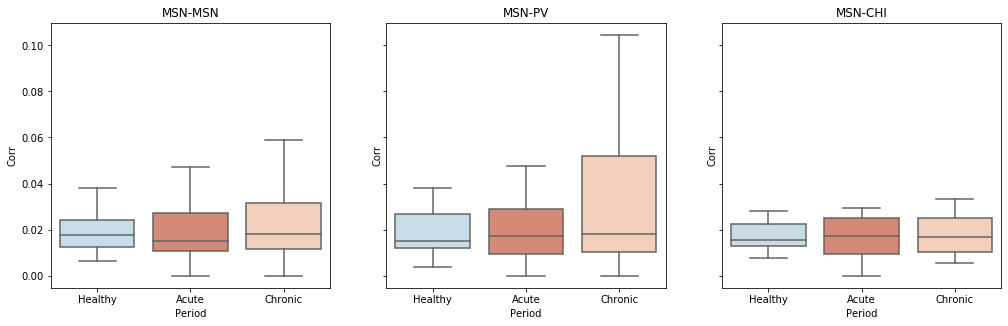

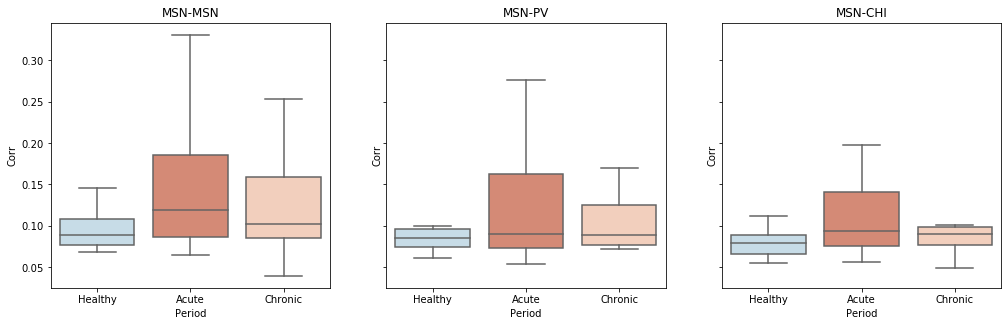

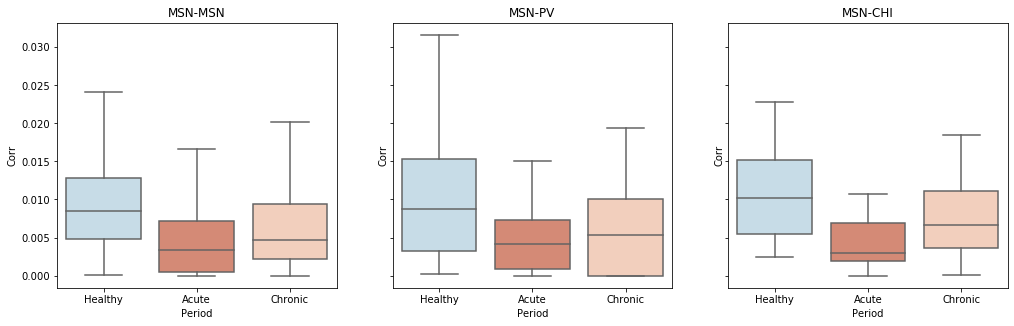

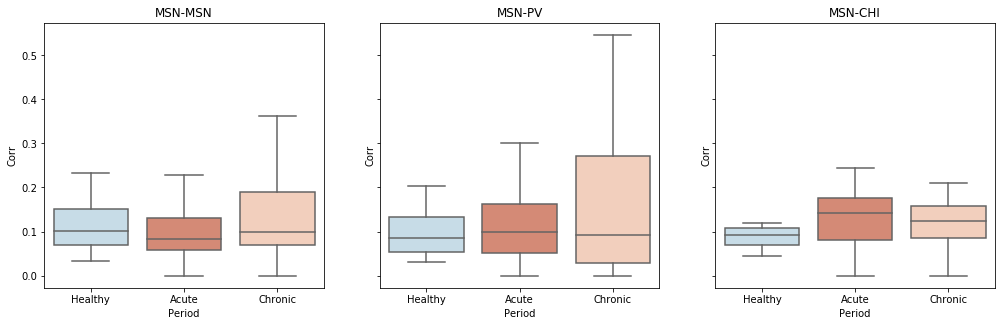

In [70]:
df = pd.read_csv(figFolder+ 'bySessCompareCorr2Sig3.csv')

df2 = df.melt(id_vars = ['Mouse','Period','population'],value_vars=["aSymCorr","aSymCorrSig",'aSymCorrNotSig',"sigPercent"],
                         var_name='varType', value_name='Corr')#.groupby(['Period','Sess','population','varType']).mean()
df2.reset_index(inplace=True)
pOrder = ['Healthy', 'Acute', 'Chronic']

for col in ["aSymCorr","aSymCorrSig",'aSymCorrNotSig',"sigPercent"]:
    fig, ax = plt.subplots(1,3,figsize=(17.04,4.88), sharey=True)
    with sns.color_palette(colorPallet3):
        g = sns.boxplot(x="Period", y="Corr", ax = ax[0], data=df2[(df2.population=='MSN-MSN')&(df2.varType==col)],
                        order = pOrder, showfliers = False)
        ax[0].set_title('MSN-MSN')
        g = sns.boxplot(x="Period", y="Corr", ax = ax[1], data=df2[(df2.population=='MSN-PV')&(df2.varType==col)],
                        order =  pOrder, showfliers = False)
        ax[1].set_title('MSN-PV')
        g = sns.boxplot(x="Period", y="Corr", ax = ax[2], data=df2[(df2.population=='MSN-CHI')&(df2.varType==col)],
                        order =  pOrder, showfliers = False)
        ax[2].set_title('MSN-CHI')
    #g = sns.boxplot(x="Period", y="Corr", hue="varType", data=df2[(df2.population=='MSN-MSN')&(df2.varType=='personF')], order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'])
#     ax[0].set_ylim(-0.01,0.25)
    fig.savefig(figFolder+'figure4a_3_'+col+'.svg',transparent=True)


In [15]:
df

Unnamed: 0  Day  Mouse   Period            Sess  aSymCorr  \
0             0    0    761  Healthy  0761_BaselineA  0.005896   
1             0    0    761  Healthy  0761_BaselineA  0.003902   
2             0    0    761  Healthy  0761_BaselineL  0.022272   
3             0    0    761  Healthy  0761_BaselineL  0.012926   
4             0    0    761  Healthy  0761_BaselineS  0.019897   
..          ...  ...    ...      ...             ...       ...   
418           0    6   8815    Acute       8815_day6  0.000000   
419           0    6   8815    Acute       8815_day6  0.009813   
420           0    8   8815    Acute       8815_day8  0.000000   
421           0    8   8815    Acute       8815_day8       inf   
422           0    8   8815    Acute       8815_day8       inf   

     aSymCorrNotSig  aSymCorrSig  numred population  sASymCorr  sigPercent  
0          0.093407     0.002396       1    MSN-CHI   0.002028    0.038462  
1          0.093561     0.000955       1    MSN-MSN   0.001141    0.031818  
2          0.125791     0.002364       1    MSN-CHI   0.001646    0.161290  
3          0.125656     0.001169       1    MSN-MSN   0.001356    0.094444  
4          0.062811     0.007882       1    MSN-CHI   0.003354    0.218750  
..              ...          ...     ...        ...        ...         ...  
418             NaN     0.000000       4    MSN-CHI   0.000000    0.000000  
419        0.594909     0.000000       4    MSN-MSN   0.000179    0.016495  
420             NaN     0.000000       3    CHI-CHI   0.000000    0.000000  
421             inf     0.000055       3    MSN-CHI   0.000279    0.058511  
422             inf     0.000822       3    MSN-MSN        inf    0.027541  

[423 rows x 12 columns]

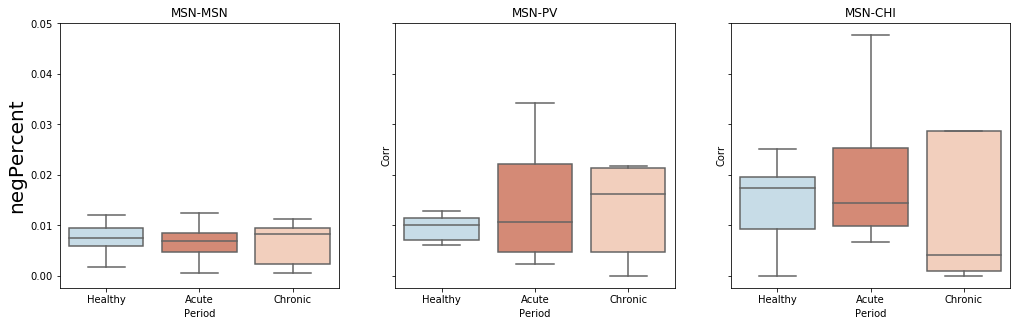

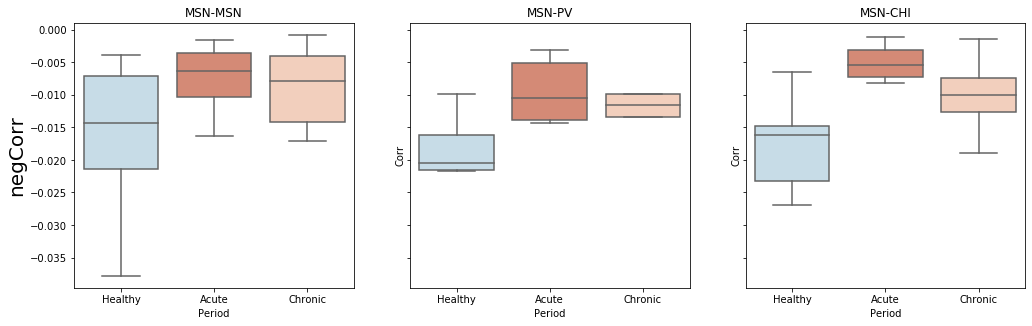

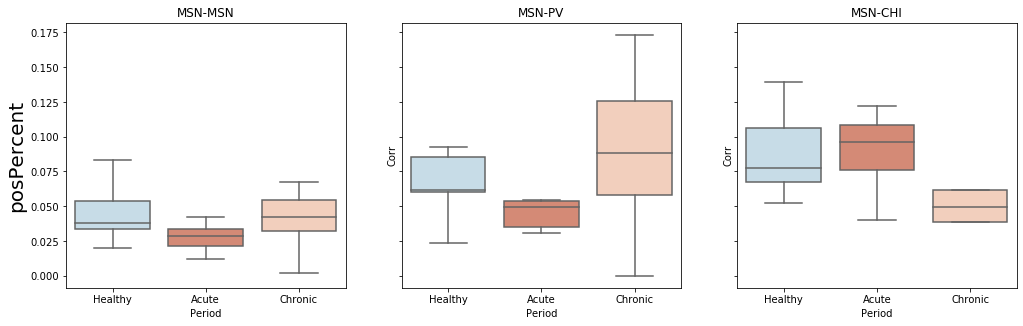

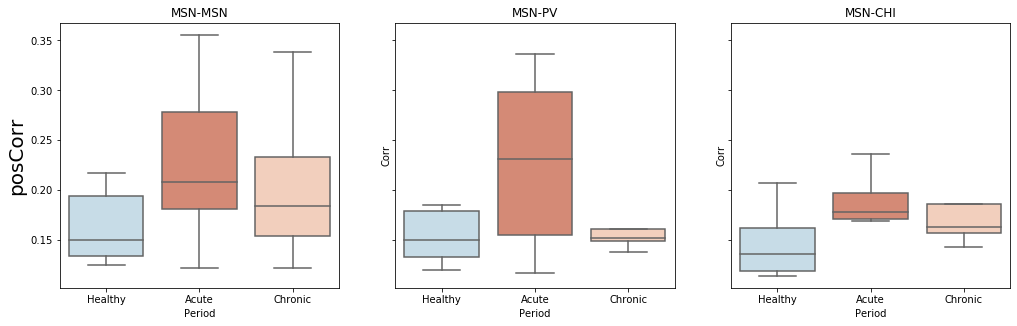

In [14]:
df = pd.read_csv(figFolder+ 'mvmtCorrSig_neg_p.csv')

df2 = df[df.mvmt=='all'].groupby(["Mouse","Period","population"]).mean().reset_index().melt(id_vars = ['Mouse','Period','population'],value_vars=["negPercent","negCorr",'posPercent',"posCorr"],
                         var_name='varType', value_name='Corr')#.groupby(['Period','Sess','population','varType']).mean()
df2.reset_index(inplace=True)
df2
pOrder = ['Healthy', 'Acute', 'Chronic']

for col in df2.varType.unique():
    fig, ax = plt.subplots(1,3,figsize=(17.04,4.88), sharey=True)
    with sns.color_palette(colorPallet3):
        g = sns.boxplot(x="Period", y="Corr", ax = ax[0], data=df2[(df2.population=='MSN-MSN')&(df2.varType==col)],
                        order = pOrder, showfliers = False)
        ax[0].set_title('MSN-MSN')
        ax[0].set_ylabel(col,fontsize=20)
        g = sns.boxplot(x="Period", y="Corr", ax = ax[1], data=df2[(df2.population=='MSN-PV')&(df2.varType==col)],
                        order =  pOrder, showfliers = False)
        ax[1].set_title('MSN-PV')
        g = sns.boxplot(x="Period", y="Corr", ax = ax[2], data=df2[(df2.population=='MSN-CHI')&(df2.varType==col)],
                        order =  pOrder, showfliers = False)
        ax[2].set_title('MSN-CHI')
    #g = sns.boxplot(x="Period", y="Corr", hue="varType", data=df2[(df2.population=='MSN-MSN')&(df2.varType=='personF')], order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'])
#     ax[0].set_ylim(-0.01,0.25)
#     fig.savefig(figFolder+'figure4a_mouse3_'+col+'.svg',transparent=True)


In [75]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
df = pd.read_csv(figFolder+ 'bySessCompareCorr2Sig3.csv')

df2 = df.groupby(["Mouse","Period","population"]).mean().reset_index().melt(id_vars = ['Mouse','Period','population'],value_vars=["aSymCorr","aSymCorrSig",'aSymCorrNotSig',"sigPercent"],
                         var_name='varType', value_name='Corr')#.groupby(['Period','Sess','population','varType']).mean()
df2.reset_index(inplace=True)
pOrder = ['Healthy', 'Acute', 'Chronic']

for col in ["aSymCorr","aSymCorrSig",'aSymCorrNotSig',"sigPercent"]:
    for pop in ['MSN-MSN','MSN-PV','MSN-CHI']:
        tdf = df2[(df2.population==pop)&(df2.varType==col)]
        S,P = sci.stats.f_oneway(list(tdf[tdf.Period=='Healthy'].Corr),
                                     list(tdf[tdf.Period=='Acute'].Corr),
                                     list(tdf[tdf.Period=='Chronic'].Corr))
        print(col,pop, P,P<0.05,S,len(tdf))
        if P<0.05:
            m_comp = pairwise_tukeyhsd(endog=tdf.dropna().Corr.astype(float), groups=tdf.dropna().Period, alpha=0.05)
            print(m_comp)


aSymCorr MSN-MSN 0.19135430202955184 False 1.7221534656497048 44
aSymCorr MSN-PV 0.6217370028248632 False 0.4906179773469087 18
aSymCorr MSN-CHI 0.7961235820060635 False 0.23204681877506877 16
aSymCorrSig MSN-MSN 0.04386596382974453 True 3.377647437572646 44
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
  Acute Chronic  -0.0142 0.8061 -0.0719 0.0436  False
  Acute Healthy  -0.0569 0.0453 -0.1128 -0.001   True
Chronic Healthy  -0.0427 0.1641 -0.0986 0.0132  False
-----------------------------------------------------
aSymCorrSig MSN-PV 0.4152397485831686 False 0.9324687576962931 18
aSymCorrSig MSN-CHI nan False nan 16
aSymCorrNotSig MSN-MSN 0.013385676953629575 True 4.80097509457555 44
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
  Acute Chronic   0.0024 0.37

In [76]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
df = pd.read_csv(figFolder+ 'bySessCompareCorr2Sig3.csv')

df2 = df.groupby(["Mouse","Period","population"]).mean().reset_index().melt(id_vars = ['Mouse','Period','population'],value_vars=["aSymCorr","aSymCorrSig",'aSymCorrNotSig',"sigPercent"],
                         var_name='varType', value_name='Corr')#.groupby(['Period','Sess','population','varType']).mean()
df2.reset_index(inplace=True)
pOrder = ['Healthy', 'Acute', 'Chronic']

for col in ["aSymCorr","aSymCorrSig",'aSymCorrNotSig',"sigPercent"]:
    for pop in ['MSN-MSN','MSN-PV','MSN-CHI']:
        tdf = df2[(df2.population==pop)&(df2.varType==col)]
        tdf = tdf.pivot('Mouse','Period','Corr').dropna().reset_index()
        S,P = sci.stats.wilcoxon(tdf.Healthy,tdf.Acute)
        if P<0.05:
            print('Healthy vs. Acute',col,pop, P,P<0.05,P*2,len(tdf))
        S,P = sci.stats.wilcoxon(tdf.Healthy,tdf.Chronic)
        if P<0.05:
            print('Healthy vs. Chronic',col,pop, P,P<0.05,P*2,len(tdf))




Healthy vs. Acute aSymCorrSig MSN-MSN 0.0107421875 True 0.021484375 14
Healthy vs. Chronic aSymCorrSig MSN-MSN 0.0418701171875 True 0.083740234375 14
Healthy vs. Acute aSymCorrNotSig MSN-MSN 0.001220703125 True 0.00244140625 14


<h3> Figure 5 </h3>

In [45]:
# Recalculate the LFP align to MSN onset - take a few days to run. 
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = 'J:\\lfp2ca_notNormalize\\'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','trace'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred'])


        if os.path.exists(savePath+'MSN\\'+sess):
            df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre,'numred':numRed},ignore_index=True)
            continue

        # get data
        Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
        dCa = np.append(Ca[:,1:]-Ca[:,:-1],np.zeros((Ca.shape[0],1)),axis=1)
        dCa[dCa==-1] = 0
        
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre,'numred':numRed,'numMsn':Ca.shape[0]},ignore_index=True)

        dtS = float(1/data[sess]['trace']['FS'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['trace']['dff'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        

        # for every Cre neuron:
        dca = dCa[0:numRed,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for creN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            cN = dca[creN,:]
            for si in ts[cN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. CRE#',creN,' in sess= ',sess)
                    continue
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"CRE\\"+sess, "wb" ), protocol=4 )
            del aligned
        
        # for every MSN neuron:
        dca = dCa[numRed:,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for msnN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            mN = dca[msnN,:]
            for si in ts[mN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. MSN#',msnN,' in sess= ',sess)
                    continue
            
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"MSN\\"+sess, "wb" ) , protocol=4)
            del aligned

df.to_csv(savePath+'sessions')


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
I deleted session: 1208_day12


 46%|█████████████████████████████████████▊                                            | 6/13 [17:14<16:54, 144.99s/it]

found  17.0  outlier points


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
found  1.0  outlier points


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [07:22<03:46, 45.33s/it]

found  888231.0  outlier points


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [09:53<05:08, 77.16s/it]

found  481139.0  outlier points


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data
I deleted session: 2976_day4
found  1.0  outlier points


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [04:43<00:20, 20.70s/it]

found  3.0  outlier points


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


 43%|███████████████████████████████████▌                                               | 6/14 [06:45<08:19, 62.50s/it]

found  50.0  outlier points


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


 21%|█████████████████▎                                                                | 4/19 [14:25<45:15, 181.03s/it]

found  29.0  outlier points


  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [07:20<00:00, 31.46s/it]


In [46]:
# Recalculate the LFP align to MSN onset - take a few days to run. 
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = 'J:\\lfp2ca_notNormalize\\Post\\'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','trace'],period ='Post', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred'])

        if sess[-1] == 'A':
            drug = 'Amph'
        elif sess[-1]=='L':
            drug  = 'L-Dopa'
        else:
            drug = 'Saline'

        if os.path.exists(savePath+'MSN\\'+sess):
            df.append({'mouse':m,'sess':sess,'day':day,'drug':drug,
                       'period': periodCalc(day),'cre':cre,'numred':numRed},ignore_index=True)
            continue

        # get data
        Ca = getOnsetOrPeriod(m,sess,'Post','caOnset_Hf')
        dCa = np.append(Ca[:,1:]-Ca[:,:-1],np.zeros((Ca.shape[0],1)),axis=1)
        dCa[dCa==-1] = 0
        
        coeff = np.abs(f[m][sess]['Post']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['trace']['FS'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['trace']['dff'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        

        # for every Cre neuron:
        dca = dCa[0:numRed,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for creN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            cN = dca[creN,:]
            for si in ts[cN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. CRE#',creN,' in sess= ',sess)
                    continue
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"CRE\\"+sess, "wb" ), protocol=4 )
            del aligned
        
        # for every MSN neuron:
        dca = dCa[numRed:,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for msnN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            mN = dca[msnN,:]
            for si in ts[mN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. MSN#',msnN,' in sess= ',sess)
                    continue
            
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"MSN\\"+sess, "wb" ) , protocol=4)
            del aligned
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'drug':drug,
                       'period': periodCalc(day),'cre':cre,'numred':numRed,'numMsn':Ca.shape[0]},ignore_index=True)

df.to_csv(savePath+'sessions')


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 0761_day1
I deleted session: 0761_day10
I deleted session: 0761_day12
I deleted session: 0761_day2
I deleted session: 0761_day4
I deleted session: 0761_day6
I deleted session: 0761_day8
cleaning up lfp data


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1208_day10
I deleted session: 1208_day12
I deleted session: 1208_day14
I deleted session: 1208_day2
I deleted session: 1208_day4
I deleted session: 1208_day6
I deleted session: 1208_day8
cleaning up lfp data


 57%|███████████████████████████████████████████████▍                                   | 4/7 [20:59<13:24, 268.08s/it]

found  3.0  outlier points


 86%|███████████████████████████████████████████████████████████████████████▏           | 6/7 [25:30<03:15, 195.80s/it]

found  2.0  outlier points


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1222_day11
I deleted session: 1222_day13
I deleted session: 1222_day2
I deleted session: 1222_day3
I deleted session: 1222_day5
I deleted session: 1222_day7
I deleted session: 1222_day9
cleaning up lfp data


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1236_day1
I deleted session: 1236_day11
I deleted session: 1236_day13
I deleted session: 1236_day3
I deleted session: 1236_day5
I deleted session: 1236_day7
I deleted session: 1236_day9
cleaning up lfp data
found  34.0  outlier points


 71%|████████████████████████████████████████████████████████████                        | 5/7 [06:24<02:32, 76.21s/it]

found  927582.0  outlier points


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [08:25<01:29, 89.71s/it]

found  447664.0  outlier points


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1793_day10
I deleted session: 1793_day12
I deleted session: 1793_day14
I deleted session: 1793_day2
I deleted session: 1793_day4
I deleted session: 1793_day6
I deleted session: 1793_day8
cleaning up lfp data


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 2976_day10
I deleted session: 2976_day12
I deleted session: 2976_day14
I deleted session: 2976_day2
I deleted session: 2976_day4
I deleted session: 2976_day6
I deleted session: 2976_day8
cleaning up lfp data


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 2980_day10
I deleted session: 2980_day12
I deleted session: 2980_day14
I deleted session: 2980_day2
I deleted session: 2980_day4
I deleted session: 2980_day6
I deleted session: 2980_day8
cleaning up lfp data


 43%|████████████████████████████████████                                                | 3/7 [05:24<06:29, 97.45s/it]

found  144.0  outlier points


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 2981_day10
I deleted session: 2981_day12
I deleted session: 2981_day14
I deleted session: 2981_day2
I deleted session: 2981_day4
I deleted session: 2981_day6
I deleted session: 2981_day8
cleaning up lfp data


 43%|████████████████████████████████████                                                | 3/7 [04:41<05:52, 88.10s/it]

found  105.0  outlier points


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 4539_day0
I deleted session: 4539_day1
I deleted session: 4539_day10
I deleted session: 4539_day11
I deleted session: 4539_day12
I deleted session: 4539_day13
I deleted session: 4539_day14
I deleted session: 4539_day2
I deleted session: 4539_day3
I deleted session: 4539_day4
I deleted session: 4539_day5
I deleted session: 4539_day6
I deleted session: 4539_day7
I deleted session: 4539_day8
I deleted session: 4539_day9
cleaning up lfp data


 50%|█████████████████████████████████████████▌                                         | 2/4 [08:39<06:29, 194.69s/it]

found  17.0  outlier points


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 7584_Baseline0
I deleted session: 7584_day0
I deleted session: 7584_day1
I deleted session: 7584_day10
I deleted session: 7584_day11
I deleted session: 7584_day12
I deleted session: 7584_day15
I deleted session: 7584_day2
I deleted session: 7584_day3
I deleted session: 7584_day4
I deleted session: 7584_day5
I deleted session: 7584_day6
I deleted session: 7584_day7
I deleted session: 7584_day8
I deleted session: 7584_day9
cleaning up lfp data


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 7909_day0
I deleted session: 7909_day1
I deleted session: 7909_day10
I deleted session: 7909_day11
I deleted session: 7909_day12
I deleted session: 7909_day13
I deleted session: 7909_day14
I deleted session: 7909_day2
I deleted session: 7909_day3
I deleted session: 7909_day4
I deleted session: 7909_day5
I deleted session: 7909_day6
I deleted session: 7909_day7
I deleted session: 7909_day8
I deleted session: 7909_day9
cleaning up lfp data
found  10.0  outlier points


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 8430_day1
I deleted session: 8430_day11
I deleted session: 8430_day3
I deleted session: 8430_day5
I deleted session: 8430_day7
I deleted session: 8430_day9
cleaning up lfp data


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day14
I deleted session: 8803_day2
I deleted session: 8803_day4
I deleted session: 8803_day5
I deleted session: 8803_day6
I deleted session: 8803_day8
cleaning up lfp data


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 8815_day10
I deleted session: 8815_day12
I deleted session: 8815_day14
I deleted session: 8815_day2
I deleted session: 8815_day4
I deleted session: 8815_day6
I deleted session: 8815_day8
cleaning up lfp data


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:39<00:00, 57.12s/it]


In [58]:
# Recalculate the LFP align to mvmt onset  
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = 'J:\\lfp2speed2\\'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','speed'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])


        # get data
        sOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset2')
        
        if np.sum(sOnset)==0:
            continue

        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['speed']['Fs'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        
        # for every speed onset:
        
        onsetL = np.full_like(tl,False)
        for si in ts[sOnset.astype(bool)]:
            ti = np.argmin(np.abs(tl-si))
            onsetL[ti] = True
        al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

        if al.ndim <3:
            try:
                al = np.reshape(al,(al.shape[0],al.shape[1],1))
            except:
                print('no onset, when there should be. in sess= ',sess)
                continue

        #al = np.nanmean(al,axis=2,keepdims=True)
        al = np.nan_to_num(al,nan=-9999)
        if 'aligned' in locals():
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al

        if np.sum(sOnset)>0:
            pickle.dump( aligned, open( savePath+sess, "wb" ) , protocol=4)
            del aligned
         
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre},ignore_index=True)

df.to_csv(savePath+'sessions')


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data


 46%|██████████████████████████████████████▎                                            | 6/13 [00:23<00:31,  4.49s/it]

found  17.0  outlier points


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [01:13<00:41,  8.23s/it]

found  888231.0  outlier points


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [01:21<00:33,  8.30s/it]

found  481139.0  outlier points


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  1.0  outlier points


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [01:29<00:07,  7.41s/it]

found  3.0  outlier points


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


 43%|███████████████████████████████████▌                                               | 6/14 [00:47<01:01,  7.72s/it]

found  50.0  outlier points


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


 21%|█████████████████▍                                                                 | 4/19 [00:29<01:52,  7.49s/it]

found  29.0  outlier points


  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:45<00:00,  7.51s/it]


In [53]:
# plot Get statistics for Gamma Power
df = pd.read_csv('J:\\lfp2ca_notNormalize\\Post\\sessions')
savePath = 'J:\\lfp2ca_notNormalize\\Post\\'
Pdf = pd.DataFrame(columns = ['Mouse','Period','Sess','CellType'])
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta_10to15':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = df[df.sess==sess].cre.values[0]
    drug = df[df.sess==sess].drug.values[0]
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType,'drug':drug}
        A = pickle.load(open(savePath+'CRE\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - CRE failed at line ",  exc_tb.tb_lineno)
            
    cellType = 'MSN'
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType,'drug':drug}
        A = pickle.load(open(savePath+'MSN\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)

Pdf.to_csv(figFolder+'statsForPowerPost.csv')

0761_BaselineL  - CRE failed at line  21
0761_day14A  - CRE failed at line  21
0761_day14A  - MSN failed at line  59
0761_day31A  - CRE failed at line  21
1208_BaselineA  - CRE failed at line  21
1208_day19L  - CRE failed at line  21
1222_BaselineA  - CRE failed at line  21
1222_BaselineL  - CRE failed at line  21
1222_BaselineS  - CRE failed at line  21
1222_day15A  - CRE failed at line  21
1222_day20L  - CRE failed at line  21
1222_day32A  - CRE failed at line  21
1222_day32A  - MSN failed at line  59
1222_day36L  - CRE failed at line  21
1236_BaselineA  - CRE failed at line  21
1236_BaselineL  - CRE failed at line  21
1236_day19L  - CRE failed at line  21
1253_BaselineA  - CRE failed at line  21
1253_BaselineS  - CRE failed at line  21
1793_BaselineA  - CRE failed at line  21
1793_day19L  - CRE failed at line  21
1793_day30A  - CRE failed at line  21
1793_day34L  - CRE failed at line  21
2976_BaselineA  - CRE failed at line  21
2976_BaselineL  - CRE failed at line  21
2976_BaselineS

In [55]:
Pdf = pd.read_csv(figFolder+'statsForPowerPost.csv')
for cell in Pdf.CellType.unique():
    dfA = Pdf[(Pdf.CellType == cell)&(Pdf.drug == 'Amph')]
    dfL = Pdf[(Pdf.CellType == cell)&(Pdf.drug == 'L-Dopa')]
    Fa,Pa = sci.stats.mannwhitneyu(dfA[dfA.Period == 'Healthy'].high_Gamma,dfA[dfA.Period == 'Chronic'].high_Gamma)
    Fl,Pl = sci.stats.mannwhitneyu(dfL[dfL.Period == 'Healthy'].high_Gamma,dfL[dfL.Period == 'Chronic'].high_Gamma)
    print(cell,' - Amphatamine: ', Pa)
    print(cell,' - L-Dopa: ', Pl)
# Pdf.dtypes

CHI  - Amphatamine:  0.5
CHI  - L-Dopa:  0.1956336396413197
MSN  - Amphatamine:  0.17026563377142767
MSN  - L-Dopa:  0.2751067774726903
PV  - Amphatamine:  0.39209561470080956
PV  - L-Dopa:  0.36183680491588155


In [59]:
def getAlignedLFP3(cellType,cre = None, mice = None, period = None, day=None, drug=None,drugPeriod='Pre'):
    # function that take in the classification and return the appropreate data:
    #Inputs:
    #   cellType - return MSN or CRE if both pass ['MNS','CRE']
    #   mice - (Optional) list of mice from to include. Default: None - will load data for all mice
    #   period - (Optional) either 'Pre' or 'Post'. difault: None - return full length of data from picked sessions
    #   day - (Optional) lambda function with logic for picking days. Default: None - ignore day attr when picking data
    #           NOTE: day will be ignored if period is specified
    #   cre - (Optional) which cre mouse is it. options:None (default), "PV", "CHI"
    #                   must have trace included in dataType list to be taken into account
    #   WinPre - (Optional) length of pre window in secounds (default 2)
    #   WinPost - (Optional) length of post window in secounds (default 2)
    #Output:
    #   data - the requested data. format: {mice_session:{dataType:data}}
    
    
    dFile = 'FinalData_6OHDA_H.h5'
    # double check parameters inputs are valid:
    if drugPeriod=='Post':
        savePath = 'J:\\lfp2ca_notNormalize\\Post\\'#'/home/dana_z/HD1/lfpAligned2Ca/Post/'
    else:
        savePath = 'J:\\lfp2ca_notNormalize\\'#'/home/dana_z/HD1/lfpAligned2Ca/Pre/'

    df = pd.read_csv(savePath+'sessions')
    
    if period == None and day != None and isinstance(day,type(lambda c:None)):
        df['keep'] = df.apply(lambda row: day(row.day), axis=1)
        df = df[(df.keep==True)]
    
    if period in ['Healthy','Acute','Chronic']:
        df = df[(df.period==period)]
       
    if cre in ['PV','CHI','NA']:
        df = df[(df.cre==cre)]
    
    if drug in ['Amph','L-Dopa','Saline','None']:
        df = df[(df.drug==drug)]
    

    if not isinstance(cellType,list):
        cellType = [cellType]
        
    cellType = list(set(cellType).intersection(set(['MSN','CRE'])))
    if len(cellType) == 0:
        raise ValueError('Not a valid cellType value. cellType must be in ["MSN","CRE"]')
    
    # traverse the hdf5 file:
    if mice == None:
        mice = getMiceList(dFile) 
    elif not isinstance(mice,list):
        mice = [mice]
    
    if not isinstance(mice[0],str):
        for m in range(0,len(mice)):
            mice[m] = str(mice[m])
    df = df[(df.mouse.isin(mice))]
    # start extracting the data:   
    
    # alllocate memory:
#    nNeurons = 0;
#    if 'MSN' in cellType:
#        nNeurons = nNeurons + int(df.numMsn.sum()) - int(df.numred.sum())
#    if 'CRE' in cellType:
#        nNeurons = nNeurons + int(df.numred.sum())
    nSess = len(df.mouse.unique())
    dResult = np.empty([12206,87,nSess],dtype=float)
    
    ind = 0
    for m in df.mouse.unique():
        dfM = df[df.mouse == m]
        indM = 0
        nSessM = len(df.sess.unique())
        nNeurons = 0
        if 'MSN' in cellType:
            nNeurons = nNeurons + int(dfM.numMsn.sum()) - int(dfM.numred.sum())
        if 'CRE' in cellType:
            nNeurons = nNeurons + int(dfM.numred.sum())
        MResult = np.empty([12206,87,nNeurons],dtype=float)
        for sess in dfM.sess.unique():
            if 'MSN' in cellType:
                try: 
                    tempD = pickle.load(open(savePath+'MSN\\'+sess,'rb'))
                except:
                    continue
                tempD[tempD==9999] = np.nan
                tempD[tempD==-9999] = np.nan
                mu = np.mean(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
                Std = np.std(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
                tempD =(tempD-mu)/Std
#                 print(indM,indM+tempD.shape[2],tempD.shape[2],MResult[:,:,indM:(indM+tempD.shape[2])].shape)
                MResult[:,:,indM:(indM+tempD.shape[2])] = tempD 
                indM = indM+tempD.shape[2]
            # for every Cre neuron:
            if 'CRE' in cellType:
                try:
                    tempD = pickle.load(open(savePath+'CRE\\'+sess,'rb'))
                except:
                    continue
                tempD[tempD==9999] = np.nan
                tempD[tempD==-9999] = np.nan
                mu = np.mean(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
                Std = np.std(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
                tempD =(tempD-mu)/Std
#                 print(indM,indM+tempD.shape[2],tempD.shape[2],MResult[:,:,indM:(indM+tempD.shape[2])].shape)
                MResult[:,:,indM:(indM+tempD.shape[2])] = tempD 
                indM = indM+tempD.shape[2]
        MResult = MResult[:,:,:indM]
        dResult[:,:,ind] = np.nanmean(MResult,axis=2)  
        ind = ind+1
        
    return dResult[:,:,:ind],df

In [63]:
def getAlignedLFP_mvmt2(savePath,cre = None, mice = None, period = None, day=None, drug=None,drugPeriod='Pre'):
    # function that take in the classification and return the appropreate data:
    #Inputs:
    #   cellType - return MSN or CRE if both pass ['MNS','CRE']
    #   mice - (Optional) list of mice from to include. Default: None - will load data for all mice
    #   period - (Optional) either 'Pre' or 'Post'. difault: None - return full length of data from picked sessions
    #   day - (Optional) lambda function with logic for picking days. Default: None - ignore day attr when picking data
    #           NOTE: day will be ignored if period is specified
    #   cre - (Optional) which cre mouse is it. options:None (default), "PV", "CHI"
    #                   must have trace included in dataType list to be taken into account
    #   WinPre - (Optional) length of pre window in secounds (default 2)
    #   WinPost - (Optional) length of post window in secounds (default 2)
    #Output:
    #   data - the requested data. format: {mice_session:{dataType:data}}
    
    
    dFile = 'FinalData_6OHDA_H.h5'
    # double check parameters inputs are valid:

    df = pd.read_csv(savePath+'sessions')
    
    if period == None and day != None and isinstance(day,type(lambda c:None)):
        df['keep'] = df.apply(lambda row: day(row.day), axis=1)
        df = df[(df.keep==True)]
    
    if period in df.period.unique():
        df = df[(df.period==period)]
       
    if cre in ['PV','CHI','NA']:
        df = df[(df.cre==cre)]
    
    if drug in ['Amph','L-Dopa','Saline','None']:
        df = df[(df.drug==drug)]
     
   
    # traverse the hdf5 file:
    if mice == None:
        mice = getMiceList(dFile) 
    elif not isinstance(mice,list):
        mice = [mice]
    
    if not isinstance(mice[0],str):
        for m in range(0,len(mice)):
            mice[m] = str(mice[m])
    df = df[(df.mouse.isin(mice))]
    # start extracting the data:   
    
    # alllocate memory:
   
    dResult = np.empty([12206,87,len(df)*50],dtype=float)
    
    ind = 0
    for m in df.mouse.unique():
        dfM = df[df.mouse == m]
        indM = 0
        nSessM = len(df.sess.unique())
        nNeurons = 0
        MResult = np.empty([12206,87,len(df)*50],dtype=float)
        for sess in dfM.sess.unique():   
            tempD = pickle.load(open(savePath+sess,'rb'))
            tempD[tempD==9999] = np.nan
            tempD[tempD==-9999] = np.nan
            mu = np.mean(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
            Std = np.std(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
            tempD =(tempD-mu)/Std
#             print(indM,indM+tempD.shape[2],tempD.shape[2],MResult[:,:,indM:(indM+tempD.shape[2])].shape)
            MResult[:,:,indM:(indM+tempD.shape[2])] = tempD 
            indM = indM+tempD.shape[2]

        MResult = MResult[:,:,:indM]
        dResult[:,:,ind] = np.nanmean(MResult,axis=2)  
        ind = ind+1

        
    return dResult[:,:,:ind],df

In [64]:
periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: day >=13}

df = pd.read_csv('J:\\lfp2ca_notNormalize\\sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in periods.keys():
    cellType = 'MSN'
    cre = None
    A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per])
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_MSN_Mouse'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)

for per in periods.keys():
    cellType = 'CRE'
    cre = 'CHI'
    A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per])
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_CHI_Mouse'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)

for per in periods.keys():
    cellType = 'CRE'
    cre = 'PV'
    A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per])
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_PV_Mouse'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)

    
    
savePath = 'J:\\lfp2speed2\\'
for per in periods.keys():
    A,df2 = getAlignedLFP_mvmt2(savePath, day =periods[per])
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_speedOnset_Mouse'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)



In [60]:
periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: day >=13}

df = pd.read_csv('J:\\lfp2ca_notNormalize\\Post\\sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
    
for per in periods.keys():
    cellType = 'MSN'
    cre = None
    A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per],drugPeriod = 'Post',drug = 'L-Dopa')
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_MSN_Mouse_post_Ldopa'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)


In [65]:
# plot Get statistics for Gamma Power
df = pd.read_csv('J:\\lfp2ca_notNormalize\\sessions')
savePath = 'J:\\lfp2ca_notNormalize\\'
Pdf = pd.DataFrame(columns = ['Mouse','Period','Sess','CellType'])
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta_10to15':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = df[df.sess==sess].cre.values[0]
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType}
        A = pickle.load(open(savePath+'CRE\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - CRE failed at line ",  exc_tb.tb_lineno)
            
    cellType = 'MSN'
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType}
        A = pickle.load(open(savePath+'MSN\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)

Pdf.to_csv(figFolder+'statsForPower.csv')

0761_day1  - CRE failed at line  20
0761_day1  - MSN failed at line  58
0761_day12  - CRE failed at line  20
0761_day14A  - CRE failed at line  20
0761_day2  - CRE failed at line  20
0761_day31A  - CRE failed at line  20
0761_day4  - CRE failed at line  20
1208_BaselineA  - CRE failed at line  20
1208_day14  - CRE failed at line  20
1208_day19L  - CRE failed at line  20
1208_day4  - CRE failed at line  20
1222_BaselineA  - CRE failed at line  20
1222_day11  - CRE failed at line  20
1222_day13  - CRE failed at line  20
1222_day2  - CRE failed at line  20
1222_day20L  - CRE failed at line  20
1222_day3  - CRE failed at line  20
1222_day32A  - CRE failed at line  20
1222_day36L  - CRE failed at line  20
1222_day5  - CRE failed at line  20
1222_day7  - CRE failed at line  20
1222_day9  - CRE failed at line  20
1236_BaselineL  - CRE failed at line  20
1236_day1  - CRE failed at line  20
1236_day19L  - CRE failed at line  20
1236_day3  - CRE failed at line  20
1236_day7  - CRE failed at line

In [66]:
# plot Get statistics for Gamma Power
df = pd.read_csv('J:\\lfp2ca_notNormalize\\Post\\sessions')
savePath = 'J:\\lfp2ca_notNormalize\\Post\\'
Pdf = pd.DataFrame(columns = ['Mouse','Period','Sess','CellType'])
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta_10to15':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = df[df.sess==sess].cre.values[0]
    drug = df[df.sess==sess].drug.values[0]
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType,'drug':drug}
        A = pickle.load(open(savePath+'CRE\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - CRE failed at line ",  exc_tb.tb_lineno)
            
    cellType = 'MSN'
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType,'drug':drug}
        A = pickle.load(open(savePath+'MSN\\'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)

Pdf.to_csv(figFolder+'statsForPowerPost.csv')

0761_BaselineL  - CRE failed at line  21
0761_day14A  - CRE failed at line  21
0761_day14A  - MSN failed at line  59
0761_day31A  - CRE failed at line  21
1208_BaselineA  - CRE failed at line  21
1208_day19L  - CRE failed at line  21
1222_BaselineA  - CRE failed at line  21
1222_BaselineL  - CRE failed at line  21
1222_BaselineS  - CRE failed at line  21
1222_day15A  - CRE failed at line  21
1222_day20L  - CRE failed at line  21
1222_day32A  - CRE failed at line  21
1222_day32A  - MSN failed at line  59
1222_day36L  - CRE failed at line  21
1236_BaselineA  - CRE failed at line  21
1236_BaselineL  - CRE failed at line  21
1236_day19L  - CRE failed at line  21
1253_BaselineA  - CRE failed at line  21
1253_BaselineS  - CRE failed at line  21
1793_BaselineA  - CRE failed at line  21
1793_day19L  - CRE failed at line  21
1793_day30A  - CRE failed at line  21
1793_day34L  - CRE failed at line  21
2976_BaselineA  - CRE failed at line  21
2976_BaselineL  - CRE failed at line  21
2976_BaselineS

In [67]:
Pdf = pd.read_csv(figFolder+'statsForPower.csv')

periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: day >=13}

df = pd.read_csv('J:\\lfp2speed2\\sessions')
savePath = 'J:\\lfp2speed2\\'
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['0761_BaselineA']['Pre']['freq'].value
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta_10to15':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = 'mvmt'
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType}#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
#     else:
        A = pickle.load(open(savePath+'/'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)

        
Pdf.to_csv(figFolder+'statsForPower.csv')

In [37]:
Pdf = pd.read_csv(figFolder+'statsForPowerPost.csv')
Pdf.head()
df2 = Pdf
df2 = df2.groupby(['Mouse','Period','CellType']).mean()
df2 = df2.reset_index()
df3 = df2
columns = ['high_Gamma','high_Beta_15to20','Beta_10to15','low_Gamma']

def nor(row,col):
    base = float(df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][col].item())
    val = float(row[col])
    if base==0:
        return None
    else: #base <0 and val >0:
        return (val-base)/np.abs(base)
#     else:
#         return (val-base)/base

for ind in range(len(columns)):
#     df2[columns[ind]+'_normalized'] = df2.apply(lambda row: (row[columns[ind]]-df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item())/df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item() if df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item() != 0 else None,axis=1)
    df3[columns[ind]] = df3.apply(lambda row: nor(row,columns[ind]) ,axis=1)

# df2[df2.CellType=='PV']

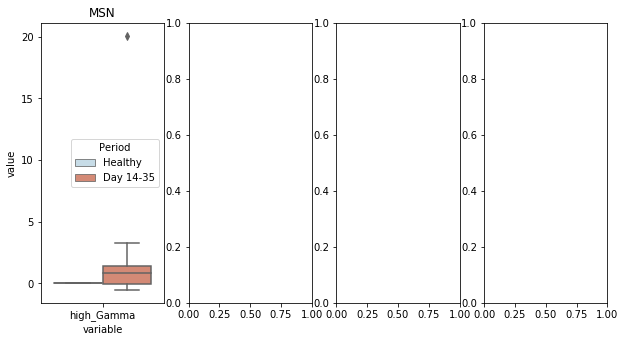

In [27]:
dfP = pd.melt(df3, id_vars = ['Period','CellType','Mouse'],value_vars = ['high_Gamma'])
fig, ax = plt.subplots(1,1,figsize=(3.15,2.15))#, sharey=True )
# dfP.CellType
# for indP, p in enumerate(['high_Gamma','high_Beta_15to20','low_Gamma']):
with sns.color_palette(colorPallet3):
    for indC,c in enumerate(["MSN"]):
        sns.boxplot(x = 'variable',y ='value',hue = 'Period',ax = ax,data= dfP[dfP.CellType ==c],
                    hue_order=['Healthy','Acute','Chronic'])#, showfliers = False)
#         sns.swarmplot(x = 'Period',y ='value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c],
#                     hue_order=['Healthy','Day 14-35'],order=['Healthy','Day 14-35'],color = 'black')
    #         sns.boxplot(x = 'Period',y =p,ax = ax[indC,indP],data= Pdf[Pdf.CellType ==c], showfliers = False)
    #         sns.pointplot(x = 'variable',y = 'value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c], showfliers = False)
        ax[indC].set_title(c)
# fig.savefig(figFolder+'figure6_statsBars_L-dopa_.svg',transparent=True)

In [37]:
Pdf = pd.read_csv(figFolder+'statsForPower.csv')
Pdf.head()
df2 = Pdf
df2 = df2.groupby(['Mouse','Period','CellType']).mean()
df2 = df2.reset_index()
df3 = df2
columns = ['high_Gamma','high_Beta_15to20','Beta_10to15','low_Gamma']

def nor(row,col):
    base = float(df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][col].item())
    val = float(row[col])
    if base==0:
        return None
    else: #base <0 and val >0:
        return (val-base)/np.abs(base)
#     else:
#         return (val-base)/base

for ind in range(len(columns)):
#     df2[columns[ind]+'_normalized'] = df2.apply(lambda row: (row[columns[ind]]-df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item())/df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item() if df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item() != 0 else None,axis=1)
    df3[columns[ind]] = df3.apply(lambda row: nor(row,columns[ind]) ,axis=1)

# df2[df2.CellType=='PV']

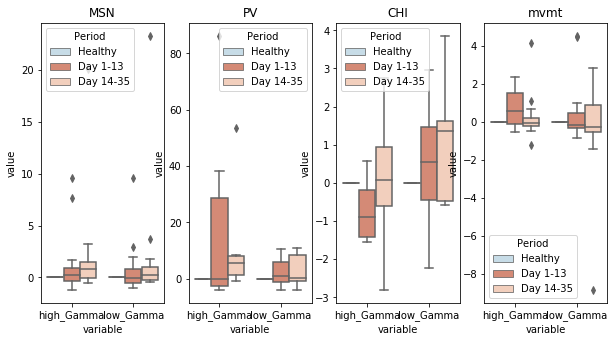

In [28]:
# %matplotlib inline
dfP = pd.melt(df3, id_vars = ['Period','CellType','Mouse'],value_vars = ['high_Gamma'])
fig, ax = plt.subplots(1,4,figsize=(10.15,5.15))#, sharey=True )
# dfP.CellType
# for indP, p in enumerate(['high_Gamma','high_Beta_15to20','low_Gamma']):
with sns.color_palette(colorPallet3):
    for indC,c in enumerate(["MSN","PV","CHI","mvmt"]):
        sns.boxplot(x = 'variable',y ='value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c],
                    hue_order=['Healthy','Acute','Chronic'])#, showfliers = False)
    #         sns.boxplot(x = 'Period',y =p,ax = ax[indC,indP],data= Pdf[Pdf.CellType ==c], showfliers = False)
    #         sns.pointplot(x = 'variable',y = 'value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c], showfliers = False)
        ax[indC].set_title(c)
# fig.savefig(figFolder+'figure6_statsBars.svg',transparent=True)
#         ax[indC,indP].set_ylim(-.5,2)
# dfP = dfP.groupby(['Period','CellType','Mouse','variable']).mean()
# dfP = dfP.reset_index()
# dfP

Supplemental figure 4B

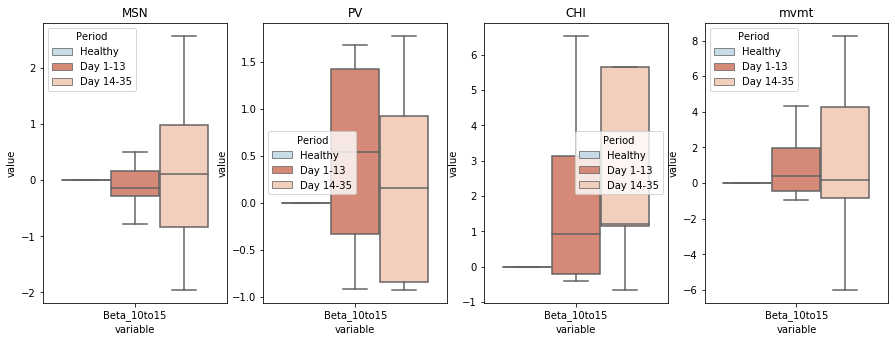

In [43]:


# %matplotlib inline
dfP = pd.melt(df3, id_vars = ['Period','CellType','Mouse'],value_vars = ['Beta_10to15'])
fig, ax = plt.subplots(1,4,figsize=(15.15,5.15))#, sharey=True )
# dfP.CellType
# for indP, p in enumerate(['high_Gamma','high_Beta_15to20','low_Gamma']):
with sns.color_palette(colorPallet3):
    for indC,c in enumerate(["MSN","PV","CHI","mvmt"]):
        sns.boxplot(x = 'variable',y ='value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c],
                    hue_order=['Healthy','Day 1-13','Day 14-35'], showfliers = False)

    #         sns.boxplot(x = 'Period',y =p,ax = ax[indC,indP],data= Pdf[Pdf.CellType ==c], showfliers = False)
    #         sns.pointplot(x = 'variable',y = 'value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c], showfliers = False)
        ax[indC].set_title(c)
fig.savefig(figFolder+'figure6_statsBars_Beta.svg',transparent=True)
#         ax[indC,indP].set_ylim(-.5,2)
# dfP = dfP.groupby(['Period','CellType','Mouse','variable']).mean()
# dfP = dfP.reset_index()
# dfP

Figure 6

In [8]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m)
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            tempDict['all'] = np.nanmean(Hs2.T,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (coeff[(Himvmt ==1),:])
                Hs = np.nansum(sessH, axis=1)
                Hs2 = sessH.T/Hs.T
                tempDict[mv] = np.nanmean(Hs2.T,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

        

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]d:\6OHDA\IO.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  lfp = hf[m][s]['ePhys']['lfp'].value
d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
d:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
  6%|█████▏                                                                             | 1/16 [00:02<00:30,  2.05s/it]

cleaning up lfp data
cleaning up speed data
0761_BaselineA 30
0761_BaselineL 30
0761_BaselineS 30
0761_day1 30
0761_day10 30
0761_day12 30
0761_day14A 30
0761_day19L 30
0761_day2 30
0761_day31A 30
0761_day35L 30
0761_day4 30
0761_day6 30
0761_day8 30


 12%|██████████▍                                                                        | 2/16 [00:04<00:28,  2.03s/it]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data
1208_BaselineA 30
1208_BaselineL 30
1208_BaselineS 30
1208_day10 30
1208_day14 30
1208_day15A 30
1208_day19L 30
1208_day2 30
1208_day30A 30
1208_day34L 30
1208_day4 30
1208_day6 30
1208_day8 30


 19%|███████████████▌                                                                   | 3/16 [00:06<00:26,  2.04s/it]

cleaning up lfp data
cleaning up speed data
1222_BaselineA 30
1222_BaselineL 30
1222_BaselineS 30
1222_day11 30
1222_day13 30
1222_day15A 30
1222_day2 30
1222_day20L 30
1222_day3 30
1222_day32A 30
1222_day36L 30
1222_day5 30
1222_day7 30
1222_day9 30


 25%|████████████████████▊                                                              | 4/16 [00:06<00:19,  1.64s/it]

cleaning up lfp data
cleaning up speed data
1231_BaselineA 30
1231_BaselineL 30
1231_BaselineS 30


 31%|█████████████████████████▉                                                         | 5/16 [00:08<00:19,  1.76s/it]

cleaning up lfp data
cleaning up speed data
1236_BaselineA 30
1236_BaselineL 30
1236_BaselineS 30
1236_day1 30
1236_day11 30
1236_day13 30
1236_day15A 30
1236_day19L 30
1236_day3 30
1236_day30A 30
1236_day35L 30
1236_day5 30
1236_day7 30
1236_day9 30


 38%|███████████████████████████████▏                                                   | 6/16 [00:09<00:14,  1.43s/it]

cleaning up lfp data
cleaning up speed data
1253_BaselineA 30
1253_BaselineL 30
1253_BaselineS 30


 44%|████████████████████████████████████▎                                              | 7/16 [00:11<00:14,  1.62s/it]

cleaning up lfp data
cleaning up speed data
1793_BaselineA 30
1793_BaselineL 30
1793_BaselineS 30
1793_day10 30
1793_day12 30
1793_day14 30
1793_day15A 30
1793_day19L 30
1793_day2 30
1793_day30A 30
1793_day34L 30
1793_day4 30
1793_day6 30
1793_day8 30


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:13<00:13,  1.73s/it]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
2976_BaselineA 30
2976_BaselineL 30
2976_BaselineS 30
2976_day10 30
2976_day12 30
2976_day14 30
2976_day15A 30
2976_day19L 30
2976_day2 30
2976_day30A 30
2976_day35L 30
2976_day6 30
2976_day8 30


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:15<00:12,  1.82s/it]

cleaning up lfp data
cleaning up speed data
2980_BaselineA 30
2980_BaselineL 30
2980_BaselineS 30
2980_day10 30
2980_day12 30
2980_day14 30
2980_day15A 30
2980_day19L 30
2980_day2 30
2980_day30A 30
2980_day35L 30
2980_day4 30
2980_day6 30
2980_day8 30


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:17<00:11,  1.90s/it]

cleaning up lfp data
cleaning up speed data
2981_BaselineA 30
2981_BaselineL 30
2981_BaselineS 30
2981_day10 30
2981_day12 30
2981_day14 30
2981_day15A 30
2981_day19L 30
2981_day2 30
2981_day30A 30
2981_day35L 30
2981_day4 30
2981_day6 30
2981_day8 30
cleaning up lfp data
cleaning up speed data
4539_Baseline2A 30
4539_BaselineA 30
4539_day0 30
4539_day1 30
4539_day10 30
4539_day11 30
4539_day12 30
4539_day13 30
4539_day14 30
4539_day15A 30
4539_day2 30
4539_day3 30
4539_day30A 30
4539_day4 30
4539_day5 30


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:19<00:09,  1.93s/it]

4539_day6 30
4539_day7 30
4539_day8 30
4539_day9 30


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:20<00:09,  1.84s/it]


KeyboardInterrupt: 

In [87]:
# coeff = np.abs(f[m]['0761_BaselineA']['Post']['coeff'].value)
lfpOutliers = removeLFPOutliers(dataPost['0761_BaselineA']['lfp']['lfp'], sess)
coeff[:,(lfpOutliers[:,0]==1)] = np.nan

In [88]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')
freq = f['1236']['1236_BaselineA']['Pre']['freq'][:]

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    dataPost =  getData(Files[0],['lfp','speed'],period ='Post', mice=m)
    data = getData(Files[0],['lfp','speed'],period ='Pre', mice=m)
    for sess in dataPost:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            
            if sess[-1] == 'S':
                drug = 'Saline'
            elif sess[-1] == 'L':
                drug = 'L-Dopa'
            else:
                drug = 'Amphetamine'

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day),'drug':drug,'timeRange':'Pre'}

            coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            tempDict['all'] = np.nanmean(Hs2.T,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (coeff[(Himvmt ==1),:])
                Hs = np.nansum(sessH, axis=1)
                Hs2 = sessH.T/Hs.T
                tempDict[mv] = np.nanmean(Hs2.T,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print('Pre: ',sess,exc_tb.tb_lineno)
        
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            
            if sess[-1] == 'S':
                drug = 'Saline'
            elif sess[-1] == 'L':
                drug = 'L-Dopa'
            else:
                drug = 'Amphetamine'

            # get data
            dtS = 1/dataPost[sess]['speed']['Fs']
            dtL = 1/dataPost[sess]['lfp']['FS']
            ts = np.arange(0, np.max(dataPost[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(dataPost[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Post','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Post','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Post','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Post','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Post','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day),'drug':drug,'timeRange':'Post'}

            
            coeff = np.abs(f[m][sess]['Post']['coeff'].value)
            lfpOutliers = removeLFPOutliers(dataPost[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            tempDict['all'] = np.nanmean(Hs2.T,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (coeff[(Himvmt ==1),:])
                Hs = np.nansum(sessH, axis=1)
                Hs2 = sessH.T/Hs.T
                tempDict[mv] = np.nanmean(Hs2.T,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print('Post: ',sess,exc_tb.tb_lineno)

        

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 0761_day1
I deleted session: 0761_day10
I deleted session: 0761_day12
I deleted session: 0761_day2
I deleted session: 0761_day4
I deleted session: 0761_day6
I deleted session: 0761_day8
cleaning up speed data
cleaning up lfp data
cleaning up speed data


<ipython-input-88-5fa41389268a>:38: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
<ipython-input-88-5fa41389268a>:102: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  coeff = np.abs(f[m][sess]['Post']['coeff'].value)
  6%|█████                                                                           | 1/16 [10:17<2:34:17, 617.19s/it]

cleaning up lfp data
I deleted session: 1208_day10
I deleted session: 1208_day12
I deleted session: 1208_day14
I deleted session: 1208_day2
I deleted session: 1208_day4
I deleted session: 1208_day6
I deleted session: 1208_day8
cleaning up speed data
cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data
found  17.0  outlier points
found  3.0  outlier points
found  2.0  outlier points


 12%|██████████                                                                      | 2/16 [21:47<2:29:09, 639.24s/it]

cleaning up lfp data
I deleted session: 1222_day11
I deleted session: 1222_day13
I deleted session: 1222_day2
I deleted session: 1222_day3
I deleted session: 1222_day5
I deleted session: 1222_day7
I deleted session: 1222_day9
cleaning up speed data
cleaning up lfp data
cleaning up speed data


 19%|███████████████                                                                 | 3/16 [31:51<2:16:09, 628.41s/it]

cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data


 25%|████████████████████                                                            | 4/16 [37:11<1:47:11, 535.96s/it]

cleaning up lfp data
I deleted session: 1236_day1
I deleted session: 1236_day11
I deleted session: 1236_day13
I deleted session: 1236_day3
I deleted session: 1236_day5
I deleted session: 1236_day7
I deleted session: 1236_day9
cleaning up speed data
cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  34.0  outlier points
found  888231.0  outlier points
found  927582.0  outlier points
found  481139.0  outlier points
found  447664.0  outlier points


 31%|█████████████████████████                                                       | 5/16 [48:03<1:44:38, 570.79s/it]

cleaning up lfp data
cleaning up speed data
cleaning up lfp data
cleaning up speed data


 38%|██████████████████████████████                                                  | 6/16 [52:36<1:20:14, 481.45s/it]

cleaning up lfp data
I deleted session: 1793_day10
I deleted session: 1793_day12
I deleted session: 1793_day14
I deleted session: 1793_day2
I deleted session: 1793_day4
I deleted session: 1793_day6
I deleted session: 1793_day8
cleaning up speed data
cleaning up lfp data
cleaning up speed data


 44%|██████████████████████████████████▏                                           | 7/16 [1:03:53<1:21:01, 540.14s/it]

cleaning up lfp data
I deleted session: 2976_day10
I deleted session: 2976_day12
I deleted session: 2976_day14
I deleted session: 2976_day2
I deleted session: 2976_day4
I deleted session: 2976_day6
I deleted session: 2976_day8
cleaning up speed data
cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  1.0  outlier points


 50%|███████████████████████████████████████                                       | 8/16 [1:15:48<1:19:01, 592.68s/it]

cleaning up lfp data
I deleted session: 2980_day10
I deleted session: 2980_day12
I deleted session: 2980_day14
I deleted session: 2980_day2
I deleted session: 2980_day4
I deleted session: 2980_day6
I deleted session: 2980_day8
cleaning up speed data
cleaning up lfp data
cleaning up speed data
found  144.0  outlier points


 56%|███████████████████████████████████████████▉                                  | 9/16 [1:26:24<1:10:38, 605.55s/it]

cleaning up lfp data
I deleted session: 2981_day10
I deleted session: 2981_day12
I deleted session: 2981_day14
I deleted session: 2981_day2
I deleted session: 2981_day4
I deleted session: 2981_day6
I deleted session: 2981_day8
cleaning up speed data
cleaning up lfp data
cleaning up speed data
found  50.0  outlier points
found  105.0  outlier points


 62%|████████████████████████████████████████████████▏                            | 10/16 [1:37:01<1:01:31, 615.21s/it]

cleaning up lfp data
I deleted session: 4539_day0
I deleted session: 4539_day1
I deleted session: 4539_day10
I deleted session: 4539_day11
I deleted session: 4539_day12
I deleted session: 4539_day13
I deleted session: 4539_day14
I deleted session: 4539_day2
I deleted session: 4539_day3
I deleted session: 4539_day4
I deleted session: 4539_day5
I deleted session: 4539_day6
I deleted session: 4539_day7
I deleted session: 4539_day8
I deleted session: 4539_day9
cleaning up speed data
cleaning up lfp data
cleaning up speed data
found  17.0  outlier points


 69%|██████████████████████████████████████████████████████▎                        | 11/16 [1:41:58<43:17, 519.53s/it]

cleaning up lfp data
I deleted session: 7584_Baseline0
I deleted session: 7584_day0
I deleted session: 7584_day1
I deleted session: 7584_day10
I deleted session: 7584_day11
I deleted session: 7584_day12
I deleted session: 7584_day15
I deleted session: 7584_day2
I deleted session: 7584_day3
I deleted session: 7584_day4
I deleted session: 7584_day5
I deleted session: 7584_day6
I deleted session: 7584_day7
I deleted session: 7584_day8
I deleted session: 7584_day9
cleaning up speed data
cleaning up lfp data
cleaning up speed data


 75%|███████████████████████████████████████████████████████████▎                   | 12/16 [1:44:18<27:02, 405.67s/it]

cleaning up lfp data
I deleted session: 7909_day0
I deleted session: 7909_day1
I deleted session: 7909_day10
I deleted session: 7909_day11
I deleted session: 7909_day12
I deleted session: 7909_day13
I deleted session: 7909_day14
I deleted session: 7909_day2
I deleted session: 7909_day3
I deleted session: 7909_day4
I deleted session: 7909_day5
I deleted session: 7909_day6
I deleted session: 7909_day7
I deleted session: 7909_day8
I deleted session: 7909_day9
cleaning up speed data
cleaning up lfp data
cleaning up speed data
found  10.0  outlier points


 81%|████████████████████████████████████████████████████████████████▏              | 13/16 [1:50:32<19:48, 396.21s/it]

cleaning up lfp data
I deleted session: 8430_day1
I deleted session: 8430_day11
I deleted session: 8430_day3
I deleted session: 8430_day5
I deleted session: 8430_day7
I deleted session: 8430_day9
cleaning up speed data
cleaning up lfp data
cleaning up speed data


 88%|█████████████████████████████████████████████████████████████████████▏         | 14/16 [1:59:46<14:46, 443.50s/it]

cleaning up lfp data
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day14
I deleted session: 8803_day2
I deleted session: 8803_day4
I deleted session: 8803_day5
I deleted session: 8803_day6
I deleted session: 8803_day8
cleaning up speed data
cleaning up lfp data
cleaning up speed data


 94%|██████████████████████████████████████████████████████████████████████████     | 15/16 [2:08:31<07:48, 468.08s/it]

cleaning up lfp data
I deleted session: 8815_day10
I deleted session: 8815_day12
I deleted session: 8815_day14
I deleted session: 8815_day2
I deleted session: 8815_day4
I deleted session: 8815_day6
I deleted session: 8815_day8
cleaning up speed data
cleaning up lfp data
cleaning up speed data


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [2:18:04<00:00, 517.76s/it]


In [90]:
df_normlizeByCol_mean = pd.DataFrame(specs)
df_normlizeByCol_mean = df_normlizeByCol_mean.T
df_normlizeByCol_mean

mouse day   period         drug timeRange  \
0761_BaselineA  0761   0  Healthy  Amphetamine      Post   
0761_BaselineL  0761   0  Healthy       L-Dopa      Post   
0761_BaselineS  0761   0  Healthy       Saline      Post   
0761_day14A     0761  14  Chronic  Amphetamine      Post   
0761_day19L     0761  19  Chronic       L-Dopa      Post   
...              ...  ..      ...          ...       ...   
8815_BaselineS  8815   0  Healthy       Saline      Post   
8815_day15A     8815  15  Chronic  Amphetamine      Post   
8815_day19L     8815  19  Chronic       L-Dopa      Post   
8815_day30A     8815  30  Chronic  Amphetamine      Post   
8815_day34L     8815  34  Chronic       L-Dopa      Post   

                                                              all  \
0761_BaselineA  [[0.028767684655268473, 0.06463936762839048, 0...   
0761_BaselineL  [[0.029895043549235237, 0.04380962397832809, 0...   
0761_BaselineS  [[0.026086530629650273, 0.04079228738468745, 0...   
0761_day14A     [[0.017636786404003547, 0.07119876102346331, 0...   
0761_day19L     [[0.029731099730866507, 0.04419501652700044, 0...   
...                                                           ...   
8815_BaselineS  [[0.02607364937132785, 0.03249790985320086, 0....   
8815_day15A     [[0.04092547325493549, 0.040666020908126904, 0...   
8815_day19L     [[0.02863397201851895, 0.03093362828331827, 0....   
8815_day30A     [[0.04528027870437163, 0.04349595401143009, 0....   
8815_day34L     [[0.030851937578674285, 0.03374680624086332, 0...   

                                                           highAC  \
0761_BaselineA  [[0.026921176987748898, 0.07229950520294622, 0...   
0761_BaselineL  [[0.020437173684492622, 0.04314596214533847, 0...   
0761_BaselineS  [[0.017882401142481477, 0.034829542503966464, ...   
0761_day14A     [[0.017463057683583593, 0.0757428478054945, 0....   
0761_day19L     [[0.01717147552089062, 0.030248737688184337, 0...   
...                                                           ...   
8815_BaselineS  [[0.02295495509436993, 0.025015897456325344, 0...   
8815_day15A     [[0.022566497713301024, 0.030625385851699202, ...   
8815_day19L     [[0.024735234989296872, 0.026263113208366252, ...   
8815_day30A                                                   NaN   
8815_day34L     [[0.039286787522090756, 0.03536107625081031, 0...   

                                                            highC  \
0761_BaselineA  [[0.028930441092292047, 0.04550464614099857, 0...   
0761_BaselineL  [[0.013082514115555836, 0.026648016329413767, ...   
0761_BaselineS  [[0.01636604147027157, 0.029427177706610286, 0...   
0761_day14A     [[0.015498422715604122, 0.05579742974736281, 0...   
0761_day19L     [[0.01394608206858146, 0.021660280566777764, 0...   
...                                                           ...   
8815_BaselineS  [[0.02654270150619135, 0.023157583591440545, 0...   
8815_day15A     [[0.0510799613950911, 0.046814981266070164, 0....   
8815_day19L     [[0.03274760378732137, 0.029432658434408423, 0...   
8815_day30A     [[0.04961908218321158, 0.04988321390658866, 0....   
8815_day34L     [[0.05062771474443488, 0.04005111164560746, 0....   

                                                           lowRot  \
0761_BaselineA  [[0.031572416695267336, 0.060696753998418805, ...   
0761_BaselineL  [[0.033053343946356936, 0.04594715314293278, 0...   
0761_BaselineS  [[0.030205617427900924, 0.043849848698948514, ...   
0761_day14A     [[0.018511470047013978, 0.07745104335273922, 0...   
0761_day19L     [[0.033156870823656155, 0.047926334331482114, ...   
...                                                           ...   
8815_BaselineS  [[0.026474608575220885, 0.03369318095369879, 0...   
8815_day15A     [[0.034372192535571465, 0.035974332306175305, ...   
8815_day19L     [[0.027974140693248495, 0.03128022624672241, 0...   
8815_day30A     [[0.03801461060677318, 0.03904461933919088, 0....   
8815_day34L     [[0.02904426671785964, 0.0336878

In [92]:
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

beta = (freq>10)&(freq<16)
gamma =(freq>40)&(freq<60)
highGamma = (freq>60)&(freq<100)

# print(periods[p]['hiSpeed'].shape,np.nanmean(periods[p]['hiSpeed'][beta],axis=0).shape)
df = pd.DataFrame(columns = ['Period','Mouse','sess','mvmt','beta','gamma'])
# # fig, ax = plt.subplots(2,3,figsize=(12.15,17.15),sharey='row')
for sess in specs.keys():
    for mv in ['highAC', 'highC', 'lowRot', 'lowSpeed', 'hiSpeed','all','rot']:
        try:
            
            df2 = pd.DataFrame({'Period':specs[sess]['period'],'Mouse':specs[sess]['mouse'],'mvmt':mv,'sess':sess,
                                'drug':specs[sess]['drug'],'timeRange':specs[sess]['timeRange'],
                                'beta':np.nanmean(specs[sess][mv][0,beta],axis=0),
                               'gamma':np.nanmean(specs[sess][mv][0,gamma],axis=0),
                               'highGamma':np.nanmean(specs[sess][mv][0,highGamma],axis=0),
                               'betaSum':np.nansum(specs[sess][mv][0,beta],axis=0),
                               'highGammaSum':np.nansum(specs[sess][mv][0,highGamma],axis=0),
                               'gammaSum':np.nansum(specs[sess][mv][0,gamma],axis=0)},index=[0])
            df = pd.concat([df,df2])
        except: 
            print(sess,mv)

df['ratio'] = df.apply(lambda x: x.beta/x.gamma, axis = 1)
df['ratio_High'] = df.apply(lambda x: x.beta/x.highGamma, axis = 1)
# df['diff'] = 
df.to_csv(figFolder+'lfpForR_post.csv')
df.head()

0761_BaselineA rot
0761_BaselineL rot
0761_BaselineS rot
0761_day14A rot
0761_day19L rot
0761_day31A rot
0761_day35L rot
1208_BaselineA rot
1208_BaselineL rot
1208_BaselineS rot
1208_day15A rot
1208_day19L rot
1208_day30A rot
1208_day34L rot
1222_BaselineA rot
1222_BaselineL rot
1222_BaselineS rot
1222_day15A rot
1222_day20L rot
1222_day32A highAC
1222_day32A rot
1222_day36L rot
1231_BaselineA rot
1231_BaselineL rot
1231_BaselineS rot
1236_BaselineA rot
1236_BaselineL rot
1236_BaselineS rot
1236_day15A rot
1236_day19L highC
1236_day19L rot
1236_day30A rot
1236_day35L highC
1236_day35L rot
1253_BaselineA highC
1253_BaselineA rot
1253_BaselineL rot
1253_BaselineS rot
1793_BaselineA rot
1793_BaselineL highAC
1793_BaselineL highC
1793_BaselineL hiSpeed
1793_BaselineL rot
1793_BaselineS rot
1793_day15A rot
1793_day19L rot
1793_day30A highAC
1793_day30A rot
1793_day34L highAC
1793_day34L highC
1793_day34L hiSpeed
1793_day34L rot
2976_BaselineA rot
2976_BaselineL rot
2976_BaselineS rot
2976_d

Period Mouse            sess      mvmt      beta     gamma         drug  \
0  Healthy  0761  0761_BaselineA    highAC  0.016719  0.012099  Amphetamine   
0  Healthy  0761  0761_BaselineA     highC  0.016299  0.011941  Amphetamine   
0  Healthy  0761  0761_BaselineA    lowRot  0.017716  0.011300  Amphetamine   
0  Healthy  0761  0761_BaselineA  lowSpeed  0.017853  0.011204  Amphetamine   
0  Healthy  0761  0761_BaselineA   hiSpeed  0.016565  0.012127  Amphetamine   

  timeRange  highGamma   betaSum  highGammaSum  gammaSum     ratio  ratio_High  
0      Post   0.004758  0.100314      0.142739  0.241982  1.381839    3.513890  
0      Post   0.004993  0.097794      0.149795  0.238815  1.364987    3.264245  
0      Post   0.004791  0.106296      0.143732  0.226003  1.567757    3.697707  
0      Post   0.004829  0.107117      0.144861  0.224088  1.593381    3.697246  
0      Post   0.004940  0.099392      0.148201  0.242534  1.366020    3.353282

In [93]:
df.timeRange.unique()

array(['Post'], dtype=object)

<IPython.core.display.Javascript object>


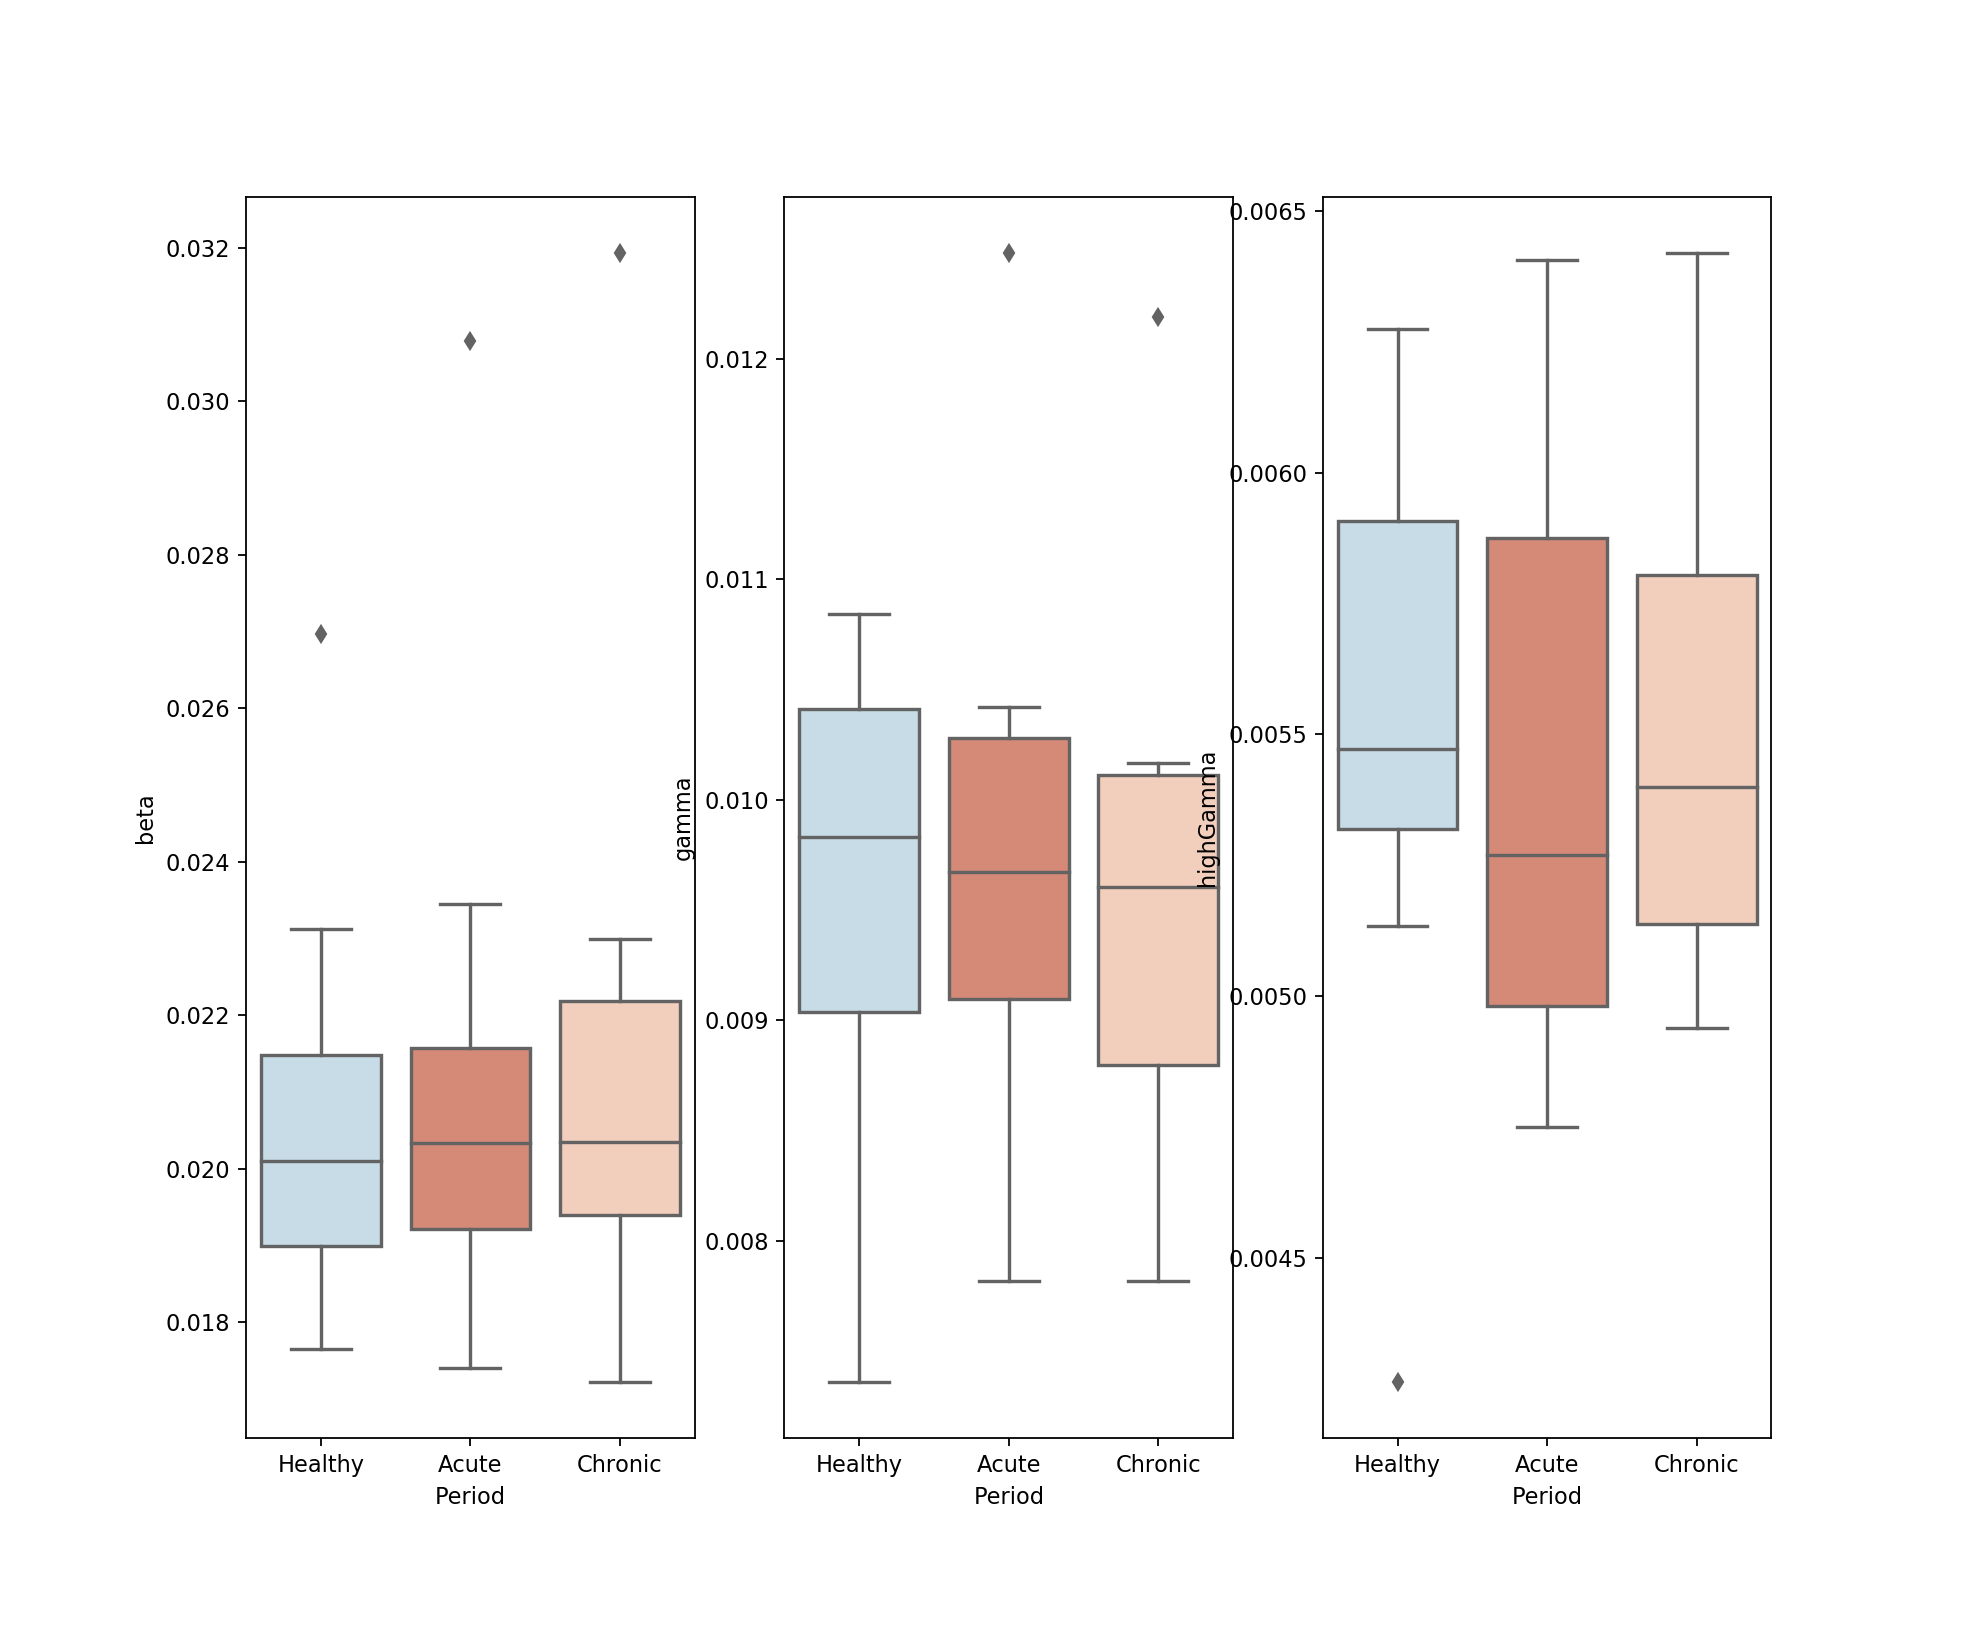

In [17]:
df = pd.read_csv(figFolder+'lfpForR.csv')
df2 = df.groupby(['Period','Mouse','mvmt']).mean()
df2 = df2.reset_index()
fig, ax = plt.subplots(1,3,figsize=(12.15,10.15))
with sns.color_palette(colorPallet3):
    sns.boxplot(x='Period',y='beta',ax = ax[0],data=df2[df2.mvmt=='all'],order = ['Healthy','Acute','Chronic'])
    sns.boxplot(x='Period',y='gamma',ax = ax[1],data=df2[df2.mvmt=='all'],order = ['Healthy','Acute','Chronic'])
    sns.boxplot(x='Period',y='highGamma',ax = ax[2],data=df2[df2.mvmt=='all'],order = ['Healthy','Acute','Chronic'])
fig.savefig(figFolder+'figure5_lfpfullSess_bar.svg',transparent=True,format='svg')


<IPython.core.display.Javascript object>


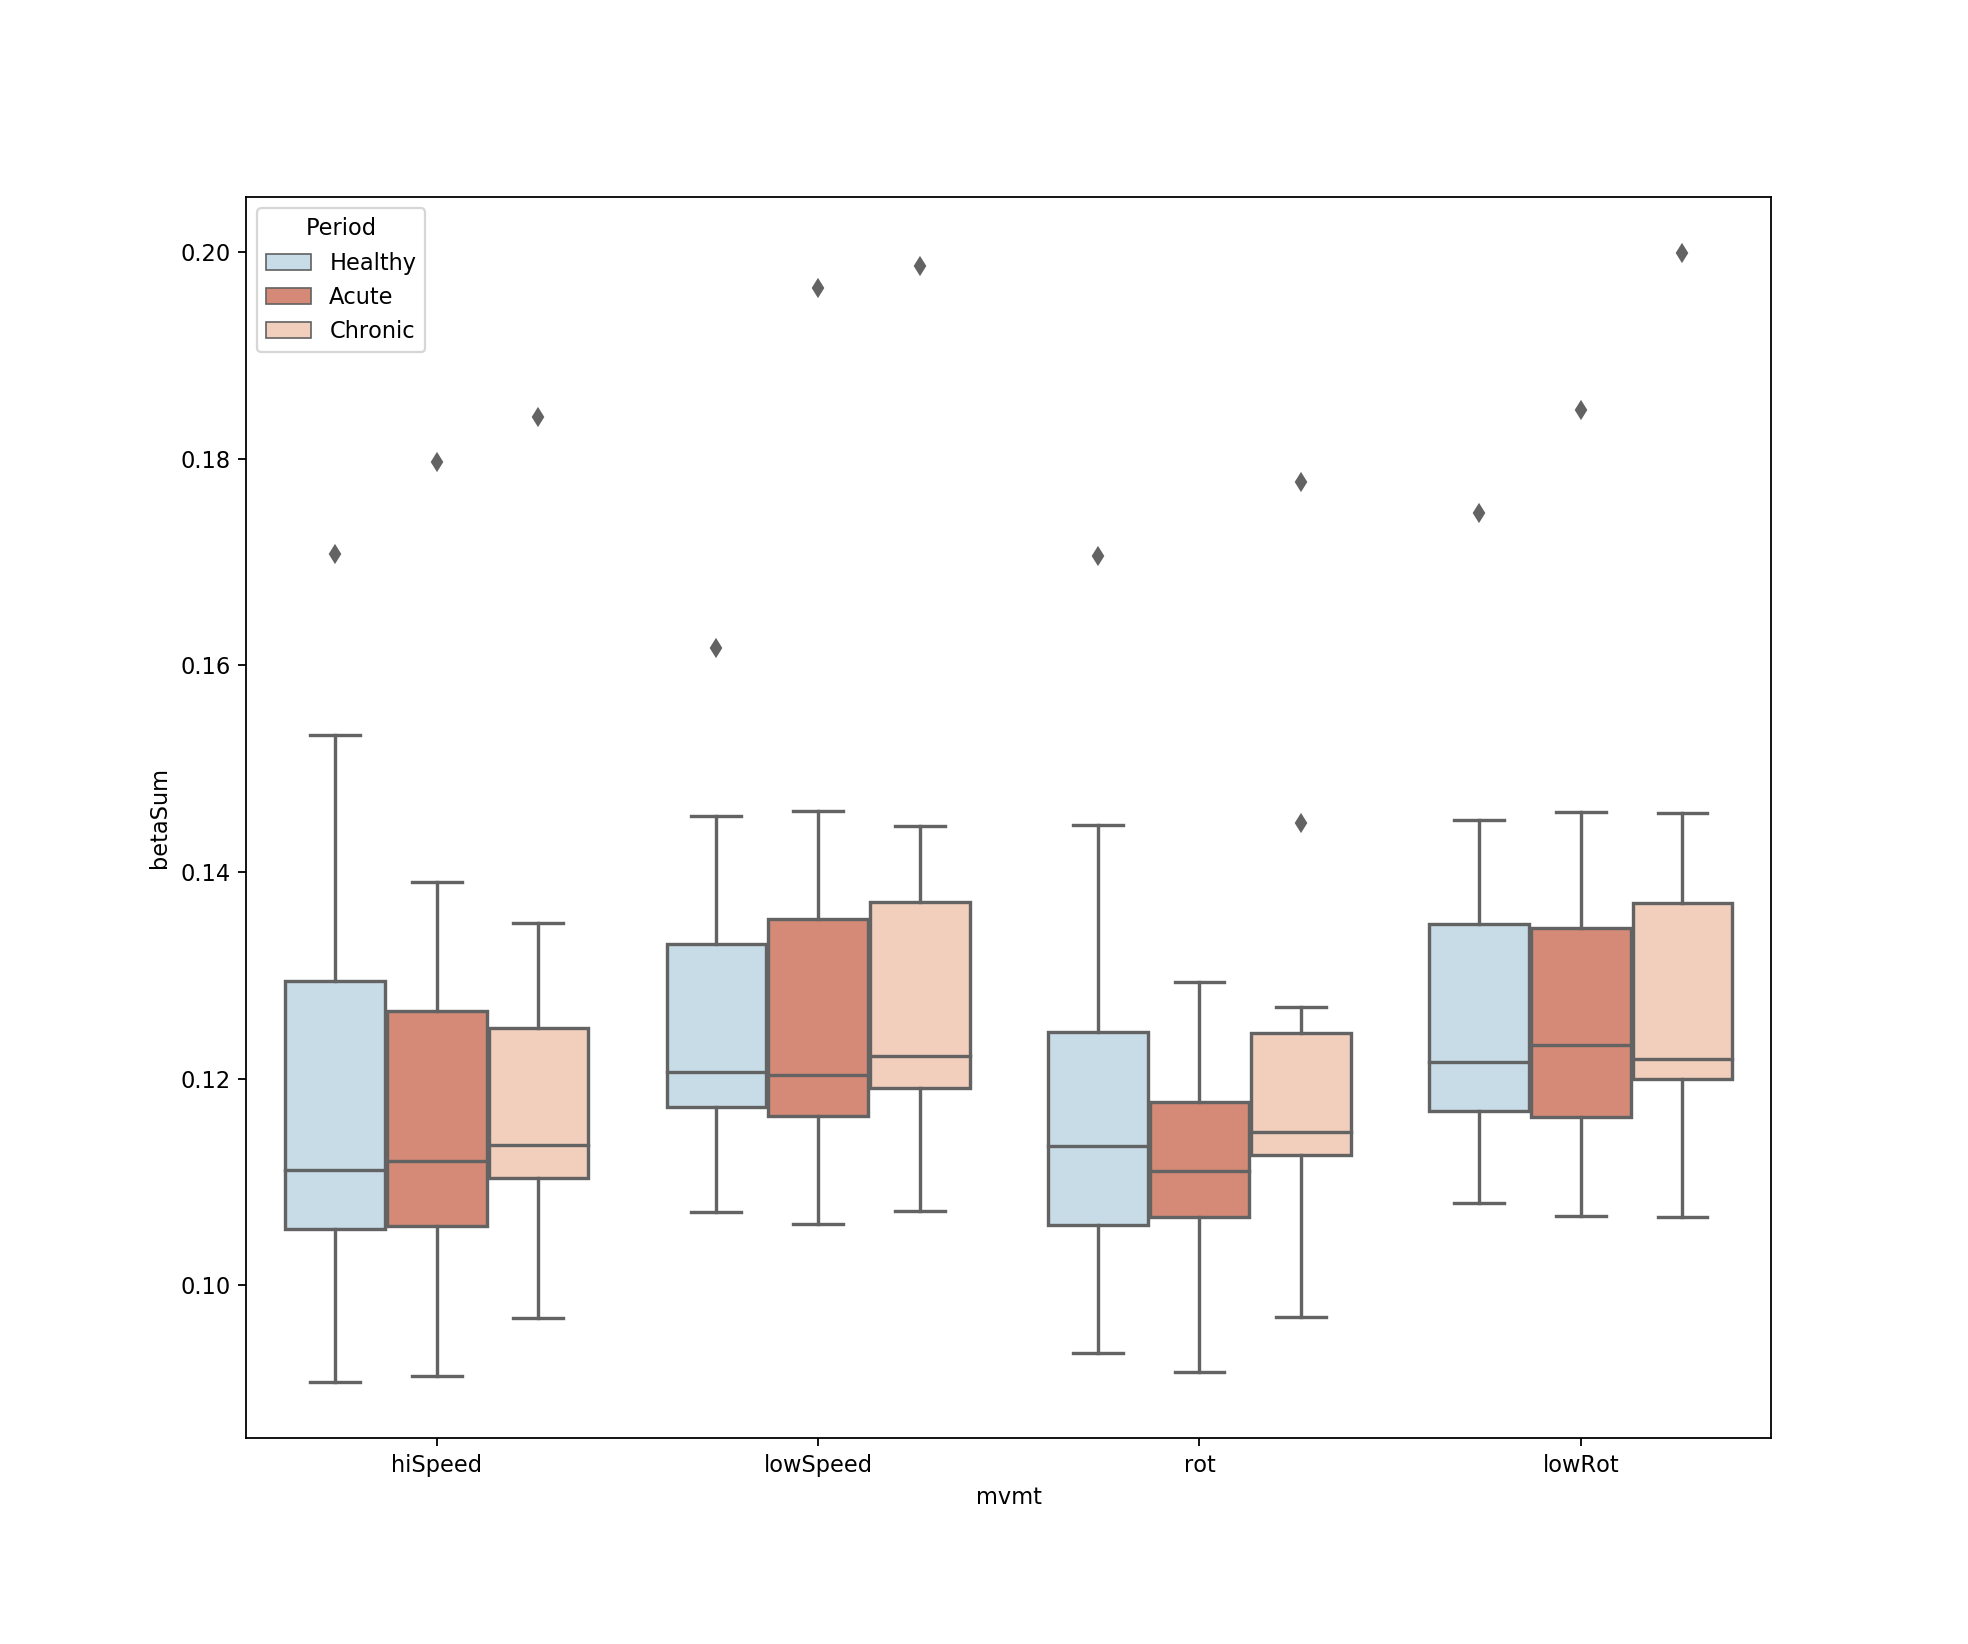

In [47]:
df = pd.read_csv(figFolder+'lfpForR.csv')
df2 = df.groupby(['Period','Mouse','mvmt']).mean()
df2 = df2.reset_index()

fig, ax = plt.subplots(1,1,figsize=(12.15,10.15))
with sns.color_palette(colorPallet3):
#     sns.boxplot(x='Period',hue = 'mvmt',y='betaSum',ax = ax[0],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
    sns.boxplot(x='mvmt',hue = 'Period',y='betaSum',ax = ax,data=df2[df2.mvmt != 'all'],
                hue_order = ['Healthy','Acute','Chronic'],
               order = ['hiSpeed','lowSpeed','rot','lowRot'])
fig.savefig(figFolder+'figure5C_bar_beta.svg',transparent=True,format='svg')



In [10]:
# all, and no 4539
periods = {'Healthy':{'axis':0},'Acute':{'axis':1},'Chronic':{'axis':2}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','all']

for p in periods.keys():
    for c in conds:
        periods[p][c] = np.zeros((87,1))
for sess in specs.keys():
    for c in conds:
        try:
            periods[specs[sess]['period']][c] = np.concatenate((periods[specs[sess]['period']][c],
                                                                   specs[sess][c].T),axis=1)
        except:
            print(sess,c)
            continue
for p in periods.keys():
    for c in conds:
        periods[p][c] = periods[p][c][:,1:]

0761_day31A highC
0761_day35L highC
0761_day35L hiSpeed
1208_day2 highC
1208_day30A highC
1208_day34L highC
1236_day15A highAC
1236_day19L highAC
1236_day30A highAC
2980_day19L highC
2981_day2 highAC
4539_day1 highAC
4539_day1 highC
4539_day10 highAC
4539_day10 highC
4539_day11 highAC
4539_day11 highC
4539_day12 highAC
4539_day12 highC
4539_day13 highAC
4539_day13 highC
4539_day14 highAC
4539_day14 highC
4539_day2 highAC
4539_day2 highC
4539_day3 highAC
4539_day3 highC
4539_day4 highAC
4539_day4 highC
4539_day5 highAC
4539_day5 highC
4539_day6 highAC
4539_day6 highC
4539_day7 highAC
4539_day7 highC
4539_day8 highAC
4539_day8 highC
4539_day9 highAC
4539_day9 highC
7584_day1 highAC
7584_day1 highC
7584_day10 highAC
7584_day10 highC
7584_day11 highAC
7584_day11 highC
7584_day12 highAC
7584_day12 highC
7584_day15 highAC
7584_day15 highC
7584_day2 highAC
7584_day2 highC
7584_day3 highAC
7584_day3 highC
7584_day4 highAC
7584_day4 highC
7584_day5 highAC
7584_day5 highC
7584_day6 highAC
7584_d

<IPython.core.display.Javascript object>


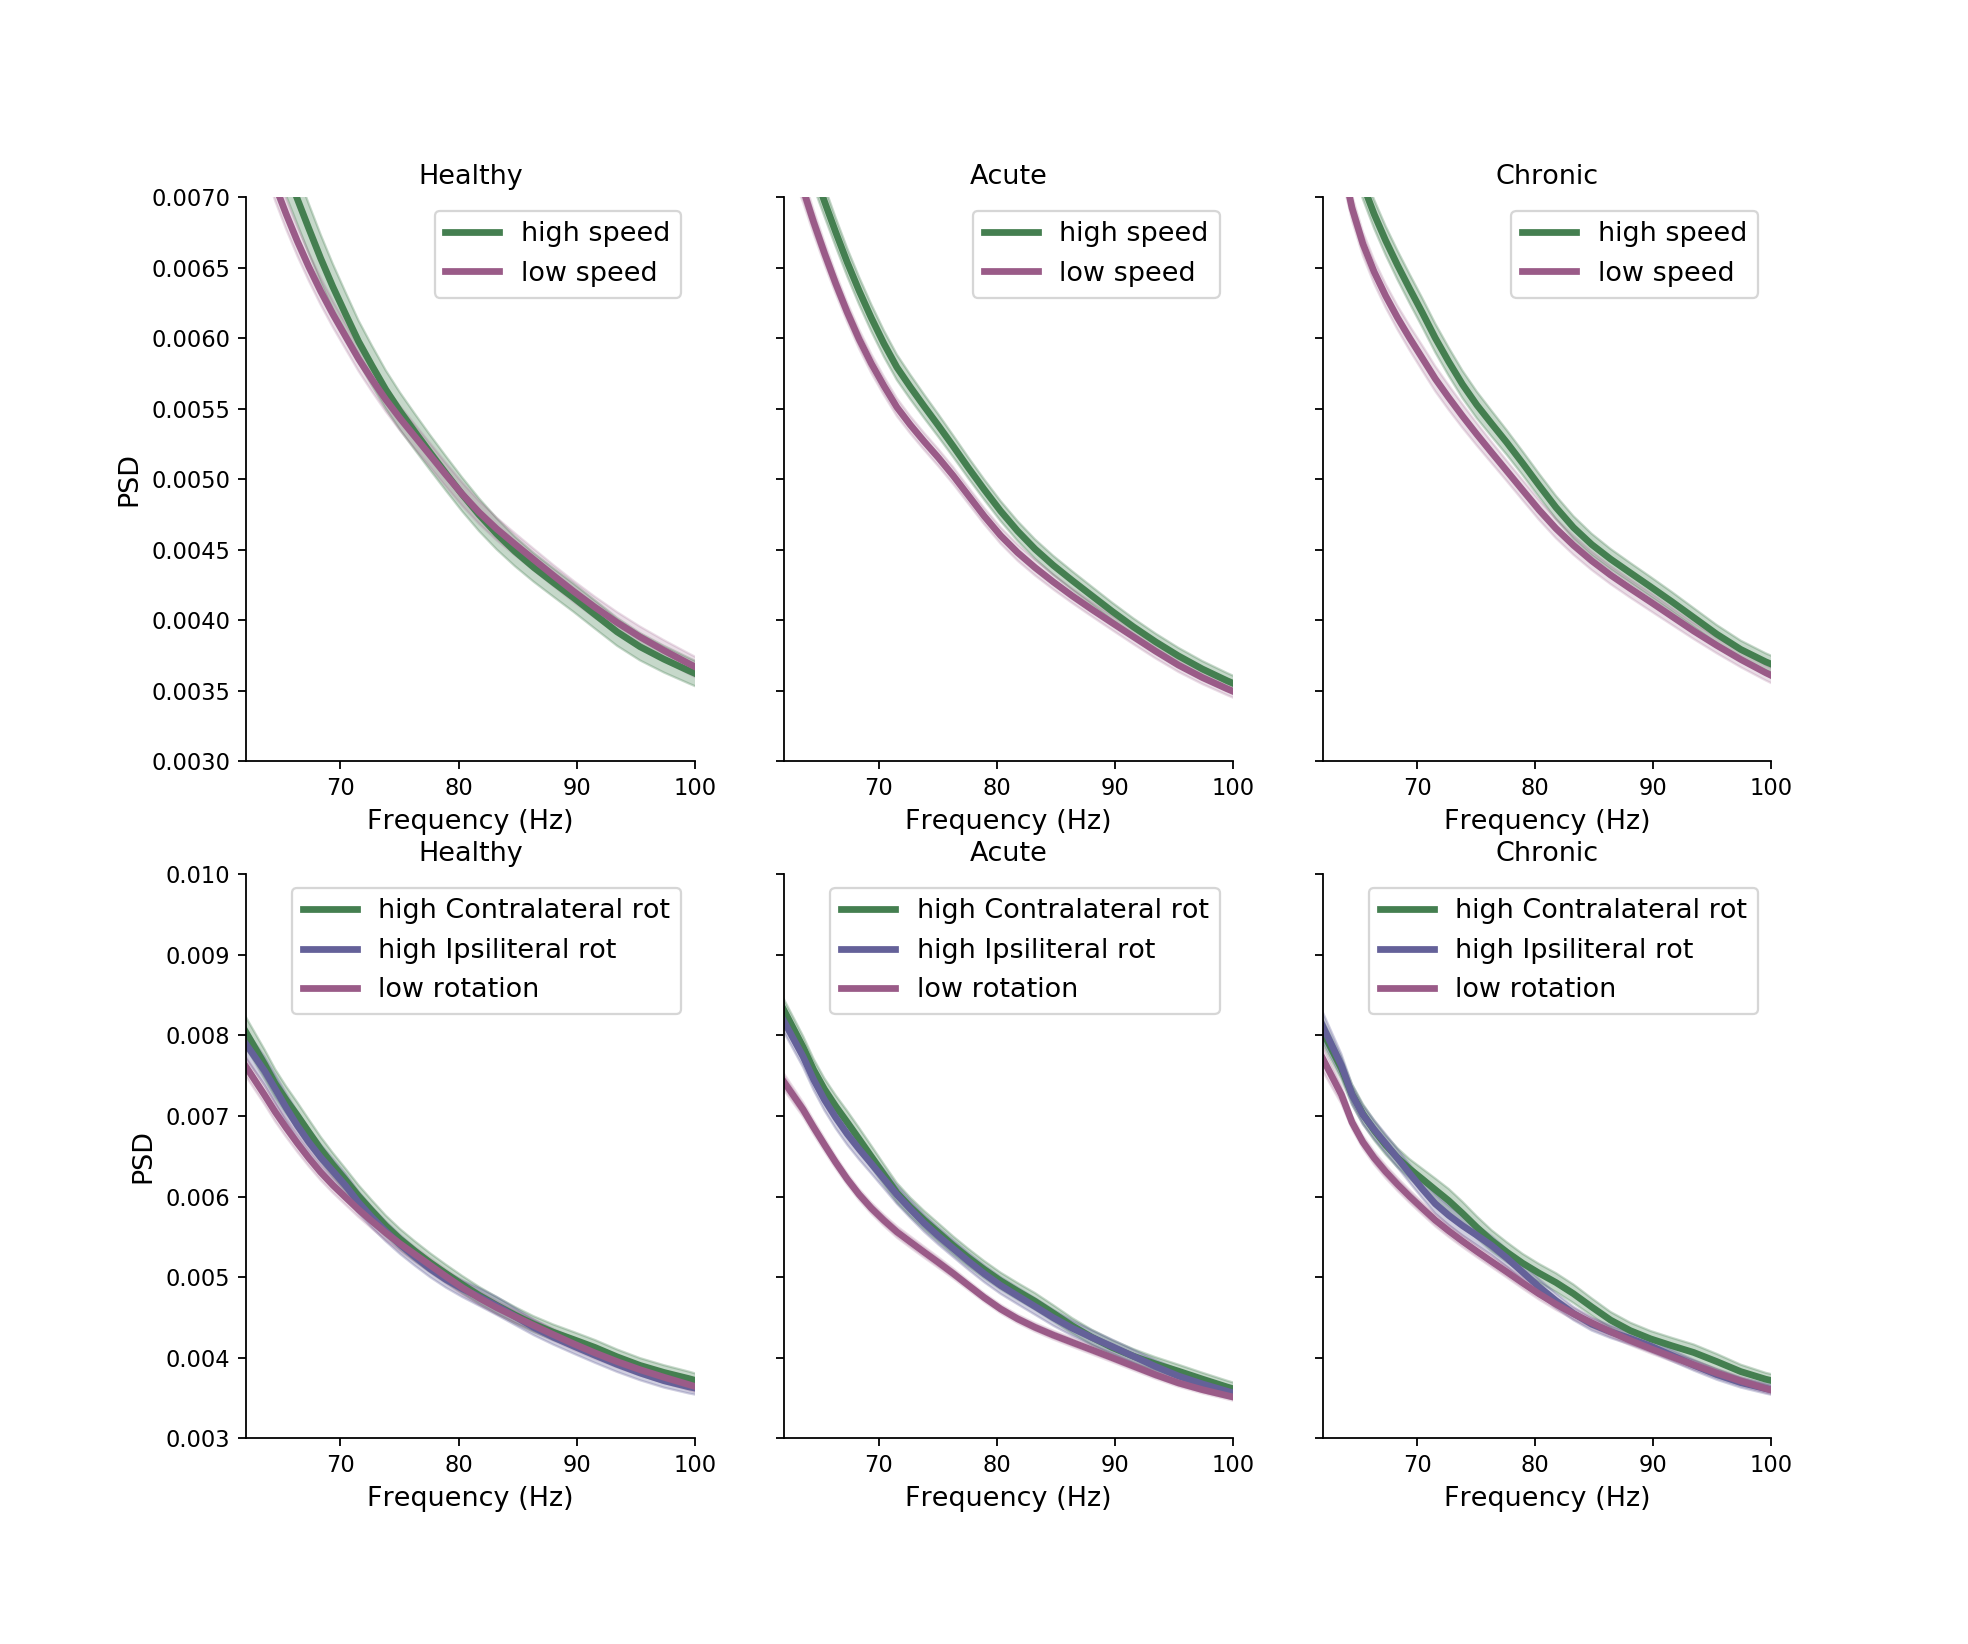

In [31]:
#periods = {'Healthy':{'axis':0},'Day 1-4':{'axis':1},'Day 5-12':{'axis':2},'Day 13-20':{'axis':3},'One Month':{'axis':4}}
%matplotlib notebook
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(2,3,figsize=(12.15,10.15),sharey='row')
f60 = (freq<=58) | (freq>=63)
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['hiSpeed'],axis=1) 
    hS2 = np.nanstd(periods[p]['hiSpeed'],axis=1)/np.sqrt(periods[p]['hiSpeed'].shape[1])   
    lC = np.nanmean(periods[p]['lowSpeed'],axis=1)
    lS2 = np.nanstd(periods[p]['lowSpeed'],axis=1)/np.sqrt(periods[p]['lowSpeed'].shape[1])
    hC = hC[f60]
    hS2=hS2[f60]
    lC = lC[f60]
    lS2 = lS2[f60]
       
    ax[0,ind].plot(freq[f60],hC,color = colorsH[4], label='high speed',linewidth=3.0)
    ax[0,ind].fill_between(freq[f60], hC-hS2, hC+hS2,color=colorsH[4],alpha=0.3)
    ax[0,ind].plot(freq[f60],lC,color = colorsL[4], label='low speed',linewidth=3.0)
    ax[0,ind].fill_between(freq[f60], lC-lS2, lC+lS2,color=colorsL[4],alpha=0.2)
    ax[0,ind].set_xlim(6,100)
#     ax[0,ind].set_yscale('log')
    ax[0,ind].set_title(p)
#    ax[0,ind].set_xlim(9,15)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax[0,0].set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax[0,ind].set_xlabel('Frequency (Hz)',fontsize=12)
    ax[0,ind].spines['right'].set_visible(False)
    ax[0,ind].spines['top'].set_visible(False)
    ax[0,ind].legend(fontsize=12)
    
    hC = np.nanmean(periods[p]['highC'],axis=1)
    hS2 = np.nanstd(periods[p]['highC'],axis=1)/np.sqrt(periods[p]['highC'].shape[1])
    hAC = np.nanmean(periods[p]['highAC'],axis=1)
    hS2A = np.nanstd(periods[p]['highAC'],axis=1)/np.sqrt(periods[p]['highAC'].shape[1])
    lC = np.nanmean(periods[p]['lowRot'],axis=1)
    lS2 = np.nanstd(periods[p]['lowRot'],axis=1)/np.sqrt(periods[p]['lowRot'].shape[1])
    hC = hC[f60]
    hS2=hS2[f60]
    hAC = hAC[f60]
    hS2A=hS2A[f60]
    lC = lC[f60]
    lS2 = lS2[f60]

       
    ax[1,ind].plot(freq[f60],hC,color = colorsH[4], label='high Contralateral rot',linewidth=3.0)
    ax[1,ind].fill_between(freq[f60], hC-hS2, hC+hS2,color=colorsH[4],alpha=0.3)
    ax[1,ind].plot(freq[f60],hAC,color = colorsH2[4], label='high Ipsiliteral rot',linewidth=3.0)
    ax[1,ind].fill_between(freq[f60], hAC-hS2A, hAC+hS2A,color=colorsH2[4],alpha=0.3)
    ax[1,ind].plot(freq[f60],lC,color = colorsL[4], label='low rotation',linewidth=3.0)
    ax[1,ind].fill_between(freq[f60], lC-lS2, lC+lS2,color=colorsL[4],alpha=0.2)
    ax[1,ind].set_xlim(6,100)
#     ax[1,ind].set_yscale('log')
    ax[1,ind].set_title(p)
#    ax[0,ind].set_xlim(9,15)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax[1,0].set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax[1,ind].set_xlabel('Frequency (Hz)',fontsize=12)
    ax[1,ind].spines['right'].set_visible(False)
    ax[1,ind].spines['top'].set_visible(False)
    ax[1,ind].legend(fontsize=12)
fig.savefig(figFolder+'lfpSpectromPeriod.png',transparent=True,format='png')
fig.savefig(figFolder+'figure5_lfpSpectromPeriod.svg',transparent=True,format='svg')

# fig2, ax2 = plt.subplots(1,2,sharex='col',sharey='row')
for ind, p in enumerate(periods.keys()):
    ax[0,ind].set_xlim(9,17)
    ax[0,ind].set_ylim(0.015,0.03)
    ax[1,ind].set_xlim(9,17)
    ax[1,ind].set_ylim(0.015,0.03)
#     ax[0,ind].set_ylim(0,0.032)
#     ax[1,ind].set_ylim(0,0.032)
#fig.savefig(figFolder+'lfpSpectromPeriodZoomBeta.png',transparent=True,format='png')
fig.savefig(figFolder+'figure5_ZoomBeta.svg',transparent=True,format='svg')
for ind, p in enumerate(periods.keys()):
    ax[0,ind].set_xlim(40,60)
    ax[0,ind].set_ylim(0.008,0.012)
    ax[1,ind].set_xlim(40,60)
    ax[1,ind].set_ylim(0.008,0.012)
#     ax[0,ind].set_ylim(0,0.02)
#     ax[1,ind].set_ylim(0,0.02)
fig.savefig(figFolder+'lfpSpectromPeriodZoomGamma.svg',transparent=True,format='svg')
# fig.savefig(figFolder+'figure5_lfpZoomGamma_log.svg',transparent=True,format='svg')
for ind, p in enumerate(periods.keys()):
#     ax[0,ind].set_yscale('log')
#     ax[1,ind].set_yscale('log')
    ax[0,ind].set_xlim(62,100)
    ax[1,ind].set_xlim(62,100)
    ax[0,ind].set_ylim(0.003,0.007)
    ax[1,ind].set_ylim(0.003,0.01)
fig.savefig(figFolder+'lfpSpectromPeriodZoomHighGamma.svg',transparent=True,format='svg')



TypeError: 'function' object is not subscriptable

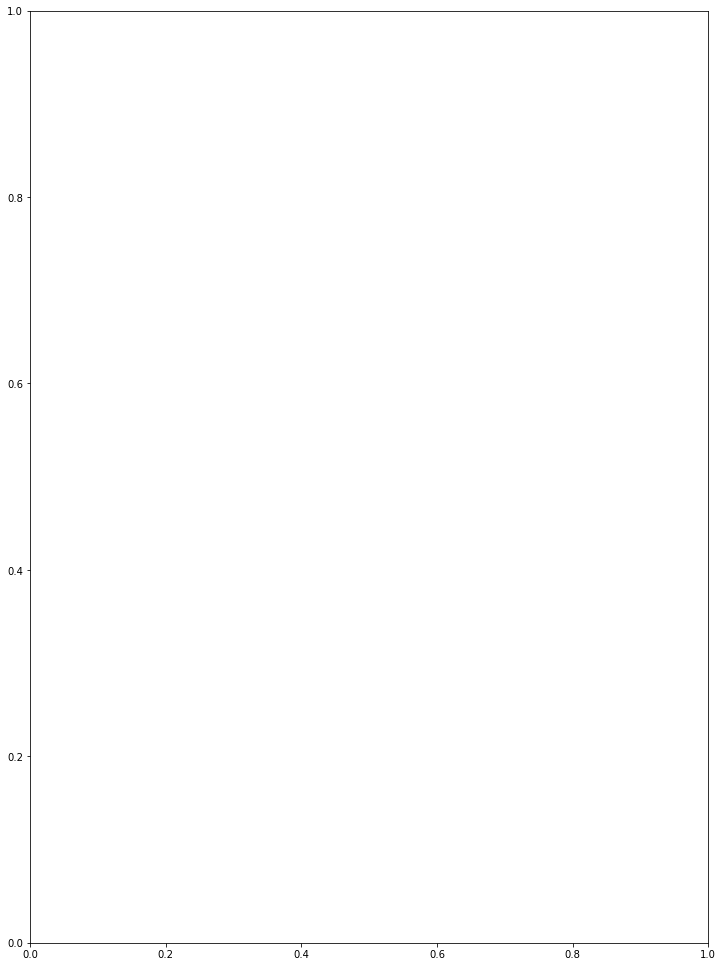

In [62]:
%matplotlib inline
colorsL = sns.cubehelix_palette(8)
colorsH = a3[[2,5,4]]#sns.cubehelix_palette(4, start=2, rot=5, dark=0, light=.65)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(1,1,figsize=(12.15,17.15),sharey='row')
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['all'],axis=1)
    hS2 = np.nanstd(periods[p]['all'],axis=1)/np.sqrt(periods[p]['all'].shape[1])
       
    ax.plot(freq,hC,color = colorsH[ind], label=p,linewidth=3.0)
    ax.fill_between(freq, hC-hS2, hC+hS2,color=colorsH[ind],alpha=0.3)
#     ax.set_xlim(6,100)
    ax.set_title('all session')
#     ax.set_xlim(60,100)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax.set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax.set_xlabel('Frequency (Hz)',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(fontsize=12)
# fig.savefig(figFolder+'lfpSpectromPeriodtotPower_all.svg',transparent=True,format='svg')
# ax.set_xlim(10,30)
# fig.savefig(figFolder+'lfpSpectromPeriodAllSess_zoomBeta.svg',transparent=True,format='svg')



<IPython.core.display.Javascript object>


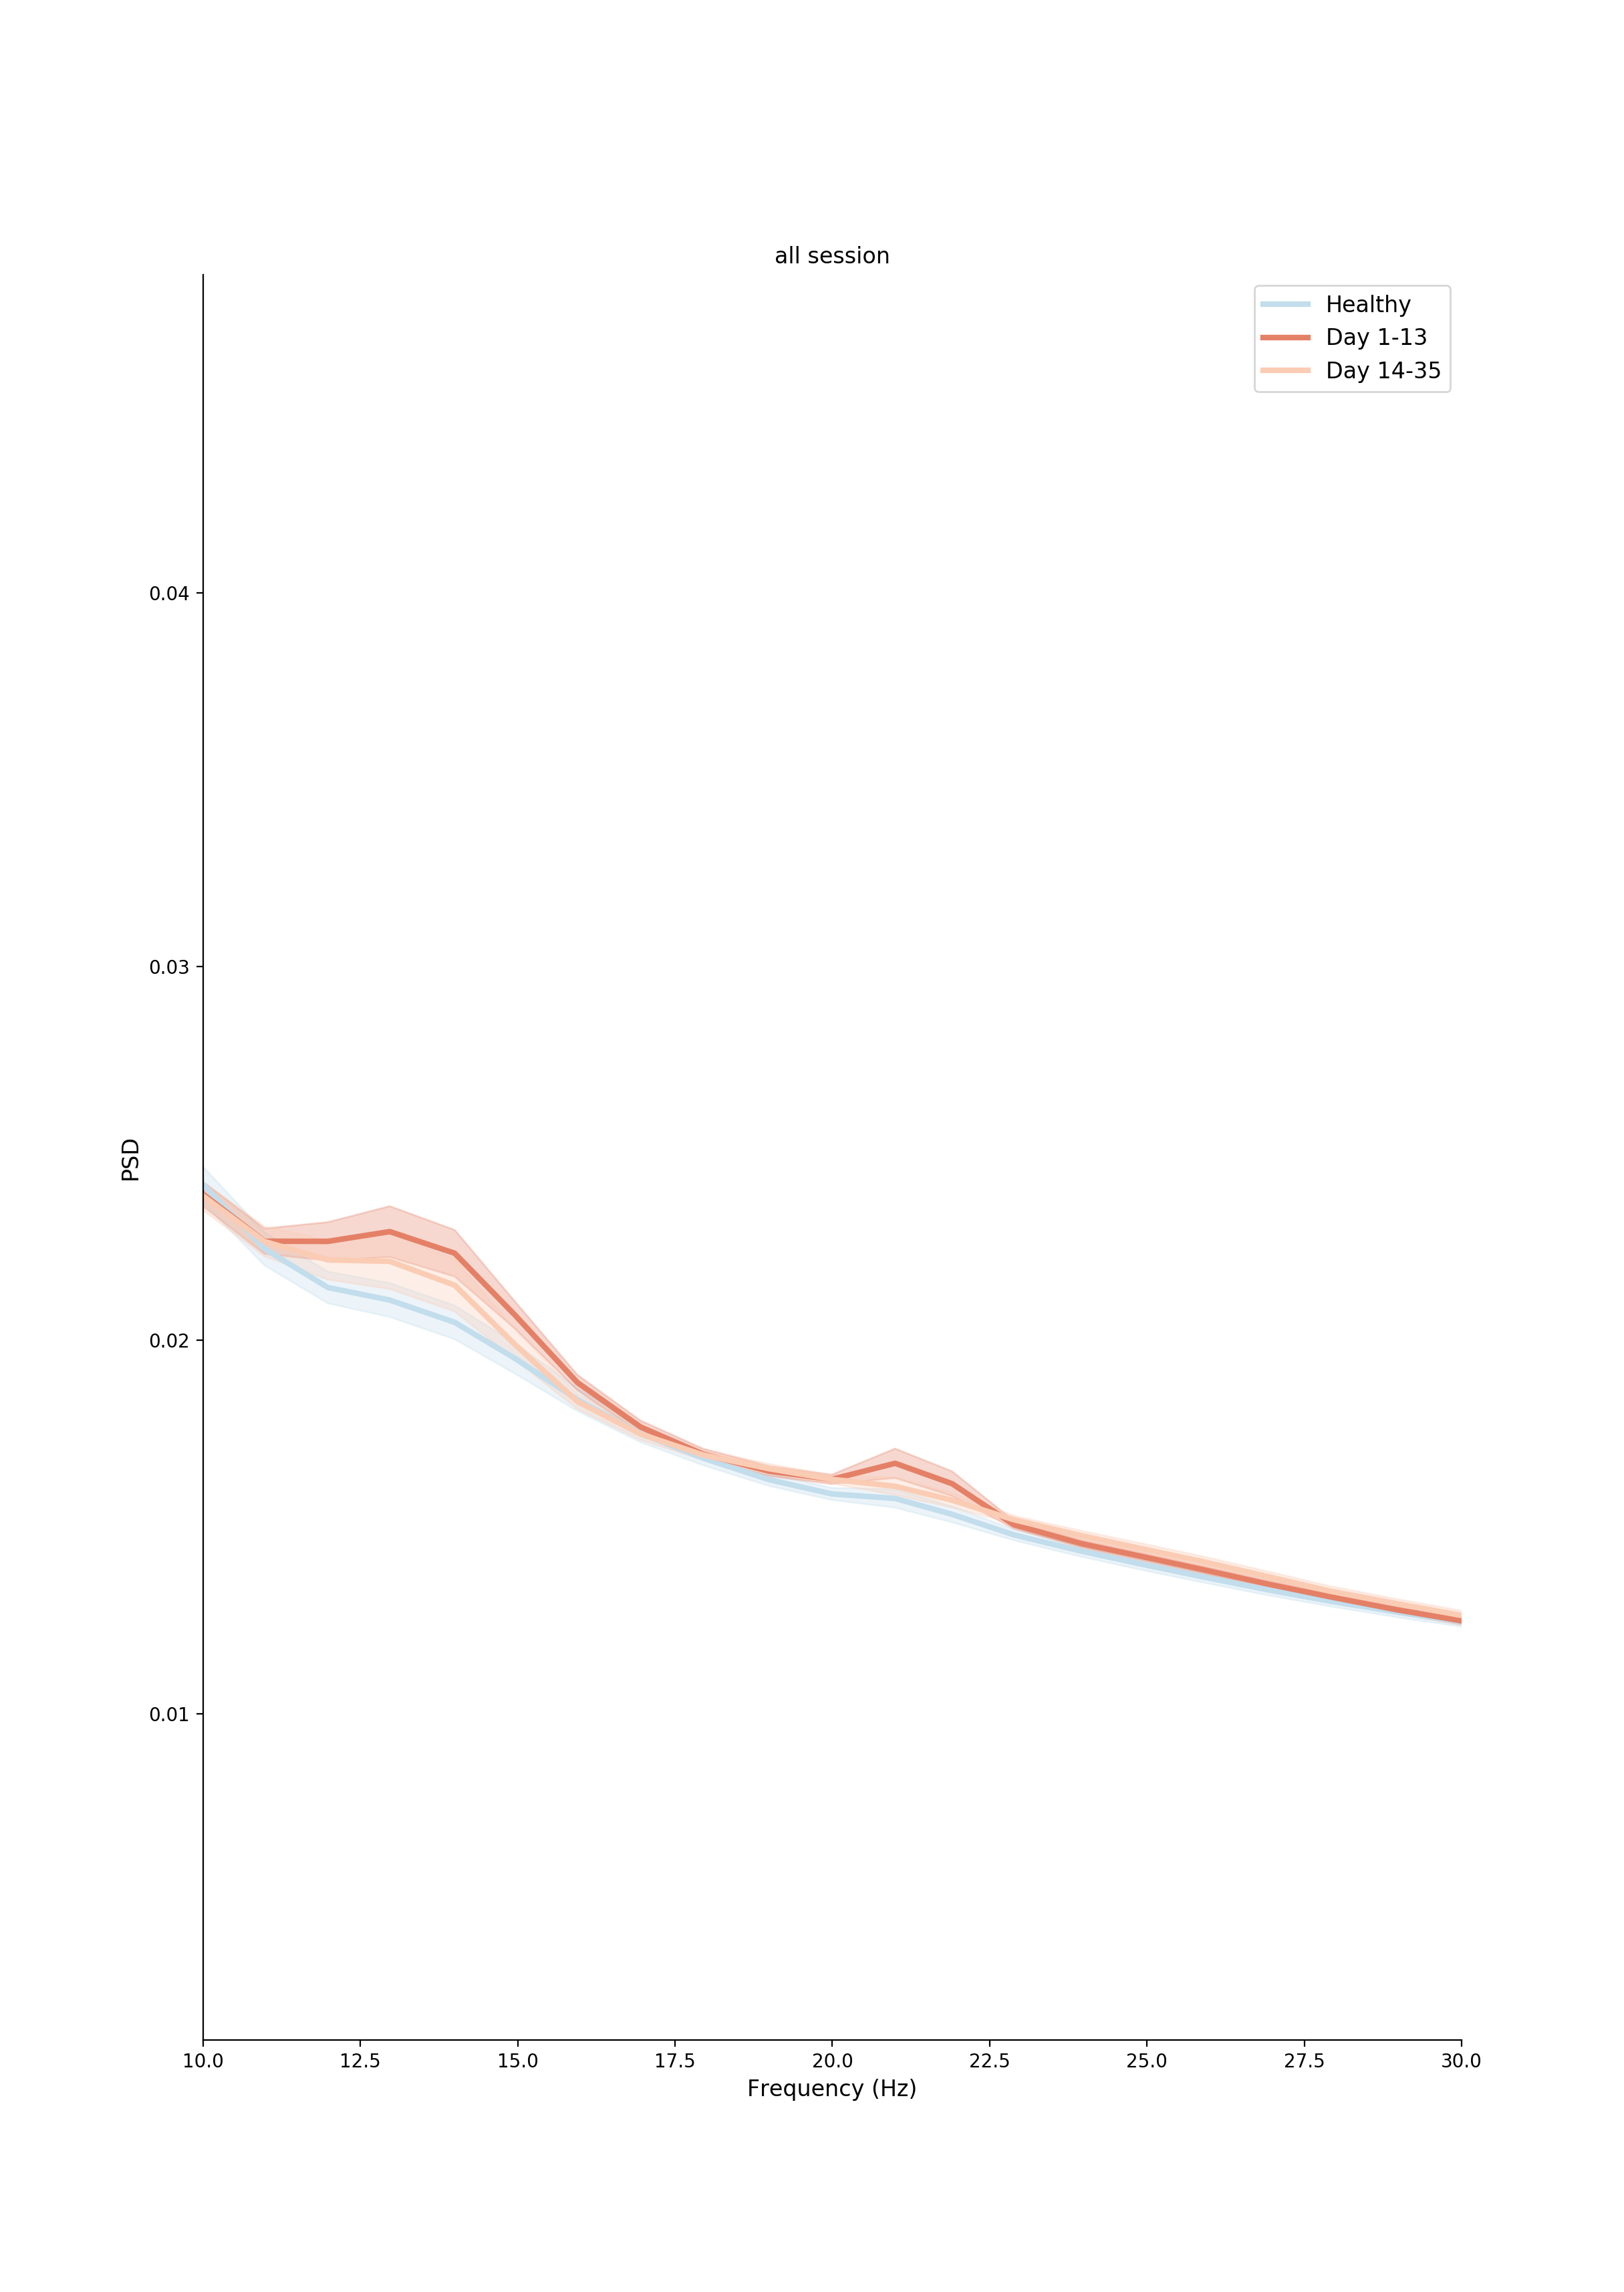

(10, 30)

In [19]:
colorsL = sns.cubehelix_palette(8)
colorsH = a3[[2,5,4]]#sns.cubehelix_palette(4, start=2, rot=5, dark=0, light=.65)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(1,1,figsize=(12.15,17.15),sharey='row')
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['all'],axis=1)
    hS2 = np.nanstd(periods[p]['all'],axis=1)/np.sqrt(periods[p]['all'].shape[1])
       
    ax.plot(freq,hC,color = colorsH[ind], label=p,linewidth=3.0)
    ax.fill_between(freq, hC-hS2, hC+hS2,color=colorsH[ind],alpha=0.3)
#     ax.set_xlim(6,100)
    ax.set_title('all session')
#     ax.set_xlim(9,15)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax.set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax.set_xlabel('Frequency (Hz)',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(fontsize=12)
# fig.savefig(figFolder+'lfpSpectromPeriodAllSess.svg',transparent=True,format='svg')
#ax.set_xlim(10,30)
# fig.savefig(figFolder+'lfpSpectromPeriodAllSess_zoomBeta.svg',transparent=True,format='svg')



Suplemental figures

In [9]:
figFolder = 'D:\\6OHDA\\supplementals\\'

In [ ]:
# plot cage rotations 
df = pd.read_csv("/home/dana_z/ssd_2TB/6OHDA/rotation_count.csv")
df['day'] = df.apply(lambda row: row.session.split('_')[0],axis=1)
df['Amph'] = df.apply(lambda row: row.session.split('_')[1],axis=1)
df['clockwise'] = pd.to_numeric(df['clockwise'])
df['anti-clockwise'] = pd.to_numeric(df['anti-clockwise'])
df.head()


fig, ax = plt.subplots(1,2,figsize=(12.15,6.7),sharey='row')
sns.boxplot(x="day", y="clockwise", hue="Amph", data=df,
                  palette="muted",ax = ax[0]) #height=6,
#g.despine(left=True)
ax[0].set_ylabel("rotations in 10min")
ax[0].set_title("clockwise rotations")


sns.boxplot(x="day", y="anti-clockwise", hue="Amph", data=df,
                palette="muted",ax = ax[1]) # height=6,
#f.despine(left=True)
ax[1].set_ylabel("rotations in 10min")
ax[1].set_title("anti-clockwise rotations")
fig.savefig(figFolder+'figureS1_cageRotations.svg',transparent=True,format='svg')

In [21]:
rotData = []

miceList = getMiceList(Files[1])
for m in miceList:
    data = getData(Files[1],['rot'],period ='Post', mice=m, drug = b'Amphetamin')
    
    # calculte % high rot + % low rot
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        hACp = getOnsetOrPeriod(m,sess,'Post','hiACRotPeriods_vector')
        hCp = getOnsetOrPeriod(m,sess,'Post','hiCRotPeriods_vector')
        Lp = getOnsetOrPeriod(m,sess,'Post','loRotPeriods_vector')
        comb = hACp*8+Lp*5+hCp*7
                
        row['percent_low'] = np.sum(Lp*1)/len(Lp)
        row['percent_high_AC'] = np.sum(hACp*1)/len(hACp)
        row['percent_high_C'] = np.sum(hCp*1)/len(hCp)
        row['percent_non'] = np.sum(comb==0)/len(comb)
        
        trans = comb[1:]-comb[:-1]
        
        row['trans'] = np.sum(trans!=0)
        row['tran_low2high'] = np.sum(trans>0)
        row['tran_high2low'] = np.sum(trans<0)
        row['rotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','rotOnset')) 
        row['cRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','clockWiseOnset'))
        row['acRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','antiClockWiseOnset'))
        
        rotData.append(row)
          
dfRot = pd.DataFrame(rotData)        
dfRot['Period'] =  dfRot.apply (lambda row:  'Healthy' if row.Day ==0 else ('Day 15' if row.Day< 30 else 'Day 30') , axis=1)

d:\6OHDA\IO.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  rot = hf[m][s]['mvmt']['rotation'].value
d:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data


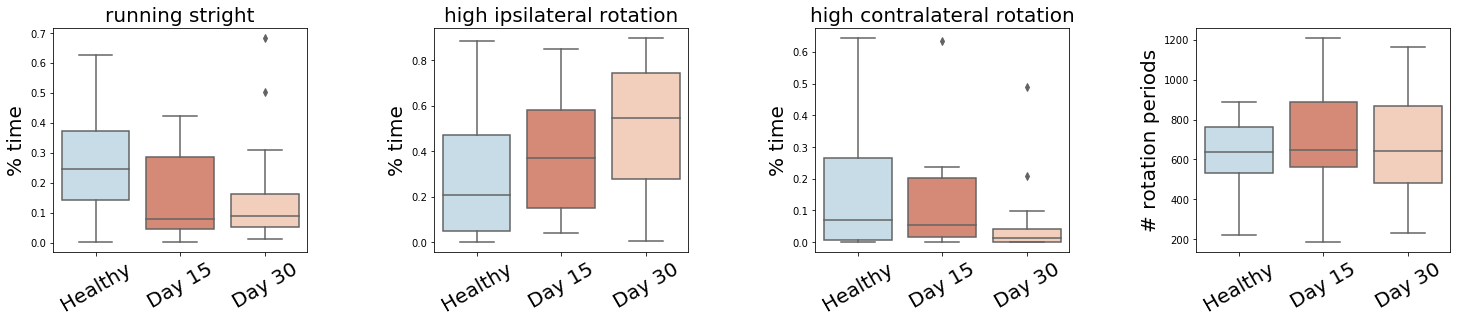

In [23]:
# repeat with paired t-test
# sns.set_style("white")
df2Rot = dfRot.groupby(['Mouse','Period']).mean()
df2Rot.reset_index(inplace=True)
#dfRot.to_csv(figFolder+'postAmphRot2R.csv')

fig, ax = plt.subplots(1,4,figsize=(25.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Day 15','Day 30']
with sns.color_palette(colorPallet3Post):#sns.color_palette("PuBuGn_d"):
    columns = ['percent_low','percent_high_AC','percent_high_C','trans'] 
    labels = ['running stright','high ipsilateral rotation',
              'high contralateral rotation','']
    Ylabels = ['% time','% time','% time','# rotation periods']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind],order = pOrder)
        #sns.scatterplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind])
        ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
        ax[ind].set_ylabel(Ylabels[ind],fontsize=20)
        ax[ind].set_xlabel("")  
        ax[ind].set_title(labels[ind],fontsize=20)      
        
#fig.savefig(figFolder+'figure2d_post.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure2d_post.svg',transparent=True,format='svg')


In [ ]:
speedData = []

miceList = getMiceList(Files[1])
for m in miceList:
    data = getData(Files[1],['speed'],period ='Post', mice=m,drug=b'Amphetamin')
    
    # calculte % high speed + % low speed
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        Hp = getOnsetOrPeriod(m,sess,'Post','HighMvmtPeriods_vector')
        Lp = getOnsetOrPeriod(m,sess,'Post','LowMvmtPeriods_vector')
        comb = Hp*1+((Lp*1)-1)*-1
                
        row['percent_low'] = np.sum(Lp*1)/len(Lp)
        row['percent_high'] = np.sum(Hp*1)/len(Hp)
        row['percent_medium'] = np.sum(comb==1)/len(comb)
        
        trans = comb[1:]-comb[:-1]
        
        row['tran_all'] = np.sum(np.abs(trans!=0))
        row['tran_low2any'] = np.sum(np.abs(Lp[1:]*1-Lp[:-1]*1))
        row['tran_high2any'] = np.sum(np.abs(Hp[1:]*1-Hp[:-1]*1))
        
        row['MvmtOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','mvmtOnset'))        
        speedData.append(row)
          
df = pd.DataFrame(speedData)        
df['Period'] =  df.apply (lambda row: periodCalc(row.Day) , axis=1)

In [ ]:
df.to_csv(figFolder+'postAmphSpeed2R.csv')
df2 = df.groupby(['Mouse','Period']).mean()
df2.reset_index(inplace=True)

fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Day 13-20','One Month']
with sns.color_palette(colorPallet3Post):#sns.color_palette("PuBuGn_d"):
    columns = ['percent_low','percent_high','tran_low2any'] 
    labels = ['% time in low Speed','% time in high Speed','# periods']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2,ax =ax[ind],order = pOrder)
        #sns.scatterplot(x="Period", y=columns[ind], data=df2,ax =ax[ind])
        ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
        ax[ind].set_ylabel(labels[ind],fontsize=20)
        ax[ind].set_xlabel("")
        
        
#fig.savefig(figFolder+'figureS2_a.png',transparent=False,format='png')
fig.savefig(figFolder+'figureS2_a.svg',transparent=True,format='svg')


In [ ]:
periods = {'Healthy':lambda x: x==0,
           'Day 13-20':lambda x: (x>12) & (x<21),
           'One Month':lambda x: x>21}

fig, ax = plt.subplots(1,1,figsize=(5.99,5.67),gridspec_kw = {'hspace':.1,'bottom':0.3,'left':.26})
for indP,p in enumerate(periods.keys()):
    #to make sure mice are equally represented in each period
    weightsH = np.zeros((199,))
    for m in miceList:
        dataH = getData(Files[1],['speed'],period ='Post', day = periods[p],mice = m)
        speedM = np.empty((1,0))
        for sess in dataH:
            speedM = np.concatenate((speedM, dataH[sess]['speed']['speed']), axis=1)
        hist, bin_edges = np.histogram(speedM, bins=np.arange(0,200)*0.5)
        hist  = hist/np.nansum(hist) # normalize per mouse
        weightsH = np.nansum((weightsH, hist),axis=0)

    ax.plot(np.arange(0,199)*0.5,weightsH/16,label=p,color=colorPallet3Post[indP,:])    
ax.set_xlim(0,60)
ax.set_xlabel('speed cm/s',fontsize=16)
ax.set_ylabel('Probability',fontsize=16)
ax.legend(fontsize=10)
#fig.savefig(figFolder+'figureS2_d.png',transparent=False,format='png')
fig.savefig(figFolder+'figureS2_d.svg',transparent=True,format='svg')

In [ ]:
df2 = df.groupby(['Mouse','Period']).mean()
df2.reset_index(inplace=True)

fig, ax = plt.subplots(1,1,figsize=(4.88,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Day 13-20','One Month']
with sns.color_palette(colorPallet3Post):#sns.color_palette("PuBuGn_d"):
    columns = ['MvmtOnset'] 
    labels = ['speed onsets']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2,ax =ax,order = pOrder)
        #sns.scatterplot(x="Period", y=columns[ind], data=df2,ax =ax[ind])
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30,fontsize=20)
        ax.set_ylabel("mean # onsets",fontsize=20)
        ax.set_xlabel("")
        ax.set_title(labels[ind],fontsize=20)
        
#fig.savefig(figFolder+'figureS2_e.png',transparent=False,format='png')
fig.savefig(figFolder+'figureS2_e.svg',transparent=True,format='svg')


In [ ]:
rotData = []

miceList = getMiceList(Files[1])
for m in miceList:
    data = getData(Files[1],['rot'],period ='Post', mice=m, drug = b'Amphetamin')
    
    # calculte % high rot + % low rot
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        hACp = getOnsetOrPeriod(m,sess,'Post','hiACRotPeriods_vector')
        hCp = getOnsetOrPeriod(m,sess,'Post','hiCRotPeriods_vector')
        Lp = getOnsetOrPeriod(m,sess,'Post','loRotPeriods_vector')
        comb = hACp*8+Lp*5+hCp*7
                
        row['percent_low'] = np.sum(Lp*1)/len(Lp)
        row['percent_high_AC'] = np.sum(hACp*1)/len(hACp)
        row['percent_high_C'] = np.sum(hCp*1)/len(hCp)
        row['percent_non'] = np.sum(comb==0)/len(comb)
        
        trans = comb[1:]-comb[:-1]
        
        row['trans'] = np.sum(trans!=0)
        row['tran_low2high'] = np.sum(trans>0)
        row['tran_high2low'] = np.sum(trans<0)
        row['rotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','rotOnset')) 
        row['cRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','clockWiseOnset'))
        row['acRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','antiClockWiseOnset'))
        
        rotData.append(row)
          
dfRot = pd.DataFrame(rotData)        
dfRot['Period'] =  dfRot.apply (lambda row: periodCalc(row.Day) , axis=1)

In [ ]:
df2Rot = dfRot.groupby(['Mouse','Period']).mean()
df2Rot.reset_index(inplace=True)
df2Rot

fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24},sharey = True)
fig2, ax2 = plt.subplots(1,3,figsize=(17.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24},sharey = True)

pOrder = ['Healthy','Day 13-20','One Month']
with sns.color_palette(colorPallet3Post):#sns.color_palette("PuBuGn_d"):
    columns = ['rotOnset','cRotOnset','acRotOnset'] 
    labels = ['total rotational onsets','contralateral rotation onsets','ipsilateral rotation onsets']
    for ind in range(len(columns)):
        if ind >0:
            sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind-1],order = pOrder)
            #sns.scatterplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind])
            ax[ind-1].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
            ax[ind-1].set_ylabel("mean # onsets",fontsize=20)
            ax[ind-1].set_xlabel("")
            ax[ind-1].set_title(labels[ind],fontsize=20)
        else:
            sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax2[ind],order = pOrder)
            #sns.scatterplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind])
            ax2[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
            ax2[ind].set_ylabel("mean # onsets",fontsize=20)
            ax2[ind].set_xlabel("")
            ax2[ind].set_title(labels[ind],fontsize=20)

#fig.savefig(figFolder+'figureS2_f.png',transparent=False,format='png')
fig.savefig(figFolder+'figureS2_f1.svg',transparent=True,format='svg')
fig2.savefig(figFolder+'figureS2_f2.svg',transparent=True,format='svg')


Text(0, 0.5, 'ipsileteral rotation')

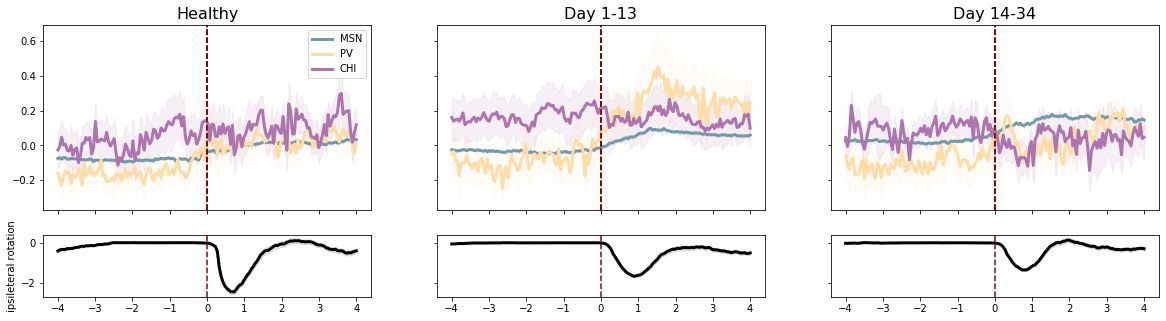

In [45]:
# Put stats abouve this cell
fig, ax = plt.subplots(2,3,figsize=(20, 5),sharex='col',sharey='row',gridspec_kw={'height_ratios': [3,1]})
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Day 1-13':1,'Day 14-34':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = []

for p in Period.keys():
    axInd = 0;
    for c in cond:
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['rot']['rot'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            sOnset = getOnsetOrPeriod(m,s,'Pre','antiClockWiseOnset2')   
            if np.sum(sOnset) == 0:
                continue
            
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
      
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        if c== 'MSN':
            PlotRelativeToOnset(ax[1,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            del sAlignedS
        del sAligned
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)

ax[1,0].set_ylabel('ipsileteral rotation')



#  sOnset2 = getOnsetOrPeriod(m,s,'Pre','clockWiseOnset')        


#fig2.savefig(figFolder+'figure4_cells_aligned_to_ipsiRotation_hist.svg',transparent=True)
# fig.savefig(figFolder+'figure4b_ipsi.svg',transparent=True)

# #fig2, ax2 = plt.subplots(1,2,sharex='col',sharey='row')


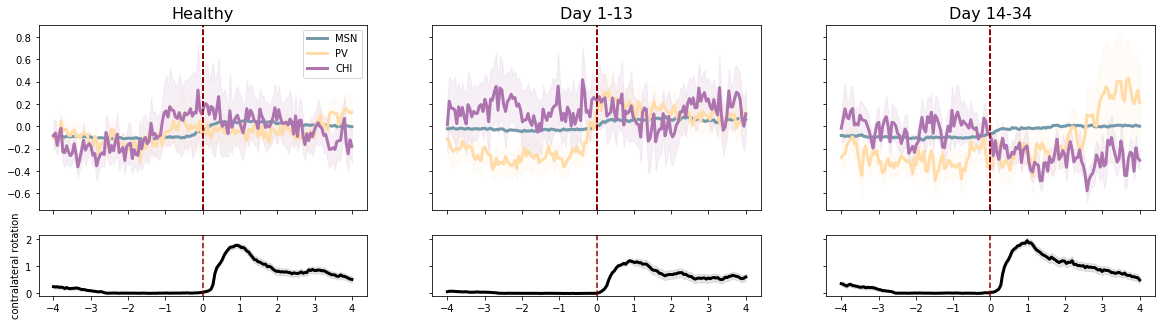

In [46]:
fig, ax = plt.subplots(2,3,figsize=(20, 5),sharex='col',sharey='row',gridspec_kw={'height_ratios': [3,1]})
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Day 1-13':1,'Day 14-34':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #4s
PostS = 80 # 4s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = []

for p in Period.keys():
    axInd = 0;
    for c in cond:
        if p=='One Month' and c == 'CHI':
            continue #there are not enough mice
        
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['rot']['rot'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            sOnset =  getOnsetOrPeriod(m,s,'Pre','clockWiseOnset2') 
            if np.sum(sOnset) == 0:
                continue
            
            
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
      
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        if c== 'MSN':
            PlotRelativeToOnset(ax[1,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            del sAlignedS
        del sAligned
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
ax[1,0].set_ylabel('contralateral rotation')
       


#fig2.savefig(figFolder+'figure4_cells_aligned_to_ipsiRotation_hist.svg',transparent=True)
# fig.savefig(figFolder+'figure4b_contra.svg',transparent=True)

# #fig2, ax2 = plt.subplots(1,2,sharex='col',sharey='row')


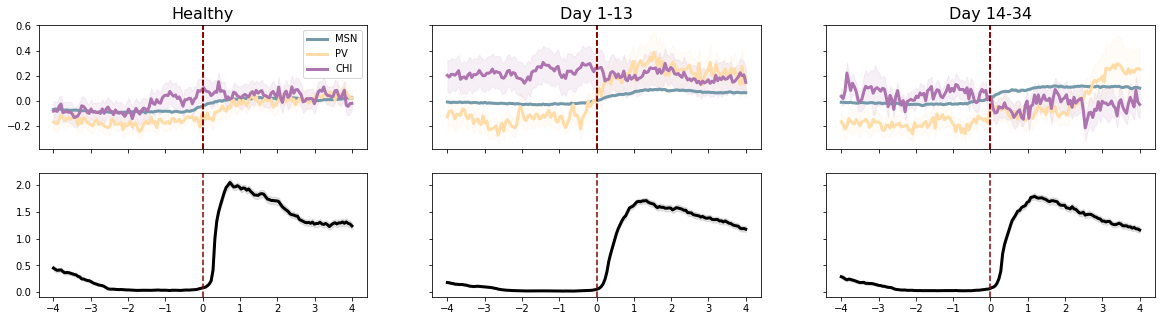

In [47]:
fig, ax = plt.subplots(2,3,figsize=(20, 5),sharex='col',sharey='row')
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Day 1-13':1,'Day 14-34':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #4s
PostS = 80 # 4s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = []

for p in Period.keys():
    axInd = 0;
    for c in cond:
        if p=='One Month' and c == 'CHI':
            continue #there are not enough mice
        
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['rot']['rot'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            cOnset =  getOnsetOrPeriod(m,s,'Pre','clockWiseOnset2') 
            acOnset = getOnsetOrPeriod(m,s,'Pre','antiClockWiseOnset2')  
            sOnset = cOnset+acOnset
            if np.sum(sOnset) == 0:
                continue
                       
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(np.abs(speed), sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
            
     
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        if c== 'MSN':
            PlotRelativeToOnset(ax[1,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            del sAlignedS
        del sAligned
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
# ax[0,0].set_ylim(-0.75,0.5)
# ax[1,0].set_ylim(-1,1.2)
# ax[2,0].set_ylim(-0.75,1)
# ax[3,0].set_ylabel('ipsileteral rotation')
       


#fig2.savefig(figFolder+'figure4_cells_aligned_to_ipsiRotation_hist.svg',transparent=True)
# fig.savefig(figFolder+'figure4b_totRot.svg',transparent=True)

# #fig2, ax2 = plt.subplots(1,2,sharex='col',sharey='row')


In [118]:
# Recalculate the LFP align to contra rotation onset - take a few days to run. 
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = '/home/dana_z/HD1/lfp2ACrot/'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','speed'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])


        # get data
        sOnset = getOnsetOrPeriod(m,sess,'Pre','antiClockWiseOnset2')
        
        if np.sum(sOnset)==0:
            continue

        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['speed']['Fs'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        
        # for every speed onset:
        
        onsetL = np.full_like(tl,False)
        for si in ts[sOnset.astype(bool)]:
            ti = np.argmin(np.abs(tl-si))
            onsetL[ti] = True
        al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

        if al.ndim <3:
            try:
                al = np.reshape(al,(al.shape[0],al.shape[1],1))
            except:
                print('no onset, when there should be. in sess= ',sess)
                continue

        #al = np.nanmean(al,axis=2,keepdims=True)
        al = np.nan_to_num(al,nan=-9999)
        if 'aligned' in locals():
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al

        if np.sum(sOnset)>0:
            pickle.dump( aligned, open( savePath+sess, "wb" ) , protocol=4)
            del aligned
         
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre},ignore_index=True)

df.to_csv(savePath+'sessions')


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data


 46%|████▌     | 6/13 [00:36<00:42,  6.10s/it]

found  17.0  outlier points


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points


 64%|██████▍   | 9/14 [00:50<00:27,  5.46s/it]

found  888231.0  outlier points


 71%|███████▏  | 10/14 [00:56<00:22,  5.60s/it]

found  481139.0  outlier points


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/17 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


 93%|█████████▎| 13/14 [01:10<00:05,  5.53s/it]

8803_day6


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


 93%|█████████▎| 13/14 [01:13<00:05,  5.52s/it]

8815_day6


100%|██████████| 14/14 [01:18<00:00,  5.64s/it]


In [119]:
# Recalculate the LFP align to ipsi rotation onset - take a few days to run. 
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = '/home/dana_z/HD1/lfp2Crot/'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','speed'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])


        # get data
        sOnset = getOnsetOrPeriod(m,sess,'Pre','clockWiseOnset2')
        
        if np.sum(sOnset)==0:
            continue

        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['speed']['Fs'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        
        # for every speed onset:
        
        onsetL = np.full_like(tl,False)
        for si in ts[sOnset.astype(bool)]:
            ti = np.argmin(np.abs(tl-si))
            onsetL[ti] = True
        al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

        if al.ndim <3:
            try:
                al = np.reshape(al,(al.shape[0],al.shape[1],1))
            except:
                print('no onset, when there should be. in sess= ',sess)
                continue

        #al = np.nanmean(al,axis=2,keepdims=True)
        al = np.nan_to_num(al,nan=-9999)
        if 'aligned' in locals():
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al

        if np.sum(sOnset)>0:
            pickle.dump( aligned, open( savePath+sess, "wb" ) , protocol=4)
            del aligned
         
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre},ignore_index=True)

df.to_csv(savePath+'sessions')


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  7%|▋         | 1/14 [00:05<01:17,  5.99s/it]

found  1.0  outlier points


 64%|██████▍   | 9/14 [00:46<00:27,  5.41s/it]

found  888231.0  outlier points


 71%|███████▏  | 10/14 [00:52<00:22,  5.63s/it]

found  481139.0  outlier points


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  1.0  outlier points


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


 50%|█████     | 7/14 [00:38<00:38,  5.53s/it]

found  50.0  outlier points


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/17 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


100%|██████████| 14/14 [00:56<00:00,  4.04s/it]

8803_day6



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


100%|██████████| 14/14 [00:49<00:00,  3.56s/it]

8815_day6


In [124]:
df = pd.read_csv('/home/dana_z/HD1/lfp2Crot/sessions')
df


Unnamed: 0  mouse            sess  day     period  cre  numred
0             0    761  0761_BaselineA    0    Healthy  CHI     NaN
1             1    761  0761_BaselineL    0    Healthy  CHI     NaN
2             2    761  0761_BaselineS    0    Healthy  CHI     NaN
3             3    761       0761_day1    1   Day 1-13  CHI     NaN
4             4    761     0761_day35L   35  Day 14-35  CHI     NaN
..          ...    ...             ...  ...        ...  ...     ...
119         119   8815      8815_day14   14  Day 14-35  CHI     NaN
120         120   8815     8815_day15A   15  Day 14-35  CHI     NaN
121         121   8815     8815_day19L   19  Day 14-35  CHI     NaN
122         122   8815       8815_day2    2   Day 1-13  CHI     NaN
123         123   8815     8815_day34L   34  Day 14-35  CHI     NaN

[124 rows x 7 columns]

In [126]:
#THIS IS WHERE I"m editing 
df = pd.read_csv('/home/dana_z/HD1/lfp2Crot/sessions')
savePath = '/home/dana_z/HD1/lfp2Crot/'
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in df.period.unique():
    if per == 'One Month': 
        # remove from figure only because too many outliers (Nan) makes the figure granular
        # data was still used for analysis
        l = getMiceList(Files[1])
        l.remove('1236')
        A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
    else:
        A,df2 = getAlignedLFP_mvmt(savePath, period = per)
    if A.shape[2] > 1000:
        b = A[:,:,0:1000]
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nansum(b,axis=2)
        for ind in range(0,A.shape[2]//1000):
            c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
            mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
            Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
            c =(c-mu)/Std
            c = np.nansum(c,axis=2)
            b = b+c
        b= b/A.shape[2]
    else:
        b = A
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nanmean(b,axis=2)
    pickle.dump(b, open(figFolder+per+'.p',"wb"),protocol=4)
    del A,b
    b = pickle.load(open(figFolder+per+'.p',"rb"))

    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmin =-0.75,vmax = 1.5 )
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_'+per+'Crot_normalizedByonset.png',format='png')
    fig.savefig(figFolder+'figureS3_'+per+'ipsi.svg',format='svg')
    fig.clf()
    plt.close(fig)



In [250]:
df = pd.read_csv('/home/dana_z/HD1/lfp2ACrot/sessions')
savePath = '/home/dana_z/HD1/lfp2ACrot/'
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in df.period.unique():
    if per == 'One Month': 
        # remove from figure only because too many outliers (Nan) makes the figure granular
        # data was still used for analysis
        l = getMiceList(Files[1])
        l.remove('1236')
        A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
    else:
        A,df2 = getAlignedLFP_mvmt(savePath, period = per)
    print(A.shape)
#     if A.shape[2] > 1000:
#         b = A[:,:,0:1000]
#         mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
#         Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
#         b =(b-mu)/Std
#         b = np.nansum(b,axis=2)
#         for ind in range(0,A.shape[2]//1000):
#             c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
#             mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
#             Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
#             c =(c-mu)/Std
#             c = np.nansum(c,axis=2)
#             b = b+c
#         b= b/A.shape[2]
#     else:
#         b = A
#         mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
#         Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
#         b =(b-mu)/Std
#         b = np.nanmean(b,axis=2)
#     pickle.dump(b, open(figFolder+per+'.p',"wb"),protocol=4)
#     del A,b
#     b = pickle.load(open(figFolder+per+'.p',"rb"))

#     fig, ax = plt.subplots()
#     CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmin = -0.75,vmax = 1.5)
#     fig.colorbar(CS)
#     ax.set_title(per,fontsize=20)
# #     fig.savefig(figFolder+'figure5_'+per+'ACrot_normalizedByonset.png',format='png')
#     fig.savefig(figFolder+'figureS3_'+per+'contra.svg',format='svg')
#     fig.clf()
#     plt.close(fig)
    


(12206, 87, 245)
(12206, 87, 323)
(12206, 87, 288)


In [129]:
df = pd.read_csv('/home/dana_z/HD1/lfp2ACrot/sessions')
savePath = '/home/dana_z/HD1/lfp2ACrot/'
savePath2 = '/home/dana_z/HD1/lfp2Crot/'

f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in df.period.unique():
    if per == 'One Month': 
        # remove from figure only because too many outliers (Nan) makes the figure granular
        # data was still used for analysis
        l = getMiceList(Files[1])
        l.remove('1236')
        A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
    else:
        A,df2 = getAlignedLFP_mvmt(savePath, period = per)
    if A.shape[2] > 1000:
        b = A[:,:,0:1000]
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nansum(b,axis=2)
        for ind in range(0,A.shape[2]//1000):
            c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
            mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
            Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
            c =(c-mu)/Std
            c = np.nansum(c,axis=2)
            b = b+c
        b= b/A.shape[2]
    else:
        b = A
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nanmean(b,axis=2)
    del A

    if per == 'One Month': 
        # remove from figure only because too many outliers (Nan) makes the figure granular
        # data was still used for analysis
        l = getMiceList(Files[1])
        l.remove('1236')
        A,df2 =getAlignedLFP_mvmt(savePath2, mice = l, period = per)
    else:
        A,df2 = getAlignedLFP_mvmt(savePath2, period = per)
    if A.shape[2] > 1000:
        b2 = A[:,:,0:1000]
        mu = np.mean(b2[:int(b2.shape[0]/2),:,:],axis=0)
        Std = np.std(b2[:int(b2.shape[0]/2),:,:],axis=0)
        b2 =(b2-mu)/Std
        b2 = np.nansum(b2,axis=2)
        for ind in range(0,A.shape[2]//1000):
            c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
            mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
            Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
            c =(c-mu)/Std
            c = np.nansum(c,axis=2)
            b2 = b2+c
        b2= b2/A.shape[2]
    else:
        b2 = A
        mu = np.mean(b2[:int(b2.shape[0]/2),:,:],axis=0)
        Std = np.std(b2[:int(b2.shape[0]/2),:,:],axis=0)
        b2 =(b2-mu)/Std
        b2 = np.nanmean(b2,axis=2)    
    del A
    
    B = b-b2
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,B.T, rasterized=True, vmin = -1, vmax = 1.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_'+per+'ACrot_normalizedByonset.png',format='png')
    fig.savefig(figFolder+'figureS3_'+per+'diff.svg',format='svg')
    fig.clf()
    plt.close(fig)



In [79]:
f = h5py.File('membership.hdf5','r')
print(list(f['1208']['1208_BaselineA'].keys()))
f.close()

['contraOnset', 'ipsiOnset', 'mvmtOnset', 'rotOnset']


In [18]:
f = h5py.File('membership.hdf5','r')
miceList = getMiceList(Files[1])
col_names = ['Sess','Mouse','Period','Day','CellType']
df = pd.DataFrame(columns=col_names)
for m in miceList:
    grp = f[m]
    sessions = list(grp.keys())
    for sess in sessions:
        try:
            data = grp[sess]['mvmtOnset']['result'].value
            meanR_mvmtOnset = np.mean(data,axis=1)
        except:
            print(sess,'mvmt')
            meanR_mvmtOnset = np.nan
            
        try:
            data = grp[sess]['ipsiOnset']['result'].value
            meanR_ipsiOnset = np.mean(data,axis=1)
        except:
            print(sess,'ipsi')
            meanR_ipsiOnset = np.nan
            
        try:
            data = grp[sess]['contraOnset']['result'].value
            meanR_contraOnset = np.mean(data,axis=1)
        except:
            print(sess,'contra')
            meanR_contraOnset =np.nan
        
        if sess[5] == 'B':
                day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        cre = getCreType(Files[1],m)
        nRed = getNumRed(Files[1],m,sess[5:])
        try:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_mvmtOnset':meanR_mvmtOnset,
                                'meanR_ipsiOnset':meanR_ipsiOnset,
                                'meanR_contraOnset':meanR_contraOnset})
        except:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_mvmtOnset':meanR_mvmtOnset,
                                'meanR_ipsiOnset':meanR_ipsiOnset,
                                'meanR_contraOnset':meanR_contraOnset},index = [0])
        df2.loc[:nRed-1,'CellType'] = cre
        df = pd.concat([df,df2],sort=True)

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


0761_day10 contra
0761_day12 contra
0761_day19L contra
0761_day2 contra
0761_day31A contra
0761_day35L contra
0761_day6 contra
0761_day8 contra
1208_day15A contra
1208_day19L contra
1208_day2 contra
1208_day34L contra
1222_day11 ipsi
1222_day20L ipsi
1222_day36L contra
1222_day5 ipsi
1231_BaselineL ipsi
1231_BaselineS ipsi
1236_day13 contra
1793_BaselineA contra
1793_day12 contra
1793_day14 contra
2976_BaselineA ipsi
2976_day14 contra
2976_day35L contra
2976_day8 ipsi
2976_day8 contra
2980_day14 contra
2980_day15A ipsi
2980_day19L contra
2980_day8 contra
2981_day10 ipsi
2981_day12 ipsi
2981_day15A contra
2981_day2 ipsi
2981_day6 ipsi
2981_day8 ipsi
4539_BaselineA ipsi
4539_day1 ipsi
4539_day1 contra
4539_day10 ipsi
4539_day10 contra
4539_day11 ipsi
4539_day11 contra
4539_day12 ipsi
4539_day12 contra
4539_day13 ipsi
4539_day13 contra
4539_day14 ipsi
4539_day14 contra
4539_day2 ipsi
4539_day2 contra
4539_day3 ipsi
4539_day3 contra
4539_day30A ipsi
4539_day4 ipsi
4539_day4 contra
4539_day

In [185]:
df['care'] = df.meanR_mvmtOnset.apply(lambda x: x>0.05 if ~np.isnan(x) else None).astype('float')
df['care_ipsi'] = df.meanR_ipsiOnset.apply(lambda x: x>0.05 if ~np.isnan(x) else None).astype('float')
df['care_contra'] = df.meanR_contraOnset.apply(lambda x: x>0.05 if ~np.isnan(x) else None).astype('float')


In [17]:
# %matplotlib notebook
N = 5
df4 = pd.DataFrame(columns = ['mvmt','CellType','Period','oddsRatio','pValue_corrected'])
for sig in ['care']:#,'care_ipsi','care_contra']:
    for cell in df.CellType.unique():
        df3 = df[(df.CellType ==cell)]
        dfHealthy = df3[df3.Period == 'Healthy']
        yesVals = []
        noValse = []
        for period in df3.Period.unique():
            dfComp = df3[df3.Period == period]
            print(sig,cell,period)
            oddsratio, pvalue = sci.stats.fisher_exact([[dfHealthy[dfHealthy[sig] == True][sig].count(), dfHealthy[dfHealthy[sig] == False][sig].count()], [dfComp[dfComp[sig] == True][sig].count(), dfComp[dfComp[sig] == False][sig].count()]])
            print(pvalue, pvalue<0.05/(N-1))
            df4 = df4.append({'mvmt':sig,'CellType':cell,
                              'Period':period,'oddsRatio':oddsratio,
                              'pValue_corrected':pvalue*(N-1),
                              'healthy_all':dfHealthy[sig].count(),
                              'healthy_care':dfHealthy[dfHealthy[sig] == True][sig].count(),
                              'healthy_ratio':dfHealthy[dfHealthy[sig] == True][sig].count()/dfHealthy[sig].count(),
                              'period_all':dfComp[sig].count(),'period_care':dfComp[dfComp[sig] == True][sig].count(),
                              'period_ratio':dfComp[dfComp[sig] == True][sig].count()/dfComp[sig].count()},ignore_index = True)

df4.to_csv('supplemntalTable1_totRot.csv')


care CHI Healthy
1.0 False
care CHI Day 1-13
0.07049646191667168 False
care CHI Day 14-35
1.0 False
care MSN Healthy
1.0 False
care MSN Day 1-13
0.022817013947481188 False
care MSN Day 14-35
6.271685775398108e-10 True
care PV Healthy
1.0 False
care PV Day 1-13
1.0 False
care PV Day 14-35
0.7634812806244459 False


In [192]:
# for period in df.Period.unique():
#     print(period)
#     dfPlot = df[(df.CellType == 'PV')&(df.Period == period)].groupby(['care','care_ipsi','care_contra']).Day.count()
#     print(dfPlot)
df[df.CellType == 'PV']

CellType Day Mouse     Period            Sess  meanR_contraOnset  \
0        PV   0  1236    Healthy  1236_BaselineA                0.2   
1        PV   0  1236    Healthy  1236_BaselineA                0.0   
0        PV   0  1236    Healthy  1236_BaselineL                0.0   
0        PV   0  1236    Healthy  1236_BaselineS                0.5   
1        PV   0  1236    Healthy  1236_BaselineS                0.0   
..      ...  ..   ...        ...             ...                ...   
0        PV  34  8803  Day 14-35     8803_day34L                0.0   
0        PV   4  8803   Day 1-13       8803_day4                0.0   
0        PV   6  8803   Day 1-13       8803_day6                0.5   
0        PV   8  8803   Day 1-13       8803_day8                NaN   
1        PV   8  8803   Day 1-13       8803_day8                NaN   

    meanR_ipsiOnset  meanR_mvmtOnset  care  care_ipsi  care_contra  
0          0.307692         0.285714   1.0        1.0          1.0  
1          0.076923         0.142857   1.0        1.0          0.0  
0          0.000000         0.133333   1.0        0.0          0.0  
0          0.230769         0.421053   1.0        1.0          1.0  
1          0.076923         0.157895   1.0        1.0          0.0  
..              ...              ...   ...        ...          ...  
0          0.000000         0.200000   1.0        0.0          0.0  
0          0.000000         0.000000   0.0        0.0          0.0  
0               NaN         0.000000   0.0        NaN          1.0  
0          0.500000         0.000000   0.0        1.0          NaN  
1          0.000000         0.000000   0.0        0.0          NaN  

[209 rows x 11 columns]

In [ ]:
[[dfHealthy[dfHealthy[sig] == True]['CellType'].count(), dfHealthy[dfHealthy[sig] == False]['CellType'].count()], [dfComp[dfComp[sig] == True]['CellType'].count(), dfComp[dfComp[sig] == False]['CellType'].count()]]

In [11]:
# look at individual neurons - only run once 
f = h5py.File('J:\\connactivityAnalysis\\connMapsMvmt.hdf5','a')
mvmtType = {'highIpsi':"getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')",
            'highContra':"getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')",
            'lowRot':"getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')",
            'lowSpeed':"getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')",
            'hiSpeed':"getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')",
           'totRot':"getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')+getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')"}

numshifts = 1000
for m in tqdm(miceList):
    grp = f.create_group(m)
    data =  getData(Files[1],['trace'],period ='Pre', mice=m)
    
       
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess in grp.keys():
            continue
        subgrp = grp.create_group(sess)

        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred']) 

        subgrp.attrs['numRed'] = numRed
        subgrp.attrs['day'] = day
        subgrp.attrs['period'] = periodCalc(day)
        
        ssubgrp2 = subgrp.create_group('Pre')    
#         try:  
        Ca_ori = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')            
        dff_ori = data[sess]['trace']['dff']   

        for mv in mvmtType.keys():    
            mVector = eval(mvmtType[mv])
            if np.sum(mVector)==0:
                ssubgrp = ssubgrp2.create_group(mv)
                ssubgrp['aSymCorr'] = 0
                ssubgrp['pearson'] = 0
                ssubgrp['pearsonF'] = 0
                continue
            
            if len(mVector)<Ca_ori.shape[1]:
                mVector = np.append(mVector,0)

            Ca = Ca_ori[:,(mVector>0)]
            dff = dff_ori[:,(mVector>0)]

            cor = np.dot(Ca ,Ca.T)/np.sum(Ca,axis=1) # Do the actual co-occorence matrix not np.corrcoef(Ca)
            cor2 = np.corrcoef(Ca)
            cor3 = np.corrcoef(dff)


            ssubgrp = ssubgrp2.create_group(mv)
            ssubgrp['aSymCorr'] = cor
            ssubgrp['pearson'] = cor2
            ssubgrp['pearsonF'] = cor3

            sCor = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor2 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor3 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            for s in range(0,numshifts):
                shifts = np.random.randint(size= Ca.shape[0],low=0,high=Ca.shape[1])
                Ca2 = circShiftRoll(shifts,Ca)
                dff2 = circShiftRoll(shifts,dff)
                sCor2[:,:,s] = np.corrcoef(Ca2)
                sCor[:,:,s] = np.dot(Ca2 ,Ca2.T)/np.sum(Ca2,axis=1)
                sCor3[:,:,s] = np.corrcoef(dff2)
            ssubgrp['aSymCorr_shuffle'] = sCor
            ssubgrp['pearson_shuffle'] = sCor2
            ssubgrp['pearsonF_shuffle'] = sCor3
            del sCor
            del sCor2
            del sCor3
#         except:
#             print(sess)
f.close()

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]D:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data


D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
<ipython-input-11-ea94137e1b82>:53: RuntimeWarning: invalid value encountered in true_divide
  cor = np.dot(Ca ,Ca.T)/np.sum(Ca,axis=1) # Do the actual co-occorence matrix not np.corrcoef(Ca)
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
<ipython-input-11-ea94137e1b82>:71: RuntimeWarning: invalid value encountered in true_divide
  sCor[:,:,s] = np.dot(Ca2 ,Ca2.T)/np.sum(Ca2,axis=1)

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



 43%|███████████████████████████████████▌                                               | 6/14 [05:10<05:57, 44.71s/it]C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2557: RuntimeWarning: invalid value encountered in true_divide
  return c / c

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



100%|██████████████████████████████████████████████████████████████████████████████| 16/16 [9:41:56<00:00, 2182.27s/it]


In [68]:
# look at individual neurons - add Jaccard
f = h5py.File('J:\\connactivityAnalysis\\connMapsMvmt.hdf5','a')
mvmtType = {'highIpsi':"getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')",
            'highContra':"getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')",
            'lowRot':"getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')",
            'lowSpeed':"getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')",
            'hiSpeed':"getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')",
           'totRot':"getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')+getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')"}

numshifts = 1000
for m in tqdm(miceList):
    grp =f[m]
    data =  getData(Files[1],['trace'],period ='Pre', mice=m)
    
       
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        subgrp = grp[sess]

        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred']) 
        
        ssubgrp2 = subgrp['Pre']    
#         try:  
        Ca_ori = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')            
        Ca_ori =  Ca_ori[np.sum(Ca_ori,axis=1)>0,:]
        for mv in mvmtType.keys():    
            mVector = eval(mvmtType[mv])
            if np.sum(mVector)==0 or Ca_ori.shape[0]==0:
                ssubgrp = ssubgrp2[mv]
                del ssubgrp['Jaccard'] 
                ssubgrp['Jaccard'] = 0
                continue
            
            if len(mVector)<Ca_ori.shape[1]:
                mVector = np.append(mVector,0)

            Ca = Ca_ori[:,(mVector>0)]
            
            both = np.dot(Ca ,Ca.T) # Do the actual co-occorence matrix not np.corrcoef(Ca)
            x2,y2 = np.meshgrid(np.sum(Ca,axis=1), np.sum(Ca,axis=1))
            either = x2+y2-both
            cor = both/either
            cor[np.isinf(cor)] = 1

            ssubgrp = ssubgrp2[mv]
            del ssubgrp['Jaccard'] 
            ssubgrp['Jaccard'] = cor

            sCor = np.empty((cor.shape[0],cor.shape[1],numshifts))
            for s in range(0,numshifts):
                shifts = np.random.randint(size= Ca.shape[0],low=0,high=Ca.shape[1])
                Ca2 = circShiftRoll(shifts,Ca)
                both = np.dot(Ca2 ,Ca2.T) # Do the actual co-occorence matrix not np.corrcoef(Ca)
                x2,y2 = np.meshgrid(np.sum(Ca2,axis=1), np.sum(Ca2,axis=1))
                either = x2+y2-both
                cor = both/either
                cor[np.isinf(cor)] = 1
                sCor[:,:,s] = cor
            del ssubgrp['Jaccard_shuffle'] 
            ssubgrp['Jaccard_shuffle'] = sCor
            
            del sCor

#         except:
#             print(sess)
f.close()

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]<ipython-input-68-9dba9d000b28>:47: RuntimeWarning: invalid value encountered in true_divide
  cor = both/either
<ipython-input-68-9dba9d000b28>:61: RuntimeWarning: invalid value encountered in true_divide
  cor = both/either


cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

cleaning up trace data



100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [2:54:56<00:00, 656.00s/it]


In [36]:
np.sum(mVector)==0 or Ca_ori.shape[0]==0

True

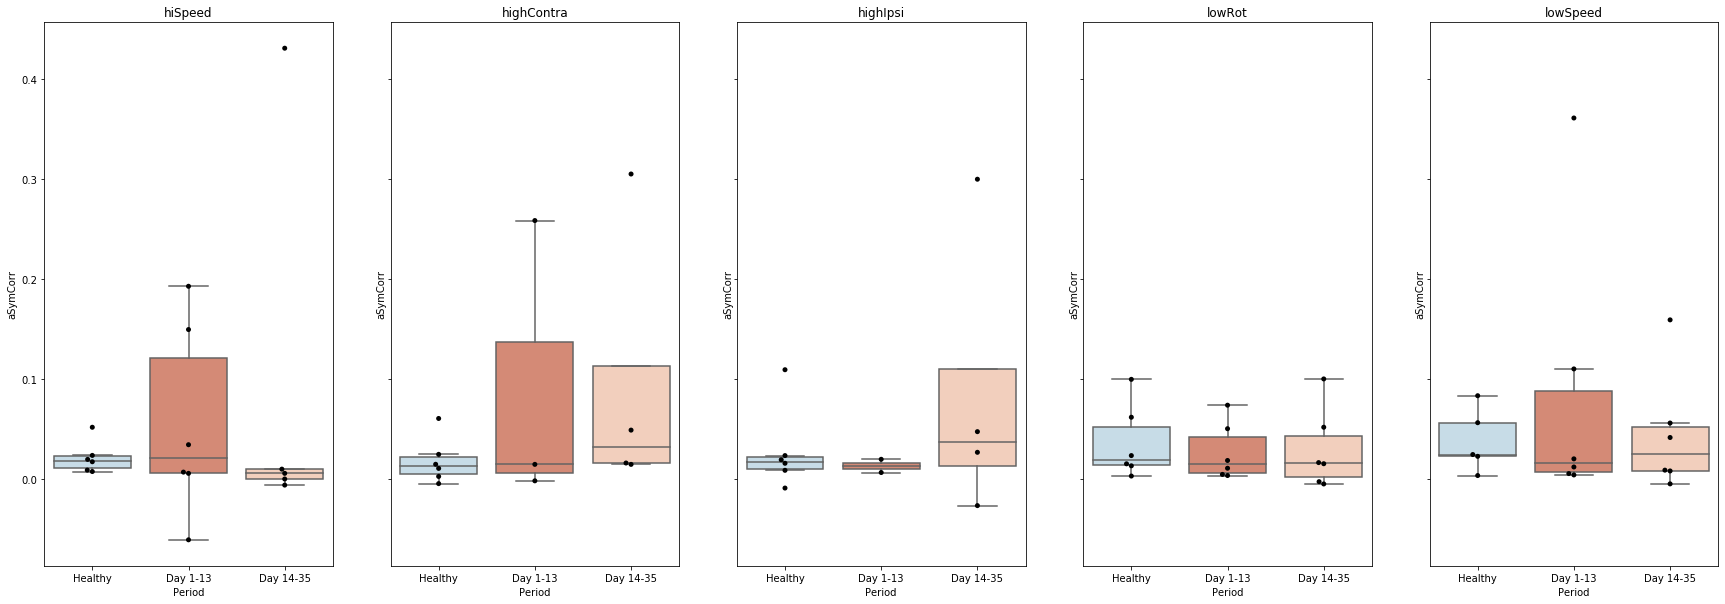

In [260]:
df = pd.read_csv(figFolder+ 'mvmtCorrSig.csv')
fig, ax  = plt.subplots(1,5,figsize=(30, 10),sharey = True)
indF = 0;
df = df.groupby(['population','mvmt','Period','Mouse']).mean()
df = df.reset_index()
for mvmt in df.mvmt.unique():
    with sns.color_palette(colorPallet3):
        sns.boxplot(x="Period", y="aSymCorr",ax = ax[indF],data=df[(df.population == "MSN-PV")&(df.mvmt == mvmt)], order = ['Healthy', 'Day 1-13', 'Day 14-35'], showfliers = False)
        sns.swarmplot(x="Period", y="aSymCorr",ax = ax[indF],color='black',
                      data=df[(df.population == "MSN-PV")&(df.mvmt == mvmt)], order = ['Healthy', 'Day 1-13', 'Day 14-35'])#, showfliers = False)
        ax[indF].set_title(mvmt)
#         ax[indF].set_ylim(-0.06,0.06)
        indF = indF + 1
# fig.savefig(figFolder+'figureS5.svg',format='svg')
# ax[0].set_ylim(-0.2,0.4)
fig.savefig(figFolder+'figureS5_PVMSN_mouse.svg',format='svg')
# fig, ax  = plt.subplots(1,5,figsize=(30, 10),sharey = True)
# indF = 0;
# for p in df.Period.unique():
    
#     sns.boxplot(x="mvmt", y="aSymCorr",ax = ax[indF],data=df[(df.population == "MSN-MSN")&(df.Period == p)], order = ['hiSpeed', 'lowSpeed', 'lowRot', 'highIpsi', 'highContra'], showfliers = False)
#     ax[indF].set_title(p)
#     indF = indF + 1


In [ ]:
#hi,bi = np.histogram(c[~np.isnan(c)],np.arange(-1,1,0.01))
# plt.plot(bi[1:],hi/np.sum(hi))
# col = ['Mouse','Sess','Day','numred','Period','population','mvmt','values']
# df = pd.DataFrame(columns = col)
df = df.append({'Mouse':1,'Sess':2,'Day':3,'numred':2,'Period':2,'population':2,'mvmt':2,'values':hi},ignore_index=True
)
df


In [74]:
"JUMP HERE"
f = h5py.File('J:\\connactivityAnalysis\\connMapsMvmt.hdf5','r')
col_names = ['Mouse','Sess','Day','numred','Period','population','mvmt','personF','sPersonF']
df = pd.DataFrame(columns = col_names)
# df3 = pd.DataFrame(columns = ['Mouse','Sess','Day','numred','Period','population','mvmt','values'])
dist = {"MSN-MSN":[],"MSN-CHI":[],"MSN-PV":[]}
for m in tqdm(f.keys()):
    for sess in f[m].keys():
        for mvmt in f[m][sess]['Pre'].keys():
            try:
                numred = f[m][sess].attrs['numRed']
                cre = getCreType(Files[1],m)
                tempDict = {'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
                                    'numred':numred,'Period':periodCalc(f[m][sess].attrs['day'])}

                c = f[m][sess]['Pre'][mvmt]['Jaccard'].value 
                c[(np.tril(np.ones(c.shape),-1))==0] = np.nan

                d = f[m][sess]['Pre'][mvmt][('Jaccard_shuffle')].value
                b = np.nanpercentile(d,[97.5,2.5],axis=2)
                d = np.nanmean(d,axis=2)
                d[(np.tril(np.ones(d.shape),-1))==0] = np.nan
                
                nSig = (c>b[0,:,:])|(c<b[1,:,:])
                cSig = np.copy(c)
                cSig[~nSig] = np.nan
                noSig = np.copy(c)
                noSig[nSig] = np.nan

                if numred > 1:
                    tempDict['population'] = cre+'-'+cre
                    tempDict['mvmt'] = mvmt
                    tempDict['aSymCorr'] = np.nanmean(c[:numred,:numred])
                    tempDict['sASymCorr'] = np.nanmean(d[:numred,:numred])
                    tempDict['aSymCorrSig'] = np.nanmean(cSig[:numred,:numred])
                    tempDict['aSymCorrNotSig'] = np.nanmean(noSig[:numred,:numred])
                    tempDict['sigPercent'] = np.nansum(nSig[:numred,:numred]==1)/np.nansum(np.isnan(c[:numred,:numred])==0)
                    df2 = pd.DataFrame([tempDict])
                    df = pd.concat([df,df2],sort=True)
                if numred > 0:
                    tempDict['mvmt'] = mvmt
                    tempDict['population'] = 'MSN-'+cre
                    tempDict['aSymCorr'] = np.nanmean(c[numred:,:numred])
                    tempDict['sASymCorr'] = np.nanmean(d[numred:,:numred])
                    tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,:numred])
                    tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,:numred])
                    tempDict['sigPercent'] = np.nansum(nSig[numred:,:numred]==1)/np.nansum(np.isnan(c[numred:,:numred])==0)

                    df2 = pd.DataFrame([tempDict])
                    df = pd.concat([df,df2],sort=True)
#                     hi,bi = np.histogram(c[numred:,:numred],np.arange(-1,1,0.01))
#                     hi2,bi2 = np.histogram(cSig[numred:,:numred],np.arange(-1,1,0.01))
#                     df3 = df3.append({'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
#                                     'numred':numred,'Period':periodCalc(f[m][sess].attrs['day']),
#                                       'population':'MSN-'+cre,'mvmt':mvmt,'values':hi,'values_sig':hi2},ignore_index=True)

                    
                
                tempDict['mvmt'] = mvmt
                tempDict['population'] = 'MSN-MSN'
                tempDict['aSymCorr'] = np.nanmean(c[numred:,numred:])
                tempDict['sASymCorr'] = np.nanmean(d[numred:,numred:])
                tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,numred:])
                tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,numred:])
                tempDict['sigPercent'] = np.nansum(nSig[numred:,numred:]==1)/np.nansum(np.isnan(c[numred:,numred:])==0)
#                 hi,bi = np.histogram(c[numred:,numred:],np.arange(-1,1,0.01))
#                 hi2,bi2 = np.histogram(cSig[numred:,numred:],np.arange(-1,1,0.01))
#                 df3 = df3.append({'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
#                                 'numred':numred,'Period':periodCalc(f[m][sess].attrs['day']),
#                                   'population':'MSN-MSN','mvmt':mvmt,'values':hi,'values_sig':hi2},ignore_index=True)
                df2 = pd.DataFrame([tempDict])
                df = pd.concat([df,df2],sort=True)
            except Exception as e:
                exc_type, exc_obj, exc_tb = sys.exc_info()
                print(sess,'-',mvmt,exc_tb.tb_lineno,c.shape)
f.close()
df.to_csv(figFolder+'mvmtCorrSig.csv')
# df3.to_csv(figFolder+'mvmtCorrSig_hists.csv')

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]<ipython-input-74-104318fdd086>:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  c = f[m][sess]['Pre'][mvmt]['Jaccard'].value
<ipython-input-74-104318fdd086>:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  d = f[m][sess]['Pre'][mvmt][('Jaccard_shuffle')].value
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-74-104318fdd086>:21: RuntimeWarning: Mean of empty slice
  d = np.nanmean(d,axis=2)
<ipython-input-74-104318fdd086>:45: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,:numred])
<ipython-input-74-104318fdd086>:63: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,n

0761_day1 - hiSpeed 17 ()
0761_day1 - highContra 17 ()
0761_day1 - highIpsi 17 ()
0761_day1 - lowRot 17 ()
0761_day1 - lowSpeed 17 ()
0761_day1 - totRot 17 ()


<ipython-input-74-104318fdd086>:61: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorr'] = np.nanmean(c[numred:,numred:])
<ipython-input-74-104318fdd086>:62: RuntimeWarning: Mean of empty slice
  tempDict['sASymCorr'] = np.nanmean(d[numred:,numred:])
<ipython-input-74-104318fdd086>:64: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,numred:])
<ipython-input-74-104318fdd086>:65: RuntimeWarning: invalid value encountered in long_scalars
  tempDict['sigPercent'] = np.nansum(nSig[numred:,numred:]==1)/np.nansum(np.isnan(c[numred:,numred:])==0)
<ipython-input-74-104318fdd086>:35: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorrSig'] = np.nanmean(cSig[:numred,:numred])


0761_day31A - highIpsi 17 ()
0761_day35L - hiSpeed 17 ()
0761_day35L - highIpsi 17 ()


<ipython-input-74-104318fdd086>:43: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorr'] = np.nanmean(c[numred:,:numred])
<ipython-input-74-104318fdd086>:44: RuntimeWarning: Mean of empty slice
  tempDict['sASymCorr'] = np.nanmean(d[numred:,:numred])
<ipython-input-74-104318fdd086>:46: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,:numred])
<ipython-input-74-104318fdd086>:47: RuntimeWarning: invalid value encountered in long_scalars
  tempDict['sigPercent'] = np.nansum(nSig[numred:,:numred]==1)/np.nansum(np.isnan(c[numred:,:numred])==0)
  6%|█████▏                                                                             | 1/16 [00:02<00:33,  2.26s/it]<ipython-input-74-104318fdd086>:33: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorr'] = np.nanmean(c[:numred,:numred])
<ipython-input-74-104318fdd086>:34: RuntimeWarning: Mean of empty slice
  tempDict['sASymCorr'] = np.nanmean(d[:numred,:numred])
<ipython-input-74-104318fdd08

1208_day2 - highIpsi 17 ()
1208_day30A - highIpsi 17 ()
1208_day34L - highIpsi 17 ()


 25%|████████████████████▊                                                              | 4/16 [06:25<13:57, 69.79s/it]

1236_day15A - highContra 17 ()
1236_day19L - highContra 17 ()
1236_day30A - highContra 17 ()


 50%|█████████████████████████████████████████                                         | 8/16 [21:06<24:35, 184.46s/it]

2980_day19L - highIpsi 17 ()


 56%|██████████████████████████████████████████████▏                                   | 9/16 [22:13<17:23, 149.03s/it]

2981_day2 - highContra 17 ()


 62%|██████████████████████████████████████████████████▋                              | 10/16 [25:17<15:57, 159.67s/it]

4539_day1 - highContra 17 ()
4539_day1 - highIpsi 17 ()
4539_day1 - totRot 17 ()
4539_day10 - highContra 17 ()
4539_day10 - highIpsi 17 ()
4539_day10 - totRot 17 ()
4539_day11 - highContra 17 ()
4539_day11 - highIpsi 17 ()
4539_day11 - totRot 17 ()
4539_day12 - highContra 17 ()
4539_day12 - highIpsi 17 ()
4539_day12 - totRot 17 ()
4539_day13 - highContra 17 ()
4539_day13 - highIpsi 17 ()
4539_day13 - totRot 17 ()
4539_day14 - highContra 17 ()
4539_day14 - highIpsi 17 ()
4539_day14 - totRot 17 ()
4539_day2 - highContra 17 ()
4539_day2 - highIpsi 17 ()
4539_day2 - totRot 17 ()
4539_day3 - highContra 17 ()
4539_day3 - highIpsi 17 ()
4539_day3 - totRot 17 ()
4539_day4 - highContra 17 ()
4539_day4 - highIpsi 17 ()
4539_day4 - totRot 17 ()
4539_day5 - highContra 17 ()
4539_day5 - highIpsi 17 ()
4539_day5 - totRot 17 ()
4539_day6 - highContra 17 ()
4539_day6 - highIpsi 17 ()
4539_day6 - totRot 17 ()
4539_day7 - highContra 17 ()
4539_day7 - highIpsi 17 ()
4539_day7 - totRot 17 ()
4539_day8 - h

 69%|███████████████████████████████████████████████████████▋                         | 11/16 [28:41<14:24, 172.95s/it]

4539_day9 - totRot 17 ()
7584_day1 - highContra 17 ()
7584_day1 - highIpsi 17 ()
7584_day1 - totRot 17 ()
7584_day10 - highContra 17 ()
7584_day10 - highIpsi 17 ()
7584_day10 - totRot 17 ()
7584_day11 - highContra 17 ()
7584_day11 - highIpsi 17 ()
7584_day11 - totRot 17 ()
7584_day12 - highContra 17 ()
7584_day12 - highIpsi 17 ()
7584_day12 - totRot 17 ()
7584_day15 - highContra 17 ()
7584_day15 - highIpsi 17 ()
7584_day15 - totRot 17 ()
7584_day2 - highContra 17 ()
7584_day2 - highIpsi 17 ()
7584_day2 - totRot 17 ()
7584_day3 - highContra 17 ()
7584_day3 - highIpsi 17 ()
7584_day3 - totRot 17 ()
7584_day4 - highContra 17 ()
7584_day4 - highIpsi 17 ()
7584_day4 - totRot 17 ()
7584_day5 - highContra 17 ()
7584_day5 - highIpsi 17 ()
7584_day5 - totRot 17 ()
7584_day6 - highContra 17 ()
7584_day6 - highIpsi 17 ()
7584_day6 - totRot 17 ()
7584_day7 - highContra 17 ()
7584_day7 - highIpsi 17 ()
7584_day7 - totRot 17 ()
7584_day8 - highContra 17 ()
7584_day8 - highIpsi 17 ()
7584_day8 - totR

 75%|████████████████████████████████████████████████████████████▊                    | 12/16 [42:39<24:49, 372.49s/it]

7584_day9 - totRot 17 ()
7909_day1 - highContra 17 ()
7909_day1 - highIpsi 17 ()
7909_day1 - totRot 17 ()
7909_day10 - highContra 17 ()
7909_day10 - highIpsi 17 ()
7909_day10 - totRot 17 ()
7909_day11 - hiSpeed 17 ()
7909_day11 - highContra 17 ()
7909_day11 - highIpsi 17 ()
7909_day11 - totRot 17 ()
7909_day12 - highContra 17 ()
7909_day12 - highIpsi 17 ()
7909_day12 - totRot 17 ()
7909_day13 - highContra 17 ()
7909_day13 - highIpsi 17 ()
7909_day13 - totRot 17 ()
7909_day14 - highContra 17 ()
7909_day14 - highIpsi 17 ()
7909_day14 - totRot 17 ()
7909_day2 - highContra 17 ()
7909_day2 - highIpsi 17 ()
7909_day2 - totRot 17 ()
7909_day3 - highContra 17 ()
7909_day3 - highIpsi 17 ()
7909_day3 - totRot 17 ()
7909_day4 - highContra 17 ()
7909_day4 - highIpsi 17 ()
7909_day4 - totRot 17 ()
7909_day5 - hiSpeed 17 ()
7909_day5 - highContra 17 ()
7909_day5 - highIpsi 17 ()
7909_day5 - totRot 17 ()
7909_day6 - highContra 17 ()
7909_day6 - highIpsi 17 ()
7909_day6 - totRot 17 ()
7909_day7 - high

 81%|█████████████████████████████████████████████████████████████████▊               | 13/16 [45:58<16:00, 320.25s/it]

7909_day9 - highContra 17 ()
7909_day9 - highIpsi 17 ()
7909_day9 - totRot 17 ()


 88%|██████████████████████████████████████████████████████████████████████▉          | 14/16 [48:38<09:04, 272.28s/it]

8803_BaselineL - highContra 17 ()
8803_day34L - highIpsi 17 ()


 94%|███████████████████████████████████████████████████████████████████████████▉     | 15/16 [50:14<03:39, 219.55s/it]

8815_day6 - highIpsi 17 ()


100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [50:54<00:00, 190.88s/it]


In [117]:
"JUMP HERE"
f = h5py.File('J:\\connactivityAnalysis\\connMapsMvmt.hdf5','r')
g = h5py.File('J:\\connactivityAnalysis\\connMaps.hdf5','r')
col_names = ['Mouse','Sess','Day','numred','Period','population','mvmt','personF','sPersonF']
df = pd.DataFrame(columns = col_names)
# df3 = pd.DataFrame(columns = ['Mouse','Sess','Day','numred','Period','population','mvmt','values'])
dist = {"MSN-MSN":[],"MSN-CHI":[],"MSN-PV":[]}
for m in tqdm(f.keys()):
    for sess in f[m].keys():
        for corType in ['pearson','Jaccard']:
            try:
                numred = g[m][sess].attrs['numRed']
                cre = getCreType(Files[1],m)
                tempDict = {'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],'mvmt':'all','corType':corType,
                                    'numred':numred,'Period':periodCalc(f[m][sess].attrs['day'])}

                c = g[m][sess]['Pre'][corType].value 
                c[(np.tril(np.ones(c.shape),-1))==0] = np.nan

                d = g[m][sess]['Pre'][(corType+'_shuffle')].value
                b = np.nanpercentile(d,[97.5,2.5],axis=2)
                d = np.nanmean(d,axis=2)
                d[(np.tril(np.ones(d.shape),-1))==0] = np.nan

                nSig_pos = (c>b[0,:,:])
                cSig_pos = np.copy(c)
                cSig_pos[~nSig_pos] = np.nan

                nSig_neg = (c<b[1,:,:])
                cSig_neg = np.copy(c)
                cSig_neg[~nSig_neg] = np.nan

                if numred > 1:
                    tempDict['population'] = cre+'-'+cre
                    tempDict['posCorr'] = np.nanmean(cSig_pos[:numred,:numred])
                    tempDict['sMeanCorr'] = np.nanmean(d[:numred,:numred])
                    tempDict['negCorr'] = np.nanmean(cSig_neg[:numred,:numred])
                    tempDict['posPercent'] = np.nanmean(nSig_pos[:numred,:numred])
                    tempDict['negPercent'] = np.nanmean(nSig_neg[:numred,:numred])
                    negSum = np.nansum(nSig_neg[:numred,:numred]==1)
                    totSum = negSum+np.nansum(nSig_pos[:numred,:numred]==1)
                    tempDict['negPercentOfSig'] =negSum /totSum

                    df2 = pd.DataFrame([tempDict])
                    df = pd.concat([df,df2],sort=True)
                if numred > 0:
                    tempDict['population'] = 'MSN-'+cre
                    tempDict['posCorr'] = np.nanmean(cSig_pos[numred:,:numred])
                    tempDict['sMeanCorr'] = np.nanmean(d[numred:,:numred])
                    tempDict['negCorr'] = np.nanmean(cSig_neg[numred:,:numred])
                    tempDict['posPercent'] = np.nanmean(nSig_pos[numred:,:numred])
                    tempDict['negPercent'] = np.nanmean(nSig_neg[numred:,:numred])
                    negSum = np.nansum(nSig_neg[numred:,:numred]==1)
                    totSum = negSum+np.nansum(nSig_pos[numred:,:numred]==1)
                    tempDict['negPercentOfSig'] =negSum /totSum

                    df2 = pd.DataFrame([tempDict])
                    df = pd.concat([df,df2],sort=True)


                tempDict['population'] = 'MSN-MSN'
                tempDict['posCorr'] = np.nanmean(cSig_pos[numred:,numred:])
                tempDict['sMeanCorr'] = np.nanmean(d[numred:,numred:])
                tempDict['negCorr'] = np.nanmean(cSig_neg[numred:,numred:])
                tempDict['posPercent'] = np.nanmean(nSig_pos[numred:,numred:])
                tempDict['negPercent'] = np.nanmean(nSig_neg[numred:,numred:])
                negSum = np.nansum(nSig_neg[numred:,numred:]==1)
                totSum = negSum+np.nansum(nSig_pos[numred:,numred:]==1)
                tempDict['negPercentOfSig'] =negSum /totSum


                df2 = pd.DataFrame([tempDict])
                df = pd.concat([df,df2],sort=True)
            except Exception as e:
                exc_type, exc_obj, exc_tb = sys.exc_info()
                print(sess,'-',mvmt,exc_tb.tb_lineno,c.shape)

            for mvmt in f[m][sess]['Pre'].keys():
                try:
                    numred = f[m][sess].attrs['numRed']
                    cre = getCreType(Files[1],m)
                    tempDict = {'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],'corType':corType,
                                        'numred':numred,'Period':periodCalc(f[m][sess].attrs['day'])}

                    c = f[m][sess]['Pre'][mvmt][corType].value 
                    c[(np.tril(np.ones(c.shape),-1))==0] = np.nan

                    d = f[m][sess]['Pre'][mvmt][(corType+'_shuffle')].value
                    b = np.nanpercentile(d,[97.5,2.5],axis=2)
                    d = np.nanmean(d,axis=2)
                    d[(np.tril(np.ones(d.shape),-1))==0] = np.nan

                    nSig_pos = (c>b[0,:,:])
                    cSig_pos = np.copy(c)
                    cSig_pos[~nSig_pos] = np.nan

                    nSig_neg = (c<b[1,:,:])
                    cSig_neg = np.copy(c)
                    cSig_neg[~nSig_neg] = np.nan

                    if numred > 1:
                        tempDict['population'] = cre+'-'+cre
                        tempDict['mvmt'] = mvmt
                        tempDict['posCorr'] = np.nanmean(cSig_pos[:numred,:numred])
                        tempDict['sMeanCorr'] = np.nanmean(d[:numred,:numred])
                        tempDict['negCorr'] = np.nanmean(cSig_neg[:numred,:numred])
                        tempDict['posPercent'] = np.nanmean(nSig_pos[:numred,:numred])
                        tempDict['negPercent'] = np.nanmean(nSig_neg[:numred,:numred])
                        negSum = np.nansum(nSig_neg[:numred,:numred]==1)
                        totSum = negSum+np.nansum(nSig_pos[:numred,:numred]==1)
                        tempDict['negPercentOfSig'] =negSum /totSum

                        df2 = pd.DataFrame([tempDict])
                        df = pd.concat([df,df2],sort=True)
                    if numred > 0:
                        tempDict['mvmt'] = mvmt
                        tempDict['population'] = 'MSN-'+cre
                        tempDict['posCorr'] = np.nanmean(cSig_pos[numred:,:numred])
                        tempDict['sMeanCorr'] = np.nanmean(d[numred:,:numred])
                        tempDict['negCorr'] = np.nanmean(cSig_neg[numred:,:numred])
                        tempDict['posPercent'] = np.nanmean(nSig_pos[numred:,:numred])
                        tempDict['negPercent'] = np.nanmean(nSig_neg[numred:,:numred])
                        negSum = np.nansum(nSig_neg[numred:,:numred]==1)
                        totSum = negSum+np.nansum(nSig_pos[numred:,:numred]==1)
                        tempDict['negPercentOfSig'] =negSum /totSum

                        df2 = pd.DataFrame([tempDict])
                        df = pd.concat([df,df2],sort=True)



                    tempDict['mvmt'] = mvmt
                    tempDict['population'] = 'MSN-MSN'
                    tempDict['posCorr'] = np.nanmean(cSig_pos[numred:,numred:])
                    tempDict['sMeanCorr'] = np.nanmean(d[numred:,numred:])
                    tempDict['negCorr'] = np.nanmean(cSig_neg[numred:,numred:])
                    tempDict['posPercent'] = np.nanmean(nSig_pos[numred:,numred:])
                    tempDict['negPercent'] = np.nanmean(nSig_neg[numred:,numred:])
                    negSum = np.nansum(nSig_neg[numred:,numred:]==1)
                    totSum = negSum+np.nansum(nSig_pos[numred:,numred:]==1)
                    tempDict['negPercentOfSig'] =negSum /totSum


                    df2 = pd.DataFrame([tempDict])
                    df = pd.concat([df,df2],sort=True)
                except Exception as e:
                    exc_type, exc_obj, exc_tb = sys.exc_info()
                    print(sess,'-',mvmt,exc_tb.tb_lineno,c.shape)
f.close()
df.to_csv(figFolder+'mvmtCorrSig_neg.csv')
# df3.to_csv(figFolder+'mvmtCorrSig_hists.csv')

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]<ipython-input-117-17488555c5bf>:17: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  c = g[m][sess]['Pre'][corType].value
<ipython-input-117-17488555c5bf>:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  d = g[m][sess]['Pre'][(corType+'_shuffle')].value
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-117-17488555c5bf>:22: RuntimeWarning: Mean of empty slice
  d = np.nanmean(d,axis=2)
<ipython-input-117-17488555c5bf>:50: RuntimeWarning: Mean of empty slice
  tempDict['negCorr'] = np.nanmean(cSig_neg[numred:,:numred])
<ipython-input-117-17488555c5bf>:64: RuntimeWarning: Mean of empty slice
  tempDict['negCorr'] = np.nanmean(cSig_neg[numred:,numred:])

0761_day1 - totRot 25 (0, 0)
0761_day1 - hiSpeed 86 ()
0761_day1 - highContra 86 ()
0761_day1 - highIpsi 86 ()
0761_day1 - lowRot 86 ()
0761_day1 - lowSpeed 86 ()
0761_day1 - totRot 86 ()


<ipython-input-117-17488555c5bf>:35: RuntimeWarning: Mean of empty slice
  tempDict['posCorr'] = np.nanmean(cSig_pos[:numred,:numred])
<ipython-input-117-17488555c5bf>:37: RuntimeWarning: Mean of empty slice
  tempDict['negCorr'] = np.nanmean(cSig_neg[:numred,:numred])
<ipython-input-117-17488555c5bf>:42: RuntimeWarning: invalid value encountered in long_scalars
  tempDict['negPercentOfSig'] =negSum /totSum
<ipython-input-117-17488555c5bf>:104: RuntimeWarning: Mean of empty slice
  tempDict['posCorr'] = np.nanmean(cSig_pos[:numred,:numred])
<ipython-input-117-17488555c5bf>:105: RuntimeWarning: Mean of empty slice
  tempDict['sMeanCorr'] = np.nanmean(d[:numred,:numred])
<ipython-input-117-17488555c5bf>:106: RuntimeWarning: Mean of empty slice
  tempDict['negCorr'] = np.nanmean(cSig_neg[:numred,:numred])
<ipython-input-117-17488555c5bf>:111: RuntimeWarning: invalid value encountered in long_scalars
  tempDict['negPercentOfSig'] =negSum /totSum


0761_day31A - highIpsi 86 ()
0761_day31A - highIpsi 86 ()
0761_day35L - hiSpeed 86 ()
0761_day35L - highIpsi 86 ()
0761_day35L - hiSpeed 86 ()
0761_day35L - highIpsi 86 ()


<ipython-input-117-17488555c5bf>:48: RuntimeWarning: Mean of empty slice
  tempDict['posCorr'] = np.nanmean(cSig_pos[numred:,:numred])
<ipython-input-117-17488555c5bf>:49: RuntimeWarning: Mean of empty slice
  tempDict['sMeanCorr'] = np.nanmean(d[numred:,:numred])
<ipython-input-117-17488555c5bf>:55: RuntimeWarning: invalid value encountered in long_scalars
  tempDict['negPercentOfSig'] =negSum /totSum
  6%|█████▏                                                                             | 1/16 [00:07<01:51,  7.43s/it]<ipython-input-117-17488555c5bf>:36: RuntimeWarning: Mean of empty slice
  tempDict['sMeanCorr'] = np.nanmean(d[:numred,:numred])


1208_day2 - highIpsi 86 ()
1208_day2 - highIpsi 86 ()
1208_day30A - highIpsi 86 ()
1208_day30A - highIpsi 86 ()
1208_day34L - highIpsi 86 ()
1208_day34L - highIpsi 86 ()


 12%|██████████▎                                                                       | 2/16 [11:29<48:56, 209.76s/it]

1222_day2 - totRot 18 ()
1222_day2 - hiSpeed 86 ()
1222_day2 - highContra 86 ()
1222_day2 - highIpsi 86 ()
1222_day2 - lowRot 86 ()
1222_day2 - lowSpeed 86 ()
1222_day2 - totRot 86 ()


 25%|████████████████████▌                                                             | 4/16 [15:11<32:56, 164.70s/it]

1236_day15A - highContra 86 ()
1236_day15A - highContra 86 ()
1236_day19L - highContra 86 ()
1236_day19L - highContra 86 ()
1236_day30A - highContra 86 ()
1236_day30A - highContra 86 ()


 50%|████████████████████████████████████████                                        | 8/16 [54:07<1:07:46, 508.26s/it]

2980_day19L - highIpsi 86 ()
2980_day19L - highIpsi 86 ()


 56%|██████████████████████████████████████████████▏                                   | 9/16 [57:16<48:07, 412.51s/it]

2981_day2 - highContra 86 ()
2981_day2 - highContra 86 ()


 62%|█████████████████████████████████████████████████▍                             | 10/16 [1:06:25<45:20, 453.47s/it]

4539_day1 - highContra 86 ()
4539_day1 - highIpsi 86 ()
4539_day1 - totRot 86 ()
4539_day1 - highContra 86 ()
4539_day1 - highIpsi 86 ()
4539_day1 - totRot 86 ()
4539_day10 - highContra 86 ()
4539_day10 - highIpsi 86 ()
4539_day10 - totRot 86 ()
4539_day10 - highContra 86 ()
4539_day10 - highIpsi 86 ()
4539_day10 - totRot 86 ()
4539_day11 - highContra 86 ()
4539_day11 - highIpsi 86 ()
4539_day11 - totRot 86 ()
4539_day11 - highContra 86 ()
4539_day11 - highIpsi 86 ()
4539_day11 - totRot 86 ()
4539_day12 - highContra 86 ()
4539_day12 - highIpsi 86 ()
4539_day12 - totRot 86 ()
4539_day12 - highContra 86 ()
4539_day12 - highIpsi 86 ()
4539_day12 - totRot 86 ()
4539_day13 - highContra 86 ()
4539_day13 - highIpsi 86 ()
4539_day13 - totRot 86 ()
4539_day13 - highContra 86 ()
4539_day13 - highIpsi 86 ()
4539_day13 - totRot 86 ()
4539_day14 - highContra 86 ()
4539_day14 - highIpsi 86 ()
4539_day14 - totRot 86 ()
4539_day14 - highContra 86 ()
4539_day14 - highIpsi 86 ()
4539_day14 - totRot 86 (

 69%|██████████████████████████████████████████████████████▎                        | 11/16 [1:14:51<39:06, 469.40s/it]

4539_day9 - totRot 86 ()
7584_day1 - highContra 86 ()
7584_day1 - highIpsi 86 ()
7584_day1 - totRot 86 ()
7584_day1 - highContra 86 ()
7584_day1 - highIpsi 86 ()
7584_day1 - totRot 86 ()
7584_day10 - highContra 86 ()
7584_day10 - highIpsi 86 ()
7584_day10 - totRot 86 ()
7584_day10 - highContra 86 ()
7584_day10 - highIpsi 86 ()
7584_day10 - totRot 86 ()
7584_day11 - highContra 86 ()
7584_day11 - highIpsi 86 ()
7584_day11 - totRot 86 ()
7584_day11 - highContra 86 ()
7584_day11 - highIpsi 86 ()
7584_day11 - totRot 86 ()
7584_day12 - highContra 86 ()
7584_day12 - highIpsi 86 ()
7584_day12 - totRot 86 ()
7584_day12 - highContra 86 ()
7584_day12 - highIpsi 86 ()
7584_day12 - totRot 86 ()
7584_day15 - highContra 86 ()
7584_day15 - highIpsi 86 ()
7584_day15 - totRot 86 ()
7584_day15 - highContra 86 ()
7584_day15 - highIpsi 86 ()
7584_day15 - totRot 86 ()
7584_day2 - highContra 86 ()
7584_day2 - highIpsi 86 ()
7584_day2 - totRot 86 ()
7584_day2 - highContra 86 ()
7584_day2 - highIpsi 86 ()
7584

 75%|█████████████████████████████████████████████████████████                   | 12/16 [1:53:54<1:08:45, 1031.38s/it]

7584_day9 - totRot 86 ()
7909_day1 - highContra 86 ()
7909_day1 - highIpsi 86 ()
7909_day1 - totRot 86 ()
7909_day1 - highContra 86 ()
7909_day1 - highIpsi 86 ()
7909_day1 - totRot 86 ()
7909_day10 - highContra 86 ()
7909_day10 - highIpsi 86 ()
7909_day10 - totRot 86 ()
7909_day10 - highContra 86 ()
7909_day10 - highIpsi 86 ()
7909_day10 - totRot 86 ()
7909_day11 - hiSpeed 86 ()
7909_day11 - highContra 86 ()
7909_day11 - highIpsi 86 ()
7909_day11 - totRot 86 ()
7909_day11 - hiSpeed 86 ()
7909_day11 - highContra 86 ()
7909_day11 - highIpsi 86 ()
7909_day11 - totRot 86 ()


C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


7909_day12 - highContra 86 ()
7909_day12 - highIpsi 86 ()
7909_day12 - totRot 86 ()
7909_day12 - highContra 86 ()
7909_day12 - highIpsi 86 ()
7909_day12 - totRot 86 ()
7909_day13 - highContra 86 ()
7909_day13 - highIpsi 86 ()
7909_day13 - totRot 86 ()
7909_day13 - highContra 86 ()
7909_day13 - highIpsi 86 ()
7909_day13 - totRot 86 ()
7909_day14 - highContra 86 ()
7909_day14 - highIpsi 86 ()
7909_day14 - totRot 86 ()
7909_day14 - highContra 86 ()
7909_day14 - highIpsi 86 ()
7909_day14 - totRot 86 ()
7909_day2 - highContra 86 ()
7909_day2 - highIpsi 86 ()
7909_day2 - totRot 86 ()
7909_day2 - highContra 86 ()
7909_day2 - highIpsi 86 ()
7909_day2 - totRot 86 ()
7909_day3 - highContra 86 ()
7909_day3 - highIpsi 86 ()
7909_day3 - totRot 86 ()
7909_day3 - highContra 86 ()
7909_day3 - highIpsi 86 ()
7909_day3 - totRot 86 ()
7909_day4 - highContra 86 ()
7909_day4 - highIpsi 86 ()
7909_day4 - totRot 86 ()
7909_day4 - highContra 86 ()
7909_day4 - highIpsi 86 ()
7909_day4 - totRot 86 ()
7909_day5 

 81%|████████████████████████████████████████████████████████████████▏              | 13/16 [2:03:45<44:57, 899.32s/it]

7909_day9 - totRot 86 ()
7909_day9 - highContra 86 ()
7909_day9 - highIpsi 86 ()
7909_day9 - totRot 86 ()


 88%|█████████████████████████████████████████████████████████████████████▏         | 14/16 [2:10:30<25:01, 750.85s/it]

8803_BaselineL - highContra 86 ()
8803_BaselineL - highContra 86 ()
8803_day34L - highIpsi 86 ()
8803_day34L - highIpsi 86 ()


 94%|██████████████████████████████████████████████████████████████████████████     | 15/16 [2:14:22<09:55, 595.15s/it]

8815_day6 - highIpsi 86 ()
8815_day6 - highIpsi 86 ()


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [2:16:22<00:00, 511.43s/it]


In [377]:
rCa[n,np.random.randint(size=int(events[n]),low=0,high=np.max(rCa.shape)-1)] = 1

In [378]:
col_names = ['Mouse','Sess','Day','Period',]
df = pd.DataFrame(columns = col_names)
numshifts = 1000
f = h5py.File('J:\\connactivityAnalysis\\connMaps.hdf5','r')

for m in tqdm(f.keys()):
    for sess in f[m].keys():
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        for iterS in range(10):
            try:
                
                Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')     
                events = np.sum(Ca,axis=1)
                rCa = np.zeros(Ca.shape)
                for n in range(Ca.shape[0]):
                    rCa[n,np.random.randint(size=int(events[n]),low=0,high=np.max(rCa.shape)-1)] = 1
                
                c = np.corrcoef(rCa)


                d = np.empty((c.shape[0],c.shape[1],numshifts))
                for s in range(0,numshifts):
                    shifts = np.random.randint(size= rCa.shape[0],low=0,high=rCa.shape[1])
                    Ca2 = circShiftRoll(shifts,rCa)
                    d[:,:,s] = np.corrcoef(Ca2)


                tempDict = {'Mouse':m,'Sess':sess,'Period':periodCalc(day),'sIter':iterS}
 
                c[(np.tril(np.ones(c.shape),-1))==0] = np.nan
                b = np.nanpercentile(d,[97.5,2.5],axis=2)
                d = np.nanmean(d,axis=2)
                d[(np.tril(np.ones(d.shape),-1))==0] = np.nan

                nSig = (c>b[0,:,:])|(c<b[1,:,:])
                cSig = np.copy(c)
                cSig[~nSig] = np.nan
                noSig = np.copy(c)
                noSig[nSig] = np.nan
                
                tempDict['aSymCorr'] = np.nanmean(c)
                tempDict['sASymCorr'] = np.nanmean(d)
                tempDict['aSymCorrSig'] = np.nanmean(cSig)
                tempDict['aSymCorrNotSig'] = np.nanmean(noSig)
                tempDict['sigPercent'] = np.nanmean(nSig==1)

                df2 = pd.DataFrame([tempDict])
                df = pd.concat([df,df2],sort=True)
            except Exception as e:
                    exc_type, exc_obj, exc_tb = sys.exc_info()
                    print(sess,'-',mvmt,exc_tb.tb_lineno,c.shape)
f.close()
df.to_csv(figFolder+'corrSims.csv')

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]C:\Users\dzemel\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
<ipython-input-378-a0d8fefff1db>:35: RuntimeWarning: Mean of empty slice
  d = np.nanmean(d,axis=2)
<ipython-input-378-a0d8fefff1db>:44: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorr'] = np.nanmean(c)
<ipython-input-378-a0d8fefff1db>:45: RuntimeWarning: Mean of empty slice
  tempDict['sASymCorr'] = np.nanmean(d)
<ipython-input-378-a0d8fefff1db>:46: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorrSig'] = np.nanmean(cSig)
<ipython-input-378-a0d8fefff1db>:47: RuntimeWarning: Mean of empty slice
  tempDict['aSymCorrNotSig'] = np.nanmean(noSig)
 12%|█████████▋                                                                   | 2/16 [1:22:49<6:25:58, 1654.21s/it]

1222_day2 - all 24 ()
1222_day2 - all 24 ()
1222_day2 - all 24 ()
1222_day2 - all 24 ()
1222_day2 - all 24 ()
1222_day2 - all 24 ()
1222_day2 - all 24 ()
1222_day2 - all 24 ()
1222_day2 - all 24 ()
1222_day2 - all 24 ()


100%|█████████████████████████████████████████████████████████████████████████████| 16/16 [16:02:44<00:00, 3610.28s/it]


In [402]:
gc.collect()

4634684

count      mean       std       min       25%       50%       75%  \
Period                                                                       
Acute    103.0  0.010592  0.008083  0.000000  0.002824  0.008573  0.018809   
Chronic   62.0  0.012532  0.007893  0.000000  0.004865  0.013973  0.019515   
Healthy   48.0  0.017416  0.007285  0.000384  0.011209  0.020406  0.023411   

              max  
Period             
Acute    0.024445  
Chronic  0.024623  
Healthy  0.024980

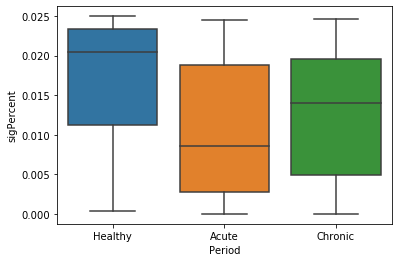

In [388]:
df2 = df.groupby(['Sess','Period']).mean().reset_index()
sns.boxplot(data=df2, x='Period',y='sigPercent')
df2.groupby('Period').sigPercent.describe()

(107, 107) (79, 79)


<IPython.core.display.Javascript object>


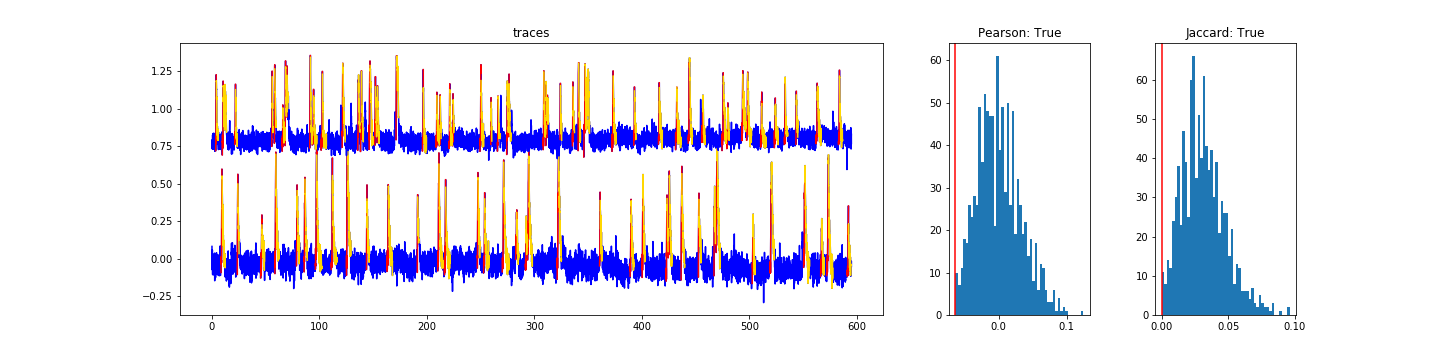

D:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


Text(0.5, 1.0, 'Jaccard: True')

In [187]:
g = h5py.File('J:\\connactivityAnalysis\\connMaps.hdf5','r')

m = '1208'
sess = '1208_day19L'
data = getData(Files[1],['trace'],period ='Pre',day =lambda day: (day==19), mice = [m])
Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf') 
eventRate = np.sum(Ca,axis=1)

c = g[m][sess]['Pre']['pearson'][:]
c2 = g[m][sess]['Pre']['Jaccard'][:]

print(c.shape,c2.shape)

d = g[m][sess]['Pre'][('pearson_shuffle')][:]
d2 = g[m][sess]['Pre'][('Jaccard_shuffle')][:]

b = np.nanpercentile(d,[97.5,2.5],axis=2)
nSig = (c<b[1,:,:])
b2 = np.nanpercentile(d2,[97.5,2.5],axis=2)
nSig2 = (c2<b2[1,:,:])

tInds = np.unravel_index(np.nanargmin(c),c.shape)
tInds2 = (tInds[0] - np.sum(eventRate[:tInds[0]]==0),tInds[1] - np.sum(eventRate[:tInds[1]]==0))

fig, ax = plt.subplots(1,3,figsize=(20,5),gridspec_kw={'width_ratios': [5,1,1]})
dff = data[sess]['trace']['dff']
Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf') 
Cf =getOnsetOrPeriod(m,sess,'Pre','caFall_Hf')  
ca = Ca*dff
cf = Cf*dff
ca[ca==0]=np.nan
cf[cf==0]=np.nan
t = np.arange(0,dff.shape[1])*0.05
for indn,n in enumerate(tInds):
    ax[0].plot(t,dff[n,:]+indn*spacing,color='blue',rasterized=True) 
    ax[0].plot(t,ca[n,:]+indn*spacing,color='red',rasterized=True)
    ax[0].plot(t,cf[n,:]+indn*spacing,color='gold',rasterized=True)
ax[0].set_title('traces')
ax[1].hist(d[tInds[0],tInds[1],:],50)
ax[1].axvline(x=c[tInds[0],tInds[1]],color='red')
ax[1].set_title('Pearson: '+"{}".format(nSig[tInds[0],tInds[1]]))
ax[2].hist(d2[tInds2[0],tInds2[1],:],50)
ax[2].axvline(x=c2[tInds2[0],tInds2[1]],color='red')
ax[2].set_title('Jaccard: '+"{}".format(nSig2[tInds2[0],tInds2[1]]))


In [63]:
g = h5py.File('J:\\connactivityAnalysis\\connMaps.hdf5','r')

m = '1208'
sess = '1208_day19L'
data = getData(Files[1],['trace'],period ='Pre',day =lambda day: (day==19), mice = [m])
Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf') 
eventRate = np.sum(Ca,axis=1)
shift = np.cumsum(eventRate>0)

c = g[m][sess]['Pre']['pearson'][:]
c2 = g[m][sess]['Pre']['Jaccard'][:]

print(c.shape,c2.shape)

d = g[m][sess]['Pre'][('pearson_shuffle')][:]
d2 = g[m][sess]['Pre'][('Jaccard_shuffle')][:]

b = np.nanpercentile(d,[97.5,2.5],axis=2)
nSig = (c>b[0,:,:])
b2 = np.nanpercentile(d2,[97.5,2.5],axis=2)
nSig2 = (c2>b2[0,:,:])

C0 = nSig[eventRate>0,:][:,eventRate>0]
C = 1*C0+1*(~nSig2)
Ilist = np.argwhere(C==2)
Ilist2 = Ilist.copy()
bestPair = np.zeros((Ilist.shape[0]))
for inn,ind in enumerate(Ilist):
    val = (np.argwhere(shift==ind[0])[-1]+1,np.argwhere(shift==ind[1])[-1]+1)
    Ilist2[inn] = val
    bestPair[inn] = c[val[0],val[1]]
# print(bestPair)

dff = data[sess]['trace']['dff']
Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf') 
Cf =getOnsetOrPeriod(m,sess,'Pre','caFall_Hf')  
ca = Ca*dff
cf = Cf*dff
ca[ca==0]=np.nan
cf[cf==0]=np.nan
spacing = np.max(np.abs(dff))
for Itop,top in enumerate(Ilist):
    tInds2 = top#Ilist[np.nanargmin(bestPair)]
    tInds = Ilist2[Itop]#[np.nanargmin(bestPair)]

    # print(tInds,tInds2,np.sum(eventRate[:tInds2[0]]==0),np.sum(eventRate[tInds2[0]:tInds2[1]]==0),
    #       nSig2[tInds2[0],tInds2[1]],nSig[tInds[0],tInds[1]])


    fig, ax = plt.subplots(2,3,figsize=(20,5),gridspec_kw={'width_ratios': [5,1,1]})
    
    t = np.arange(0,dff.shape[1])*0.05
    for indn,n in enumerate(tInds):
        ax[0,0].plot(t,dff[n,:]+indn*spacing,color='blue',rasterized=True) 
        ax[0,0].plot(t,ca[n,:]+indn*spacing,color='red',rasterized=True)
        ax[0,0].plot(t,cf[n,:]+indn*spacing,color='gold',rasterized=True)
    ax[0,0].set_title("traces - {} rise time frames overlap".format(np.sum(1*Ca[tInds[0],:]*1*Ca[tInds[1],:])))
    ax[0,1].hist(d[tInds[0],tInds[1],:],200)
    ax[0,1].axvline(x=c[tInds[0],tInds[1]],color='red')
    ax[0,1].set_title('Pearson: '+"{}".format(nSig[tInds[0],tInds[1]]))
    ax[0,2].hist(d2[tInds2[0],tInds2[1],:],200)
    ax[0,2].axvline(x=c2[tInds2[0],tInds2[1]],color='red')
    ax[0,2].set_title('Jaccard: '+"{}".format(nSig2[tInds2[0],tInds2[1]]))
    ax[1,0].set_xlabel(" Jacard: val - 2.5 percentile: {B:.2E} Pearson: val -2.5 percentile: {B2:.2E}".format(B=c2[tInds2[0],tInds2[1]]-b2[1,tInds2[0],tInds2[1]],
                                                                                                              B2=c[tInds[0],tInds[1]]-b[1,tInds[0],tInds[1]]))
                    

#     fig2, ax2 = plt.subplots(1,1,figsize=(10,5))
    for indn,n in enumerate(tInds):
        ax[1,0].plot(t,Ca[n,:]+indn*spacing,color='red',rasterized=True)
        #ax2.plot(t,Cf[n,:]+indn*spacing,color='gold',rasterized=True)
    plt.savefig('D:\\6OHDA\\examples\\{}_high.png'.format(Itop))
    plt.close()


cleaning up trace data
(107, 107) (79, 79)


In [340]:
print(b[1,tInds[0],tInds[1]],c[tInds[0],tInds[1]])

-0.02111813041651083 -0.021118130416510835


In [350]:
%matplotlib inline
# g = h5py.File('J:\\connactivityAnalysis\\connMaps.hdf5','r')

# m = '1208'
# sess = '1208_day19L'
# data = getData(Files[1],['trace'],period ='Pre',day =lambda day: (day==19), mice = [m])
# Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf') 
eventRate = np.sum(Ca,axis=1)

# c = g[m][sess]['Pre']['pearson'][:]
# c2 = g[m][sess]['Pre']['Jaccard'][:]

# print(c.shape,c2.shape)

d = g[m][sess]['Pre'][('pearson_shuffle')][:]
d2 = g[m][sess]['Pre'][('Jaccard_shuffle')][:]

# b = np.nanpercentile(d,[97.5,2.5],axis=2)
# nSig = (c<b[1,:,:])
# b2 = np.nanpercentile(d2,[97.5,2.5],axis=2)
# nSig2 = (c2<b2[1,:,:])
shift = np.cumsum(eventRate>0)
# fig,ax  = plt.subplots(1,3)

C0 = nSig[eventRate>0,:][:,eventRate>0]
C = 1*C0+1*(~nSig2)
Ilist = np.argwhere(C==2)
Ilist2 = Ilist.copy()
bestPair = np.zeros((Ilist.shape[0]))
for inn,ind in enumerate(Ilist):
    val = (np.argwhere(shift==ind[0])[-1]+1,np.argwhere(shift==ind[1])[-1]+1)
    Ilist2[inn] = val
    bestPair[inn] = c[val[0],val[1]]
# print(bestPair)
for Itop,top in enumerate(Ilist):
    tInds2 = top#Ilist[np.nanargmin(bestPair)]
    tInds = Ilist2[Itop]#[np.nanargmin(bestPair)]

    # print(tInds,tInds2,np.sum(eventRate[:tInds2[0]]==0),np.sum(eventRate[tInds2[0]:tInds2[1]]==0),
    #       nSig2[tInds2[0],tInds2[1]],nSig[tInds[0],tInds[1]])


    fig, ax = plt.subplots(2,3,figsize=(20,5),gridspec_kw={'width_ratios': [5,1,1]})
    # dff = data[sess]['trace']['dff']
    # Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf') 
    # Cf =getOnsetOrPeriod(m,sess,'Pre','caFall_Hf')  
    # ca = Ca*dff
    # cf = Cf*dff
    # ca[ca==0]=np.nan
    # cf[cf==0]=np.nan
    t = np.arange(0,dff.shape[1])*0.05
    for indn,n in enumerate(tInds):
        ax[0,0].plot(t,dff[n,:]+indn*spacing,color='blue',rasterized=True) 
        ax[0,0].plot(t,ca[n,:]+indn*spacing,color='red',rasterized=True)
        ax[0,0].plot(t,cf[n,:]+indn*spacing,color='gold',rasterized=True)
    ax[0,0].set_title("traces - {} rise time frames overlap".format(np.sum(1*Ca[tInds[0],:]*1*Ca[tInds[1],:])))
    ax[0,1].hist(d[tInds[0],tInds[1],:],200)
    ax[0,1].axvline(x=c[tInds[0],tInds[1]],color='red')
    ax[0,1].set_title('Pearson: '+"{}".format(nSig[tInds[0],tInds[1]]))
    ax[0,2].hist(d2[tInds2[0],tInds2[1],:],200)
    ax[0,2].axvline(x=c2[tInds2[0],tInds2[1]],color='red')
    ax[0,2].set_title('Jaccard: '+"{}".format(nSig2[tInds2[0],tInds2[1]]))
    ax[1,0].set_xlabel(" Jacard: val - 2.5 percentile: {B:.2E} Pearson: val -2.5 percentile: {B2:.2E}".format(B=c2[tInds2[0],tInds2[1]]-b2[1,tInds2[0],tInds2[1]],
                                                                                                              B2=c[tInds[0],tInds[1]]-b[1,tInds[0],tInds[1]]))
                    

#     fig2, ax2 = plt.subplots(1,1,figsize=(10,5))
    for indn,n in enumerate(tInds):
        ax[1,0].plot(t,Ca[n,:]+indn*spacing,color='red',rasterized=True)
        #ax2.plot(t,Cf[n,:]+indn*spacing,color='gold',rasterized=True)
    plt.savefig('D:\\6OHDA\\examples\\{}.png'.format(Itop))
    plt.close()
    
    


In [130]:
# df = pd.read_csv(figFolder+ 'mvmtCorrSig_neg.csv')
# df.drop(['sPersonF','personF'],axis=1)
df[(df.negPercentOfSig>0)&(df.Mouse==1208)&(df.mvmt=='all')].sort_values('negPercentOfSig',ascending=False)

Unnamed: 0  Day  Mouse   Period            Sess  corType mvmt   negCorr  \
679           0    4   1208    Acute       1208_day4  pearson  all -0.002686   
525           0   15   1208  Chronic     1208_day15A  pearson  all -0.007016   
555           0   19   1208  Chronic     1208_day19L  pearson  all -0.020527   
526           0   15   1208  Chronic     1208_day15A  pearson  all -0.006332   
457           0   12   1208    Acute      1208_day12  pearson  all -0.010038   
709           0    6   1208    Acute       1208_day6  pearson  all -0.009892   
498           0   14   1208  Chronic      1208_day14  pearson  all -0.008316   
751           0    8   1208    Acute       1208_day8  pearson  all -0.007753   
708           0    6   1208    Acute       1208_day6  pearson  all -0.003209   
750           0    8   1208    Acute       1208_day8  pearson  all -0.005163   
344           0    0   1208  Healthy  1208_BaselineL  pearson  all -0.007766   
620           0   30   1208  Chronic     1208_day30A  pearson  all -0.019895   
596           0    2   1208    Acute       1208_day2  pearson  all -0.011792   
329           0    0   1208  Healthy  1208_BaselineA  pearson  all -0.014661   
385           0    0   1208  Healthy  1208_BaselineS  pearson  all -0.020931   
680           0    4   1208    Acute       1208_day4  pearson  all -0.010725   
345           0    0   1208  Healthy  1208_BaselineL  pearson  all -0.017070   
386           0    0   1208  Healthy  1208_BaselineS  pearson  all -0.019737   
645           0   34   1208  Chronic     1208_day34L  pearson  all -0.016056   
619           0   30   1208  Chronic     1208_day30A  pearson  all -0.030951   
415           0   10   1208    Acute      1208_day10  pearson  all -0.014148   
414           0   10   1208    Acute      1208_day10  pearson  all -0.004474   
644           0   34   1208  Chronic     1208_day34L  pearson  all -0.018820   
576           0   19   1208  Chronic     1208_day19L  Jaccard  all  0.000000   
632           0   30   1208  Chronic     1208_day30A  Jaccard  all  0.001468   
400           0    0   1208  Healthy  1208_BaselineS  Jaccard  all  0.001673   
608           0    2   1208    Acute       1208_day2  Jaccard  all  0.001323   
512           0   14   1208  Chronic      1208_day14  Jaccard  all  0.000000   
478           0   12   1208    Acute      1208_day12  Jaccard  all  0.000000   
366           0    0   1208  Healthy  1208_BaselineL  Jaccard  all  0.000000   
663           0   34   1208  Chronic     1208_day34L  Jaccard  all  0.000000   
436           0   10   1208    Acute      1208_day10  Jaccard  all  0.000000   
336           0    0   1208  Healthy  1208_BaselineA  Jaccard  all  0.000000   

     negPercent  negPercentOfSig  numred  personF population   posCorr  \
679    0.221622         0.732143       1      NaN    MSN-CHI  0.187908   
525    0.104895         0.555556       1      NaN    MSN-CHI  0.183867   
555    0.005624         0.336957       2      NaN    MSN-MSN  0.113054   
526    0.015551         0.314540       1      NaN    MSN-MSN  0.155685   
457    0.011237         0.283956       2      NaN    MSN-MSN  0.146419   
709    0.012230         0.272580       2      NaN    MSN-MSN  0.149108   
498    0.010549         0.268409       1      NaN    MSN-MSN  0.176264   
751    0.015895         0.262970       2      NaN    MSN-MSN  0.193892   
708    0.022167         0.257143       2      NaN    MSN-CHI  0.118550   
750    0.025735         0.241379       2      NaN    MSN-CHI  0.146824   
344    0.027778         0.227848       2      NaN    MSN-CHI  0.125073   
620    0.009694         0.222426       1      NaN    MSN-MSN  0.137840   
596    0.008211         0.209337       1      NaN    MSN-MSN  0.158183   
329    0.011871         0.190804       0      NaN    MSN-MSN  0.135263   
385    0.014085         0.187500       1      NaN    MSN-CHI  0.145555   
680    0.009379         0.176860       1      NaN    MSN-MSN  0.164861   
345    0.010155         0.

<IPython.core.display.Javascript object>


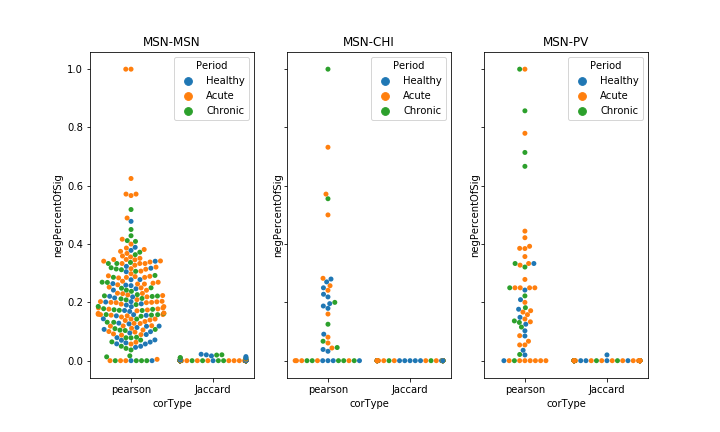

C:\Users\dzemel\Miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 86.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\dzemel\Miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 70.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\dzemel\Miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 75.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [124]:
%matplotlib notebook
# fig, ax = plt.subplots(len(df.mvmt.unique()),3,figsize=(10,10),sharey='row')
# for indp, p in enumerate(['MSN-MSN','MSN-CHI','MSN-PV']): 
#     for indm,mvmt in enumerate(df.mvmt.unique()):
#         df2 = df[(df.population == p)&(df.mvmt==mvmt)]
#         sns.swarmplot(data=df2,x='corType',hue = 'Period',y='negPercentOfSig',ax=ax[indm,indp])
#         ax[indm,0].set_ylabel(mvmt)
#     ax[0,indp].set_title(p)
fig, ax = plt.subplots(1,3,figsize=(10,6),sharey='row')
for indp, p in enumerate(['MSN-MSN','MSN-CHI','MSN-PV']): 
    for indm,mvmt in enumerate(['all']):
        df2 = df[(df.population == p)&(df.mvmt=='all')]
        sns.swarmplot(data=df2,x='corType',hue = 'Period',y='negPercentOfSig',ax=ax[indp])
    ax[indp].set_title(p)

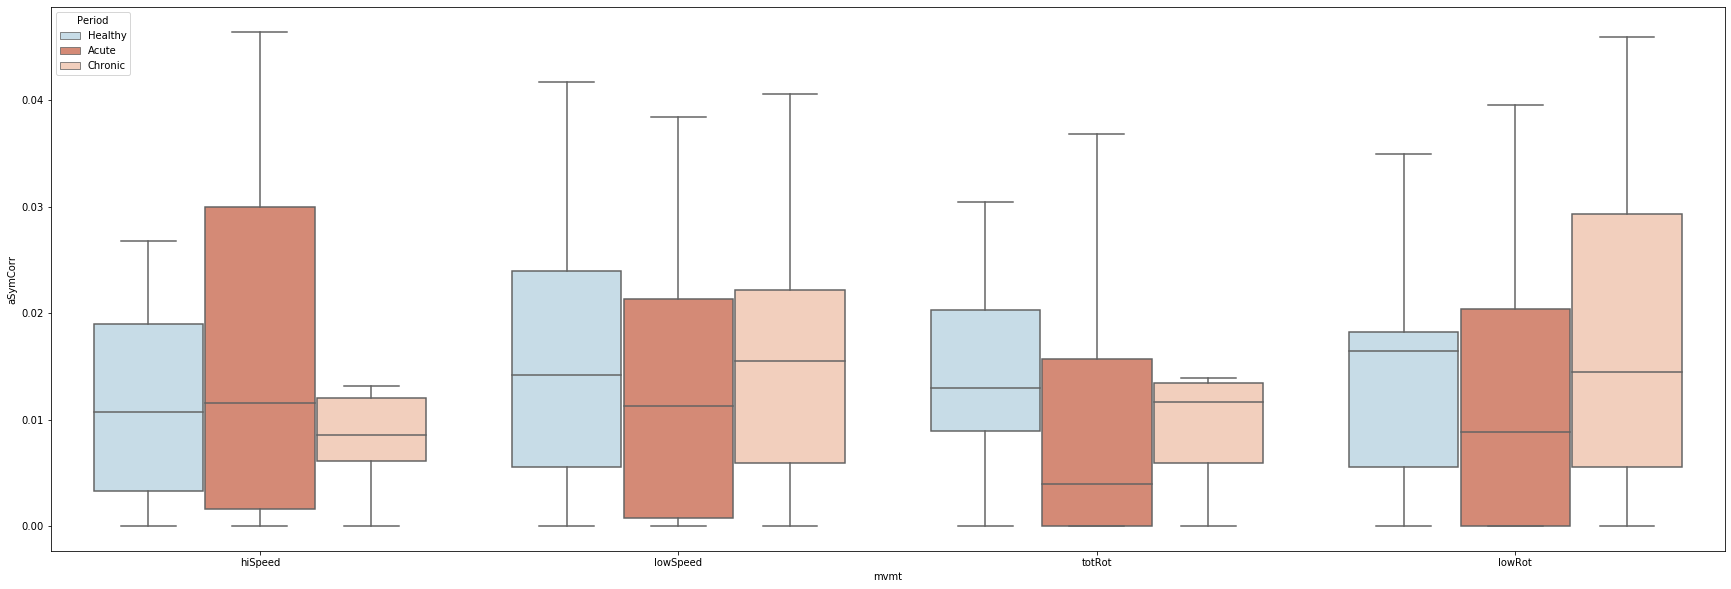

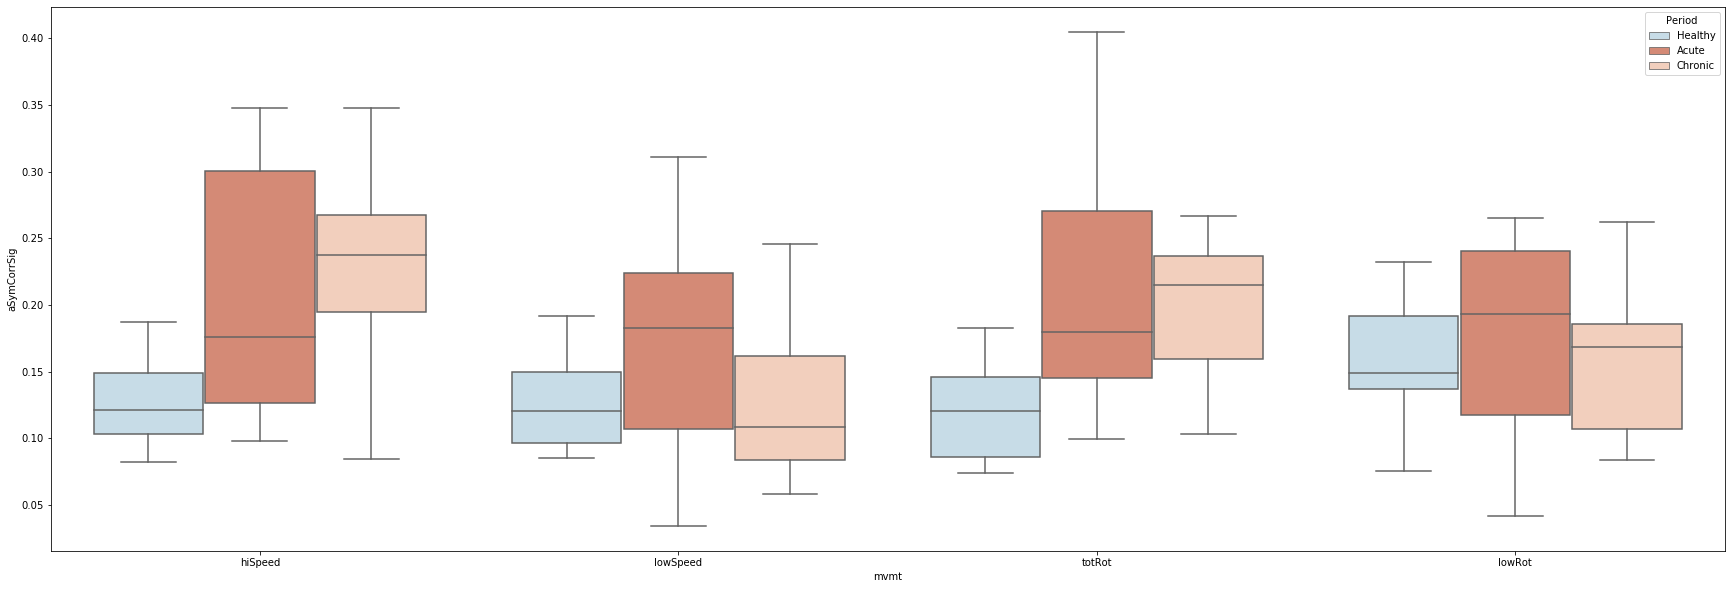

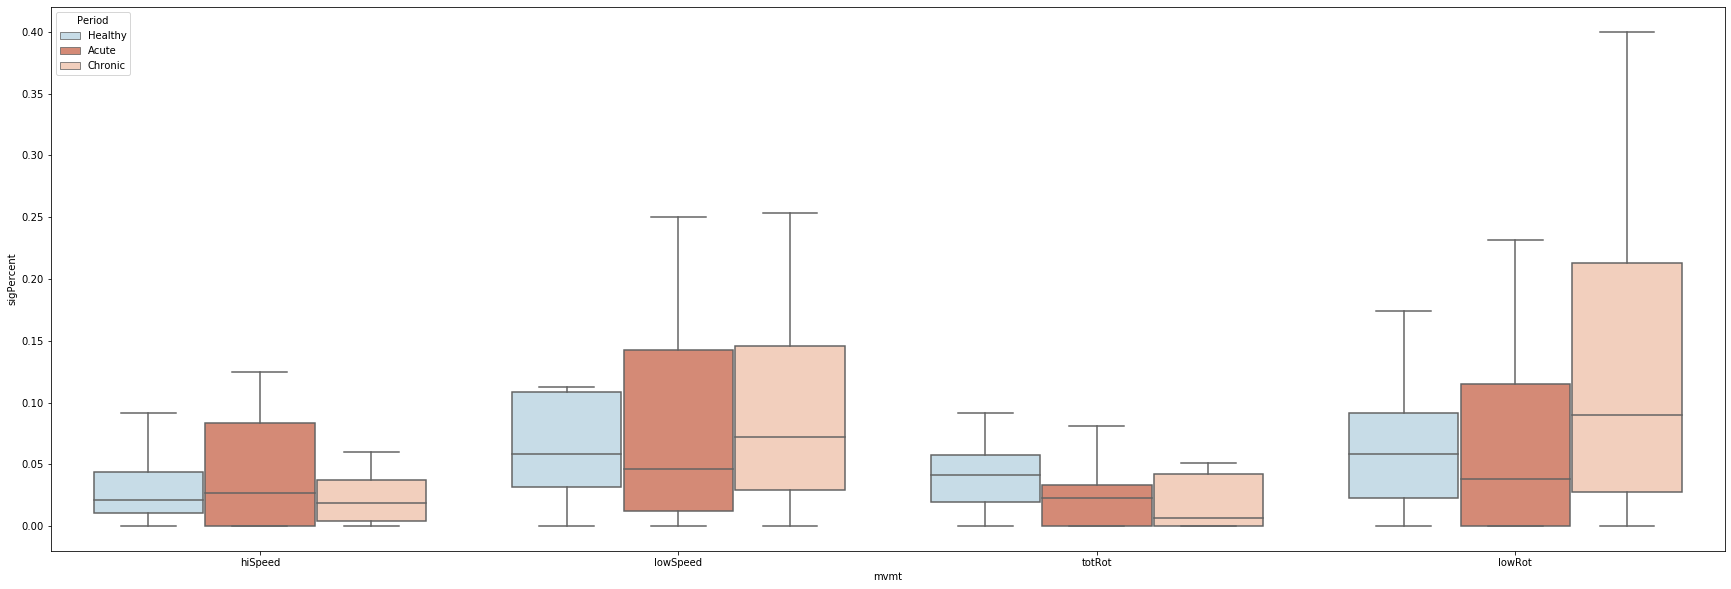

In [80]:
df = pd.read_csv(figFolder+ 'mvmtCorrSig.csv')
for col in ["aSymCorr","aSymCorrSig","sigPercent"]:
    fig, ax  = plt.subplots(1,1,figsize=(30, 10),sharey = True)
    indF = 0;
#     for mvmt in df.mvmt.unique():
    with sns.color_palette(colorPallet3):
        sns.boxplot(x = 'mvmt' ,hue="Period", y=col,#ax = ax[indF],
                    data=df[(df.population == "MSN-CHI")],
                    hue_order = ['Healthy', 'Acute', 'Chronic'], order = ['hiSpeed', 'lowSpeed', 'totRot','lowRot'],
                    showfliers = False)
#         ax[indF].set_title(mvmt)
        indF = indF + 1
    # fig.savefig(figFolder+'figureS5.svg',format='svg')
    # ax[0].set_ylim(-0.2,0.4)
    fig.savefig(figFolder+'figureS5_'+col+'_Jaccard_noFliers_CHI.svg',format='svg')
    # fig, ax  = plt.subplots(1,5,figsize=(30, 10),sharey = True)
    # indF = 0;
    # for p in df.Period.unique():

#     sns.boxplot(x="mvmt", y="aSymCorr",ax = ax[indF],data=df[(df.population == "MSN-MSN")&(df.Period == p)], order = ['hiSpeed', 'lowSpeed', 'lowRot', 'highIpsi', 'highContra'], showfliers = False)
#     ax[indF].set_title(p)
#     indF = indF + 1


In [ ]:
df[(df.population == 'MSN-CHI')&(df.numred>0)].groupby(['mvmt','Period']).count() #(df.Period == 'Day 1-4')&

In [ ]:
dfC = pd.read_csv(figFolder+ 'firingRateDf.csv')
dfM = dfC[(dfC.All>0)][['Sess','Period','CellType','high_ACrot', 'high_Crot','low_rot']]
dfM2 = dfM#.groupby(['Sess','Period','CellType'],as_index=False).mean()

columns = ['high_ACrot', 'high_Crot','low_rot']#, 'high_ACrot', 'high_Crot','low_rot'] 
df_long = pd.melt(dfM2,id_vars=['CellType','Period','Sess'], value_vars=columns,value_name='event/min')
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey=True)
indC = 0
colors = {'MSN':['#C0D3DC','#99B7C5','#3A6C82'], 'PV':['#FFE7C4','#fcb144','#CF9E56'],'CHI':['#DDC0DE','#C69AC8','#98549A']} #'#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
for cell in cells:
#     g = sns.swarmplot(x="Period", y="event/min",hue ='variable' ,data=df_long[(df_long.CellType == cell)],color = [.2,.2,.2],dodge = True,
#                       order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'], 
#                       ax=ax[indC],**{'label':'_nolegend_','alpha':0.5,'s':3})
    g = sns.boxplot(x="Period",hue ='variable', y="event/min",data=df_long[(df_long.CellType == cell)], dodge = True,
                   order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'],
                   palette=colors[cell],ax=ax[indC], showfliers = False)

    ax[indC].set_ylim(0,6)
    indC = indC +1
#fig.savefig(figFolder+'figure3_c.png',transparent=False,format='png')
fig.savefig(figFolder+'figure3_c_v2.svg',transparent=True,format='svg')


In [ ]:
# df2 = dfC[(dfC.CellType=='PV')]
df2 = dfC#[(dfC.All>0)]
# print(dfC.columns) #'high_ACrot','high_Crot','low_rot',
df3 = df2[['All','highSpeed','high_speed','highTime','Sess','Period','CellType']]#.groupby(['Period','CellType'])
print(df3.groupby(['CellType','Period']).count())
# print(df3[(df3.CellType=='PV')&(df3.Period == 'Day 13-20')])
# print(df3[(df3.CellType=='PV')&(df3.Period == 'Day 13-20')])
# print(dfC[(dfC.Sess == '8430_day19L')& (dfC.CellType=='PV')][['highACRotTime','highACrot']])
# dfC.columns

In [ ]:
# This is where I am 
speedData = []
for m in miceList:
    data = getData(Files[1],['speed'],period ='Pre', mice=m)
    
    # calculte % high speed + % low speed
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        hStart = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_StartSegments')
        hEnd = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_EndSegments')
        row['high_speed'] = np.mean(hEnd-hStart)/20
        
        hStart = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_StartSegments')
        hEnd = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_EndSegments')
        row['low_speed'] = np.mean((hEnd-hStart)/20)
        
        hStart = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_StartSegments')
        hEnd = getOnsetOrPeriod(m,sess,'Pre','hiACPeriods_EndSegments')
        row['high_AC'] = np.mean((hEnd-hStart)/20)
        
        hStart = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_StartSegments')
        hEnd = getOnsetOrPeriod(m,sess,'Pre','hiCPeriods_EndSegments')
        row['high_C'] = np.mean((hEnd-hStart)/20)
        
        hStart = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_StartSegments')
        hEnd = getOnsetOrPeriod(m,sess,'Pre','loPeriods_EndSegments')
        row['low_rot'] = np.mean((hEnd-hStart)/20)
    
        speedData.append(row)
          
df = pd.DataFrame(speedData)        
df['Period'] =  df.apply (lambda row: periodCalc(row.Day) , axis=1)
df.head()

In [ ]:
# df_long = df.melt(id_vars=['Session','Period'], value_vars=['high_speed','low_speed','high_AC','high_C','low_rot'])

# sns.boxplot(x='Period',y='value',hue ='variable' ,data= df_long,showfliers = False)
print(df.groupby('Period').mean())